In [1]:
import tensorflow as tf
import datetime, os
#hide tf logs 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2'} 
#0 (default) shows all, 1 to filter out INFO logs, 2 to additionally filter out WARNING logs, and 3 to additionally filter out ERROR logs
import scipy.optimize
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import seaborn as sns 
import codecs, json
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error 

# generates same random numbers each time
np.random.seed(1234)
tf.random.set_seed(1234)

print("TensorFlow version: {}".format(tf.__version__))

TensorFlow version: 2.9.1


# *Data Prep*

Training and Testing data is prepared from the solution file

In [2]:
## Data Import
K_real = np.load('./K_tx_real_d_one.npy') # Values of K(t,x)
Q_real = np.load('./Q_15minutes.npy') # Input Matrix of Model
f_real = Q_real[:,1] # Inflow Rate
v_real = Q_real[:,3] # Average Speed
pi_real = np.load('./pitilde_15minutes.npy') # Values of pi(t,x)

In [3]:
pi_real.shape

(150, 2016)

Text(0, 0.5, 'Remaining Trip Distance (miles)')

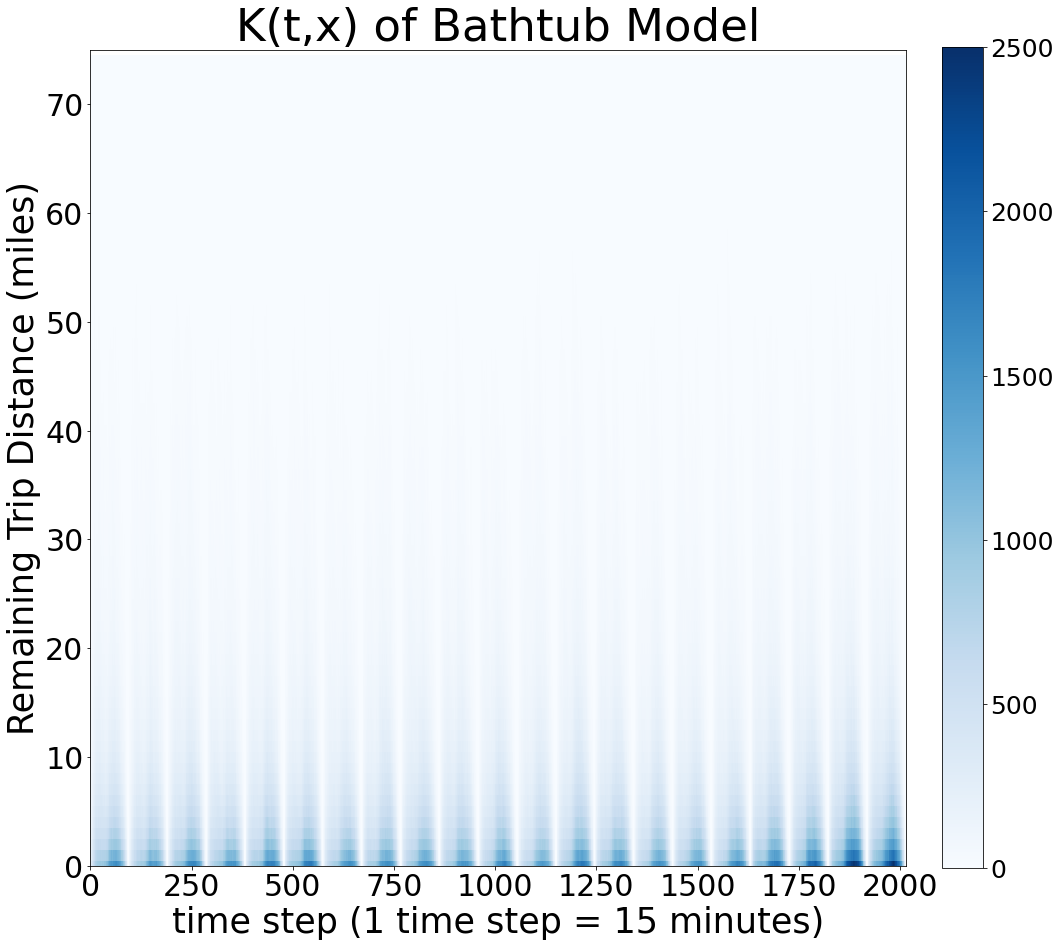

In [4]:
K_array = np.array(K_real[:,0:len(K_real[0])])
fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.T, cmap = 'Blues', interpolation='nearest')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,len(K_real[0])])
plt.clim(0, 2500) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title('K(t,x) of Bathtub Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (miles)', fontsize=35)

In [5]:
## Scale
N_timestep = 24*21*4 # 24 hours * 21 days * 15 minutes = total timestep
N_diststep = 75 # 1 distance step = 1 mile
Size_diststep = 1 # unit: miles
N_trainingdays = 0 # Set zero (0)
N_training = 24*4*N_trainingdays # Training data is all


## Normalization [0,1]
x = np.arange(0,int(N_diststep/Size_diststep))[:,None]   # x: step of remaining distance
t = np.arange(0,N_timestep)[:,None]    # Time step 
usol = K_real.transpose() [:,N_training:]     # real value of K(t,x) ==> Target Variable
usol_max = usol.max()

## Normalization [0,1]
x = (x - x.min()) / (x.max() - x.min())
t = (t - t.min()) / (t.max() - t.min())
f_real = (f_real - usol.min()) / (usol.max() - usol.min())  # usol과 같은 dimension이어야 함. 단위 같기 때문.
v_real = (v_real - v_real.min()) / (v_real.max() - v_real.min())
usol = (usol - usol.min()) / (usol.max()-usol.min())

X, T = np.meshgrid(x,t)                     # makes 2 arrays X and T such that u(X[i],T[j])=usol[i][j] are a tuple


multiplier_dist = int(N_diststep/Size_diststep)-1
multiplier_time = N_timestep-1
multiplier_u = usol_max
print('multiplier distance = ', multiplier_dist)
print('multiplier time = ', multiplier_time)
print('usol max = ', usol_max)

multiplier distance =  74
multiplier time =  2015
usol max =  2500


In [6]:
Size_diststep = 3 # unit: miles
size_input = int(N_diststep/Size_diststep)*N_timestep # Total number of grid points
# size_input = int(N_diststep/Size_diststep)*2 + N_timestep*7 # Boundary
N_u = int(size_input*0.2) # Total number of data points for 'u' ==> Training data from grid points
N_f = N_u*2 #Total number of collocation (auxiliary) points 
alpha = 0.5 # weights of loss

print('size input = ', size_input)
print('N_u = ', N_u)
print('N_f = ', N_f)

size input =  50400
N_u =  10080
N_f =  20160


In [7]:
# # Previous version (before Aug 30)
# size_input = int(N_diststep/Size_diststep)*N_timestep # All domain
# # size_input = int(N_diststep/Size_diststep)*2 + N_timestep*7 # Boundary
# N_u = int(size_input*0.5) #Total number of data points for 'u'
# N_f = N_u*2 #Total number of collocation points 
# alpha = 0.5

# print('size input = ', size_input)
# print('N_u = ', N_u)
# print('N_f = ', N_f)

# *Grid Data*

We prepare the grid data to compare against the solution produced by the PINN.

In [8]:
''' X_u_test = [X[i],T[i]] [25600,2] for interpolation'''
X_u_grid = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))

# Domain bounds
lb = X_u_grid[0]  # [-1. 0.]
ub = X_u_grid[-1] # [1.  0.99]

'''
   Fortran Style ('F') flatten,stacked column wise!
   u = [c1 
        c2
        .
        .
        cn]

   u =  [25600x1] 
'''
u_grid = usol.flatten('F')[:,None] 

# *Training Data* (All domain)


The boundary conditions serve as the test data for the PINN and the collocation points are generated using **Latin Hypercube Sampling**

In [9]:
def trainingdata(N_u,N_f):

#     '''Boundary Conditions'''

#     #Initial Condition 0 =< x =< 9 (135 miles) and t = 0  
#     leftedge_x = np.hstack((X[0,:][:,None], T[0,:][:,None])) #L1
#     leftedge_u = usol[:,0][:,None]
    
#     #Initial Condition 0 =< x =< 9 (135 miles) and t = 2015  
#     rightedge_x = np.hstack((X[0,:][:,None], T[-1,:][:,None])) #L1
#     rightedge_u = usol[:,-1][:,None]

#     #Boundary Condition x = 9 (135 miles) and 0 =< t =<2015
#     topedge_x = np.hstack((X[:,-1][:,None], T[:,0][:,None])) #L3
#     topedge_u = usol[-1,:][:,None]
        
#     #Boundary Condition x = 0 and 0 =< t =<2015
#     bottomedge_x = np.hstack((X[:,0][:,None], T[:,0][:,None])) #L2
#     bottomedge_u = usol[0,:][:,None]
    
#     #Boundary Condition x = 5 (25 miles) and 0 =< t =<2015
#     midedge_x = np.hstack((X[:,5][:,None], T[:,0][:,None])) #L3
#     midedge_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 10 (50 miles) and 0 =< t =<2015
#     midedge1_x = np.hstack((X[:,10][:,None], T[:,0][:,None])) #L3
#     midedge1_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 15 (75 miles) and 0 =< t =<2015
#     midedge2_x = np.hstack((X[:,15][:,None], T[:,0][:,None])) #L3
#     midedge2_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 20 (100 miles) and 0 =< t =<2015
#     midedge3_x = np.hstack((X[:,20][:,None], T[:,0][:,None])) #L3
#     midedge3_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 25 (125 miles) and 0 =< t =<2015
#     midedge4_x = np.hstack((X[:,25][:,None], T[:,0][:,None])) #L3
#     midedge4_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 2 and 0 =< t =<2015
#     bottomedge_x_2 = np.hstack((X[:,1][:,None], T[:,0][:,None])) #L2
#     bottomedge_u_2 = usol[2,:][:,None]
    
#     #Boundary Condition x = 1 and 0 =< t =<2015
#     bottomedge_x_1 = np.hstack((X[:,1][:,None], T[:,0][:,None])) #L2
#     bottomedge_u_1 = usol[1,:][:,None]


#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x, midedge_x, midedge1_x, midedge2_x, midedge3_x, midedge4_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u, midedge_u, midedge1_u, midedge2_u, midedge3_u, midedge4_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x, midedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u, midedge_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([bottomedge_x, bottomedge_x_1, bottomedge_x_2]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([bottomedge_u, bottomedge_u_1, bottomedge_u_2])   #corresponding u [4042,]
    
#     all_X_u_train = np.vstack([bottomedge_x, topedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([bottomedge_u, topedge_u])   #corresponding u [4042,]

    all_X_u_train = np.hstack((X.T[range(0,N_diststep,Size_diststep)].flatten()[:,None],T.T[range(0,N_diststep,Size_diststep)].flatten()[:,None]))
    all_u_train = usol[range(0,N_diststep,Size_diststep)].flatten()[:,None]
    
    #choose random N_u points for training
    np.random.seed(1234)
    train_idx = np.random.choice(all_X_u_train.shape[0], N_u, replace=False) # ID of training data
    test_idx = np.delete(np.arange(size_input), train_idx) # ID of testing data
    
    # Training Data
    X_u_train = all_X_u_train[train_idx, :] #choose indices from  set 'idx' (x,t)
    u_train = all_u_train[train_idx,:]      #choose corresponding u
    
    # Testing Data
    X_u_test = all_X_u_train[test_idx, :]
    u_test = all_u_train[test_idx,:]

    '''Collocation Points'''

    # Latin Hypercube sampling for collocation points 
    # N_f sets of tuples(x,t)
#     X_f_train = np.rint(lb + (ub-lb)*lhs(2,N_f))
    X_f_train = (lb + (ub-lb)*lhs(2,N_f))
#     X_f_train = np.unique(X_f_train, axis=0).astype(int) # 중복된 것 없앰
    X_f_train = np.vstack((X_f_train, X_u_train)) # append training points to collocation points 
    
    f_t = f_real[np.int0(X_f_train*multiplier_time)[:,1]][:,None]
    pi_tx = pi_real[np.int0(X_f_train*multiplier_dist)[:,0],np.int0(X_f_train*multiplier_time)[:,1]][:,None]
    v_t = v_real[np.int0(X_f_train*multiplier_time)[:,1]][:,None]

    return X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx

In [10]:
X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx  = trainingdata(N_u,N_f)

In [11]:
X_u_train.shape

(10080, 2)

In [12]:
X_u_test.shape

(40320, 2)

In [13]:
X_u_train

array([[0.16216216, 0.47047146],
       [0.72972973, 0.80049628],
       [0.12162162, 0.40942928],
       ...,
       [0.08108108, 0.59503722],
       [0.24324324, 0.88188586],
       [0.36486486, 0.97766749]])

# **PINN**

Generate a **PINN** of L hidden layers, each with n neurons. 

Initialization: ***Xavier***

Activation: *tanh (x)*

In [14]:
class Sequentialmodel(tf.Module): 
    def __init__(self, layers, name=None):
       
        self.W = []  #Weights and biases
        self.parameters = 0 #total number of parameters
        
        for i in range(len(layers)-1):
            
            input_dim = layers[i]
            output_dim = layers[i+1]
            
            #Xavier standard deviation 
            std_dv = np.sqrt((2.0/(input_dim + output_dim)))

            #weights = normal distribution * Xavier standard deviation + 0
            w = tf.random.normal([input_dim, output_dim], dtype = 'float64') * std_dv
                       
            w = tf.Variable(w, trainable=True, name = 'w' + str(i+1))

            b = tf.Variable(tf.cast(tf.zeros([output_dim]), dtype = 'float64'), trainable = True, name = 'b' + str(i+1))
                    
            self.W.append(w)
            self.W.append(b)
            
            self.parameters +=  input_dim * output_dim + output_dim
    
    def evaluate(self,x):
        
        x = (x-lb)/(ub-lb)
        
        a = x
        
        for i in range(len(layers)-2):
            
            z = tf.add(tf.matmul(a, self.W[2*i]), self.W[2*i+1])
            a = tf.nn.tanh(z)
            
        a = tf.add(tf.matmul(a, self.W[-2]), self.W[-1]) # For regression, no activation to last layer
        return a
    
#     def speed(self,x):
        
#         a = tf.math.minimum(u_free, tf.abs(a_speed/x + b_speed))

#         print('speed = ', a)
#         print('k = ', x)

#         return a
    
    def get_weights(self):

        parameters_1d = []  # [.... W_i,b_i.....  ] 1d array
        
        for i in range (len(layers)-1):
            
            w_1d = tf.reshape(self.W[2*i],[-1])   #flatten weights 
            b_1d = tf.reshape(self.W[2*i+1],[-1]) #flatten biases
            
            parameters_1d = tf.concat([parameters_1d, w_1d], 0) #concat weights 
            parameters_1d = tf.concat([parameters_1d, b_1d], 0) #concat biases
        
        return parameters_1d
        
    def set_weights(self,parameters):
                
        for i in range (len(layers)-1):

            shape_w = tf.shape(self.W[2*i]).numpy() # shape of the weight tensor
            size_w = tf.size(self.W[2*i]).numpy() #size of the weight tensor 
            
            shape_b = tf.shape(self.W[2*i+1]).numpy() # shape of the bias tensor
            size_b = tf.size(self.W[2*i+1]).numpy() #size of the bias tensor 
                        
            pick_w = parameters[0:size_w] #pick the weights 
            self.W[2*i].assign(tf.reshape(pick_w,shape_w)) # assign  
            parameters = np.delete(parameters,np.arange(size_w),0) #delete 
            
            pick_b = parameters[0:size_b] #pick the biases 
            self.W[2*i+1].assign(tf.reshape(pick_b,shape_b)) # assign 
            parameters = np.delete(parameters,np.arange(size_b),0) #delete 

            
    # Loss of data discrepancy
    def loss_BC(self,x,y):

        loss_u = tf.reduce_mean(tf.square(y-self.evaluate(x)))
        return loss_u

    # Loss of physics
    def loss_PDE(self, x_to_train_f, f_t, pi_tx, v_t):
    
        g = tf.Variable(x_to_train_f, dtype = 'float64', trainable = False)
        ft = tf.Variable(f_t,dtype = 'float64', trainable = False)
        pitx = tf.Variable(pi_tx,dtype = 'float64', trainable = False)
        vt = tf.Variable(v_t,dtype = 'float64', trainable = False)
    
        x_f = g[:,0:1]
        t_f = g[:,1:2]

        with tf.GradientTape(persistent=True) as tape:

            tape.watch(x_f)
            tape.watch(t_f)

            g = tf.stack([x_f[:,0], t_f[:,0]], axis=1)   

            z = self.evaluate(g)
            u_x = tape.gradient(z,x_f)

        u_t = tape.gradient(z,t_f)
        
        del tape

        f = u_t - vt*(u_x) - tf.multiply(ft, pitx)
        loss_f = tf.reduce_mean(tf.square(f))

        return loss_f
    
    # total loss
    def loss(self,x,y,g,h,i,k,alpha):

        loss_u = self.loss_BC(x,y)
        loss_f = self.loss_PDE(g,h,i,k)

        loss = alpha*loss_u + (1-alpha)*loss_f

        return loss, loss_u, loss_f
    
    def optimizerfunc(self,parameters):
        
        self.set_weights(parameters)
       
        with tf.GradientTape() as tape:
            tape.watch(self.trainable_variables)
            
            loss_val, loss_u, loss_f = self.loss(X_u_train, u_train, X_f_train, f_t, pi_tx, v_t, alpha)
            
        grads = tape.gradient(loss_val,self.trainable_variables)
                
        del tape
        
        grads_1d = [ ] #flatten grads 
        
        for i in range (len(layers)-1):

            grads_w_1d = tf.reshape(grads[2*i],[-1]) #flatten weights 
            grads_b_1d = tf.reshape(grads[2*i+1],[-1]) #flatten biases

            grads_1d = tf.concat([grads_1d, grads_w_1d], 0) #concat grad_weights 
            grads_1d = tf.concat([grads_1d, grads_b_1d], 0) #concat grad_biases

        return loss_val.numpy(), grads_1d.numpy()
    
    def optimizer_callback(self,parameters):
               
        loss_value, loss_u, loss_f = self.loss(X_u_train, u_train, X_f_train, f_t, pi_tx, v_t, alpha)
        
        u_pred = self.evaluate(X_u_test)
        error_vec = np.linalg.norm((u_test-u_pred),2)/np.linalg.norm(u_test,2)
        loss_record.append(loss_value)
        l2_record.append(error_vec)
        tf.print(loss_value, loss_u, loss_f, error_vec)
        

# *Model Training and Testing*

A function '**model**' is defined to generate a NN as per the input set of hyperparameters, which is then trained and tested. The L2 Norm of the solution error is returned as a comparison metric

In [15]:
# Training data
X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx  = trainingdata(N_u,N_f)
#alpha = int(N_f/N_u) #weight of loss function

layers = np.array([2,20,20,20,20,20,20,20,20,1]) #8 hidden layers
loss_record = []
l2_record = []

PINN = Sequentialmodel(layers)

init_params = PINN.get_weights().numpy()

start_time = time.time() 

# train the model with Scipy L-BFGS optimizer
results = scipy.optimize.minimize(fun = PINN.optimizerfunc, 
                                  x0 = init_params, 
                                  args=(), 
                                  method='L-BFGS-B', 
                                  jac= True,        # If jac is True, fun is assumed to return the gradient along with the objective function
                                  callback = PINN.optimizer_callback, 
                                  options = {'disp': None,
                                            'maxcor': 100, 
                                            'ftol': 1 * np.finfo(float).eps,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
#                                             'ftol': 1e-10,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
                                            'gtol': 1e-10, 
                                            'maxfun':  50000, 
                                            'maxiter': 15000,
                                            'iprint': -1,   #print update every 50 iterations
                                            'maxls': 50})
end_time = time.time()

0.0045116471393635681 0.008273536546372539 0.00074975773235459774 0.8020559258140002
0.0044449379008956614 0.0082351239567966319 0.00065475184499469137 0.8006635853251536
0.0043812506723775579 0.0081808762550435836 0.00058162508971153291 0.7986484638369251
0.0043018455939262583 0.0080483132030501336 0.00055537798480238343 0.7928087663151023
0.0041502127055199822 0.0077493684400908843 0.00055105697094908021 0.7789306197336366
0.0040306941673149835 0.0075558558177699423 0.00050553251686002532 0.7691785395017051
0.0039990178066828669 0.0075216442699990744 0.00047639134336665927 0.7671779828812811
0.0039841570652215524 0.0075173471140319728 0.0004509670164111316 0.7668186386763002
0.0039550682506393209 0.0075175901982887528 0.00039254630298988927 0.7667330122760744
0.0039253815607816689 0.0075122401173323659 0.00033852300423097123 0.7666395029438674
0.003906433248031008 0.007493791691850462 0.0003190748042115541 0.7660072354139846
0.0038979184922866977 0.0074867129682657631 0.0003091240163

0.0024655565261200857 0.0042006267864764532 0.000730486265763718 0.5851765074188847
0.0024654419445765052 0.004200026057807023 0.00073085783134598772 0.5851156726310186
0.0024653439304275007 0.0041978141825309914 0.00073287367832400969 0.5848376335180996
0.0024652852953986923 0.0041989056112996491 0.00073166497949773512 0.5849298683489664
0.0024651773003448044 0.0041986465875806425 0.00073170801310896625 0.5849342174183833
0.0024650709405006168 0.0042055982932024385 0.0007245435877987949 0.5854186137783581
0.0024650293852791442 0.00420105166856378 0.00072900710199450881 0.585093052888098
0.002465016875068826 0.0042012616317932006 0.00072877211834445092 0.585101858954769
0.0024649692968784103 0.0042033974671185316 0.00072654112663828876 0.5852143267195506
0.0024649462809877782 0.0042044547485202378 0.00072543781345531884 0.5852756251172485
0.0024649084878133648 0.0042048745020947841 0.00072494247353194522 0.5852959432514314
0.0024648882034647712 0.0042051295626406157 0.00072464684428892

0.0024563454072379109 0.0041904843024178143 0.0007222065120580073 0.584205953572366
0.0024562833310957945 0.0041865775627967358 0.00072598909939485359 0.5839909071420846
0.0024562351287685446 0.0041813180893441821 0.00073115216819290708 0.5836515757859517
0.0024562199593065135 0.00418185899108455 0.000730580927528477 0.5836928533394623
0.0024561972142762207 0.0041817586731665458 0.00073063575538589564 0.5836791069388373
0.0024561693460952968 0.0041819558836378558 0.00073038280855273791 0.5836883605163226
0.0024561311777686217 0.004184040309033848 0.00072822204650339537 0.5838372351085358
0.0024561148558327208 0.0041819098895122357 0.00073031982215320587 0.583685503065525
0.002456103511620596 0.00418111725296758 0.00073108977027361245 0.5836318284577531
0.002456071686912197 0.0041790700626235166 0.00073307331120087734 0.5834900922760621
0.0024560485468040731 0.0041795681000064543 0.00073252899360169211 0.5835047072181295
0.0024560040335366417 0.0041796357755027411 0.000732372291570542 0

0.0024487873941728185 0.0041807659697681585 0.00071680881857747836 0.583153661804105
0.0024486774738475231 0.0041836691811354427 0.0007136857665596037 0.5833150586709057
0.0024485579174451434 0.0041863713449358572 0.00071074448995442981 0.5834914178043323
0.0024484221109804917 0.0041785575593127405 0.000718286662648243 0.5829331691310593
0.0024482255267182333 0.0041814084125203184 0.00071504264091614865 0.5831445139818334
0.0024481389989898213 0.0041782791932679763 0.00071799880471166641 0.5829736143881913
0.0024480448937764031 0.0041811811066715422 0.00071490868088126412 0.5831232684223059
0.002447979413373832 0.0041837400336658549 0.00071221879308180881 0.5832658499091661
0.002447875085969344 0.004185569650285036 0.00071018052165365228 0.5833218887039947
0.0024477687127318062 0.0041773183194316584 0.00071821910603195392 0.5827688923346399
0.0024476052291836762 0.0041856370418413783 0.000709573416525974 0.5833329527554377
0.0024475198127951927 0.0041783466509637988 0.00071669297462658

0.0024461360184070556 0.0041739581510366764 0.00071831388577743474 0.5822789358226396
0.002446131268571042 0.0041710946275678252 0.000721167909574259 0.5820898030314933
0.002446124947056053 0.0041720227980437743 0.00072022709606833193 0.5821567350562178
0.0024461181416968437 0.0041730594251013359 0.00071917685829235123 0.5822242194543815
0.0024461083448812167 0.0041734480458450532 0.00071876864391737987 0.582253391008826
0.0024460894077595555 0.00417300215901001 0.00071917665650910053 0.5822244172910267
0.0024460846933049307 0.0041707477992793743 0.00072142158733048739 0.5820653810811892
0.0024460692687777886 0.0041713061544801462 0.00072083238307543089 0.5821128495931386
0.0024460664596886467 0.0041733988948194356 0.00071873402455785754 0.5822460116149858
0.0024460593215229719 0.0041725788639550834 0.00071953977909086078 0.5821938537535429
0.0024460507970898429 0.0041708654542010849 0.00072123613997860042 0.5820827532389389
0.00244604157191532 0.0041704940645206825 0.00072158907930995

0.002444766073463089 0.0041704060845883144 0.00071912606233786322 0.5819126012185225
0.0024447607462061626 0.0041708803774007782 0.00071864111501154663 0.5819489213014594
0.0024447579044182891 0.0041699724049869321 0.00071954340384964557 0.5818823033888947
0.0024447563761003776 0.004169927346605028 0.00071958540559572727 0.5818822015834163
0.0024447530244510658 0.0041697875172507677 0.00071971853165136372 0.581877437046118
0.0024447477980818607 0.0041697488776808005 0.00071974671848292079 0.5818769019583396
0.0024447405243124285 0.0041695659023953009 0.00071991514622955582 0.5818626457863095
0.0024447364444654175 0.0041686846043440988 0.00072078828458673621 0.5817957281812667
0.0024447313083558186 0.0041697949183715048 0.00071966769834013226 0.5818735029927008
0.0024447289798165935 0.0041695803488901234 0.00071987761074306339 0.5818624406462645
0.0024447245037882426 0.0041686583183161239 0.00072079068926036093 0.5817962353938916
0.0024447193638144175 0.0041691096569278514 0.00072032907

0.00244415906222285 0.0041699091715012154 0.00071840895294448506 0.5819052481109223
0.0024441409596397839 0.0041701095584875617 0.00071817236079200629 0.5819175476021538
0.0024441228232600994 0.0041712651049994418 0.00071698054152075725 0.5819807008415423
0.0024440960372297455 0.00417156335438261 0.00071662872007688156 0.5819896522099486
0.0024440649742362261 0.0041695857475679719 0.00071854420090448033 0.5818179902127821
0.0024440476230535311 0.0041675009757274365 0.00072059427037962523 0.5816720439813218
0.0024440254836777704 0.0041691566442797028 0.00071889432307583765 0.5817735388571637
0.0024439935068465042 0.0041678551185724061 0.00072013189512060247 0.5816904772531609
0.0024439755117036518 0.00416610010587383 0.00072185091753347336 0.5815647795122837
0.0024439645028974479 0.0041663760198975613 0.00072155298589733478 0.5815834017511449
0.0024439472970961343 0.004168036482581 0.00071985811161126871 0.58166965767866
0.0024439377194792286 0.0041669205381379155 0.00072095490082054153

0.0024431012749109803 0.0041656419292693155 0.000720560620552645 0.581428780034525
0.0024430704198469873 0.0041677413936027164 0.00071839944609125832 0.5815909804825017
0.0024430597800238411 0.0041694828795134746 0.00071663668053420764 0.58172369676978
0.0024430400074742808 0.0041687072949456979 0.00071737272000286373 0.5816769865908139
0.0024430344710656983 0.0041677061855396125 0.00071836275659178429 0.5816233804414271
0.0024430288166291405 0.004166653477192305 0.00071940415606597588 0.5815533916112787
0.0024430246054387185 0.0041677052210309729 0.000718343989846464 0.5816300076838498
0.0024430211666049638 0.0041673919123866527 0.00071865042082327535 0.5816123889610469
0.0024430101061981087 0.0041665622043213363 0.00071945800807488079 0.5815719198971779
0.0024430002016149425 0.0041666511266774372 0.00071934927655244792 0.5815856667438157
0.0024429819737132354 0.0041679216524132144 0.00071804229501325645 0.5816817210518153
0.0024429715310359036 0.0041680659651328793 0.0007178770969389

0.0024366886018874555 0.0041654061838098787 0.00070797101996503229 0.581260360220419
0.0024366476063130888 0.004164452249040212 0.00070884296358596569 0.5811967456839535
0.0024366231875033676 0.004164734963440473 0.00070851141156626229 0.5812093026507024
0.0024365587933709324 0.0041628755323990865 0.00071024205434277868 0.5810959420566042
0.00243646636231402 0.0041646446500359906 0.00070828807459204918 0.5812193352721605
0.0024363701620652048 0.0041648868160559021 0.0007078535080745071 0.5812654925259702
0.0024362797877652111 0.0041652779732721766 0.00070728160225824515 0.5813047812192617
0.0024361387211221516 0.0041647534372743237 0.0007075240049699799 0.5812845538157817
0.0024360468818855007 0.0041614989417036331 0.00071059482206736865 0.5811202844172739
0.0024359881976365122 0.0041580992167368066 0.00071387717853621828 0.5809035109768406
0.0024359351543792947 0.0041634523859762967 0.000708417922782293 0.581303877440112
0.0024358619620378471 0.0041587241479214693 0.000712999776154225

0.0024100651196515815 0.0041243211323614666 0.00069580910694169631 0.5789774132959994
0.0024099564568386272 0.0041223593196614639 0.0006975535940157905 0.5789387486841372
0.0024098922570604813 0.0041243878261006343 0.00069539668802032857 0.5790257156498081
0.0024098346944224015 0.0041288195339538722 0.00069084985489093116 0.5792732450202794
0.0024097201662395371 0.00412238342424975 0.00069705690822932415 0.5788733522822832
0.0024096665765647794 0.0041262617343296908 0.0006930714187998678 0.5791589204648289
0.002409568356072752 0.0041240914690068107 0.00069504524313869346 0.5789702899151157
0.0024094924240828436 0.0041238732399668009 0.00069511160819888621 0.5789314265820765
0.0024094707098780187 0.0041248342099200266 0.00069410720983601045 0.5789800290316393
0.0024094637726414635 0.0041250500319595148 0.00069387751332341228 0.5790159641525117
0.0024094547338216147 0.0041248384949771439 0.00069407097266608513 0.57899654248813
0.0024094409812335138 0.0041244144219274113 0.000694467540539

0.0023862011464531189 0.0041047193265654489 0.00066768296634078924 0.5782537500179389
0.002386007633015622 0.0041043322544775853 0.00066768301155365893 0.5782887511726686
0.0023858052250721054 0.0041056611590950488 0.00066594929104916176 0.5784635874968151
0.0023857015305514665 0.0041005855957439658 0.00067081746535896749 0.5780529860426702
0.0023855177566462571 0.0040986409136495507 0.00067239459964296331 0.5778628780817942
0.0023852186137242222 0.0041046832390692874 0.00066575398837915689 0.578268183895782
0.00238496355066879 0.0041040692464567805 0.00066585785488079935 0.5783202238861254
0.0023848638879521429 0.0041045270511899943 0.00066520072471429163 0.5783137924055594
0.0023846960441298473 0.0040966222326431654 0.000672769855616529 0.5777825920432738
0.0023845527466494977 0.0041036105495255619 0.00066549494377343373 0.5781849188654291
0.002384495958167478 0.0041023983412963481 0.00066659357503860771 0.5780607119161301
0.002384466311086143 0.0041038268282825186 0.0006651057938897

0.0023797859882393334 0.0041003104285895261 0.0006592615478891407 0.5781616430435739
0.0023796599208739944 0.0041001640570334117 0.00065915578471457709 0.5781287814823501
0.0023795327433598335 0.0040996734552818156 0.00065939203143785142 0.5781548184699133
0.0023794980759080922 0.00410327775171271 0.00065571840010347391 0.5783665945154318
0.0023794379152715438 0.0040969496734413165 0.00066192615710177112 0.5780070493869979
0.0023794045522289014 0.0040965908082561137 0.00066221829620168916 0.577945965389739
0.0023793830489785527 0.0041006393650493975 0.0006581267329077077 0.5782393126433965
0.0023793427224266337 0.004100385305424969 0.00065830013942829845 0.5781866629084307
0.0023792902395340146 0.0040988064306133722 0.00065977404845465675 0.5780675320974854
0.0023792191888178439 0.0040999759357286921 0.00065846244190699533 0.5781438304049118
0.0023792018803596563 0.0040984503657217584 0.00065995339499755389 0.5780922335536325
0.00237915569029091 0.0041010760844745519 0.0006572352961072

0.0023687513231964376 0.0040786002679809238 0.00065890237841195114 0.577054774387044
0.0023685175846348792 0.004079808425838629 0.0006572267434311296 0.5771018724588366
0.0023683347132738108 0.00407792234970697 0.00065874707684065135 0.5769478596436205
0.0023682206958395122 0.0040776028773355033 0.00065883851434352081 0.576970914238364
0.0023681099441549779 0.0040825626618880605 0.0006536572264218951 0.5773237001605297
0.0023679571234068368 0.0040779803385493744 0.00065793390826429925 0.5770442605154111
0.0023678039999764098 0.00407714152494052 0.0006584664750122997 0.5769944968571266
0.002367686184580063 0.0040801557630717172 0.00065521660608840887 0.5772247674090605
0.0023676510235844865 0.0040840563393914958 0.0006512457077774772 0.5774253189313688
0.0023675865767433793 0.0040836956285792425 0.00065147752490751613 0.5774526416376454
0.0023675525678264692 0.0040843015916591282 0.00065080354399380989 0.5774811633192859
0.0023674051239950707 0.0040836297345844732 0.000651180513405668 0

0.0023603694821232508 0.0040671282292515784 0.0006536107349949231 0.5763988850055668
0.0023603331308289007 0.0040680308285724418 0.00065263543308535961 0.5764621122735484
0.0023602767174137141 0.0040657178294776185 0.00065483560534981009 0.576288751449539
0.0023602516573029554 0.0040651276315182491 0.00065537568308766166 0.5762761710541983
0.00236020520668975 0.0040661385406052519 0.00065427187277424816 0.5763207804423509
0.0023601928568808914 0.0040643140722430278 0.00065607164151875548 0.5761575748734143
0.0023601597816010262 0.0040636549359659678 0.000656664627236085 0.5761446862204829
0.002360136377606474 0.0040652524525088985 0.00065502030270404973 0.5762531968684386
0.0023601139604255703 0.0040655256280798463 0.00065470229277129457 0.5762646015760996
0.0023600721661653896 0.0040657970780822632 0.00065434725424851623 0.5762682752282889
0.0023599905580167675 0.0040653046468713009 0.00065467646916223443 0.5762241940427684
0.0023598665008098159 0.0040645104252668681 0.000655222576352

0.0023523255456899452 0.0040482322715145961 0.00065641881986529466 0.5749333248745228
0.0023522655657801394 0.0040472987084765946 0.000657232423083684 0.5748831762363383
0.0023522409902419772 0.0040463209121597383 0.00065816106832421628 0.5748105371480027
0.0023522138603093729 0.0040495066084134286 0.00065492111220531734 0.5750610302155839
0.0023521676498139028 0.0040473690292283076 0.00065696627039949786 0.5749126641325701
0.0023521115866065138 0.0040461149292397285 0.00065810824397329938 0.574818923623924
0.00235208575259231 0.0040456861364131626 0.00065848536877145694 0.5747910494045375
0.002352077589248562 0.0040453034835412618 0.00065885169495586207 0.5747488499589214
0.0023520503792835703 0.0040472960359397032 0.0006568047226274379 0.5748972224992472
0.0023520277117607654 0.0040469171817479671 0.00065713824177356366 0.5748728761626296
0.0023519971260833861 0.00404622432850424 0.00065776992366253263 0.5748283986494545
0.0023519262029966319 0.0040474781896736919 0.00065637421631957

0.0023442932893191167 0.0040350494413585415 0.00065353713727969232 0.5740533383946531
0.002344267239047803 0.0040334516875453292 0.00065508279055027669 0.5739472704243392
0.0023442444947118397 0.0040321397846551626 0.00065634920476851711 0.5738765889509205
0.0023442258909713771 0.0040317328885929532 0.00065671889334980075 0.5738606884262157
0.0023441801264135528 0.0040313262685082365 0.00065703398431886861 0.5738492804721326
0.0023440910189406741 0.00403099780919234 0.00065718422868900838 0.5738291578577959
0.0023440254827322856 0.0040297636504753312 0.00065828731498924 0.5737684981097388
0.0023439587881357682 0.0040316111020426634 0.00065630647422887291 0.5738553169162529
0.0023439012164175568 0.00403118732779953 0.00065661510503558335 0.5738317144690003
0.00234384175902686 0.004031062212548021 0.00065662130550569933 0.5738202765142962
0.0023437957940288124 0.0040286508447065911 0.000658940743351034 0.5736403662122067
0.0023437052636741 0.0040303442430613158 0.00065706628428688471 0.5

0.0023351490628393638 0.0040143604494274577 0.00065593767625127025 0.5725687092034553
0.0023350164815463073 0.004015862948956752 0.00065417001413586265 0.5726959645594759
0.002334899228975504 0.0040149836410097979 0.00065481481694120965 0.5726953727715266
0.0023348124775762254 0.0040176102547217008 0.00065201470043075053 0.572850962137475
0.0023347383612680093 0.004017130577967677 0.00065234614456834118 0.5728046627256962
0.0023346627501327033 0.0040178089002610553 0.000651516600004351 0.572838156258799
0.0023345599185365354 0.0040174465705829013 0.00065167326649016974 0.5727967405826143
0.0023344005924388713 0.0040152984515962869 0.00065350273328145566 0.5726295346012079
0.002334295081550248 0.0040298583197012827 0.00063873184339921334 0.5736277015566476
0.0023340201394776517 0.0040186838250647582 0.00064935645389054518 0.5728995335194964
0.0023339091998769391 0.0040153445849081581 0.0006524738148457204 0.57265890837098
0.002333713901051008 0.00401617523951224 0.00065125256258977561 0

0.0023167321067995733 0.0039833111127895345 0.00065015310080961239 0.5708815774278668
0.0023166129337812407 0.0039857307809672187 0.00064749508659526242 0.5710405302108467
0.0023164270726806404 0.0039826564391568786 0.00065019770620440239 0.5707945542577499
0.0023162839664168378 0.0039823915490306205 0.00065017638380305534 0.570756569371138
0.00231610364255185 0.0039832644444709377 0.0006489428406327623 0.5707688059136807
0.0023159441161391212 0.0039830359753723127 0.00064885225690592958 0.5706954159377193
0.0023157691805288511 0.0039819794862539365 0.00064955887480376594 0.5706134296160584
0.002315468585775823 0.0039825521735504642 0.00064838499800118138 0.5706523313193785
0.002315113305317403 0.0039857904719597789 0.00064443613867502737 0.5708262971034302
0.0023145405690637695 0.0039871730310268748 0.00064190810710066423 0.5710299593482518
0.0023139265913207151 0.0039879372694530714 0.00063991591318835882 0.5711302392740276
0.0023131307609601573 0.00398832620862503 0.0006379353132952

0.0023072698426307749 0.0039742223968207546 0.00064031728844079518 0.5699752408192948
0.0023071859343821791 0.0039764547047454191 0.00063791716401893949 0.5700875031277831
0.0023071358569912931 0.003974670516568744 0.00063960119741384271 0.5699293361360791
0.0023071221186591606 0.00397497982619781 0.00063926441112051151 0.5700023425930344
0.002307031418605924 0.0039721184700318045 0.00064194436718004383 0.5698008113155439
0.0023070211964644084 0.0039718297681657719 0.00064221262476304487 0.5697079580905922
0.0023069598404401493 0.0039726720221626675 0.00064124765871763063 0.5698078714749326
0.0023069103178498286 0.0039720795268101345 0.00064174110888952243 0.5697875184934373
0.002306835544211312 0.0039720025480935875 0.00064166854032903669 0.5697985752594962
0.0023067698135685725 0.0039701186524918443 0.00064342097464530036 0.5696812478585068
0.0023067198981423886 0.0039726278611489111 0.00064081193513586645 0.5698303840793102
0.0023066482028378729 0.00397211380051357 0.000641182605162

0.0023025465750189564 0.003971009712354 0.00063408343768391333 0.5698221995220163
0.0023025241789857119 0.0039710834822596639 0.00063396487571176015 0.5698496494730176
0.0023024937527929513 0.003970756823584368 0.00063423068200153484 0.5698532145720567
0.0023024413686778857 0.0039693908968334076 0.00063549184052236326 0.5698058953413518
0.0023023814572967209 0.0039687058385468764 0.00063605707604656541 0.5697716497588587
0.0023022902951634781 0.0039674188461418973 0.00063716174418505854 0.5696744245806736
0.0023022070279856352 0.0039672352583747829 0.00063717879759648784 0.569650784465752
0.0023021113420151908 0.0039676806525997792 0.00063654203143060229 0.5696056355661292
0.0023020143180382284 0.0039674838860826811 0.00063654474999377581 0.5695840738167115
0.0023018831765438197 0.0039693716682310731 0.00063439468485656668 0.5696603232535487
0.0023018310673982114 0.0039715645243122129 0.00063209761048420993 0.5698419096047559
0.0023018043031112533 0.0039680278712235211 0.00063558073499

0.0022972570560068064 0.0039553730696881744 0.00063914104232543848 0.5689237677308213
0.0022971565035249655 0.0039582587239494526 0.000636054283100478 0.5690821015130924
0.0022971019735720838 0.0039598098552621839 0.00063439409188198351 0.5692176147228254
0.0022970309886028249 0.0039587116804083175 0.00063535029679733174 0.5691323796423855
0.0022969866766654654 0.0039579707259161283 0.0006360026274148025 0.5690868787650136
0.0022969550795429563 0.0039586456331544822 0.00063526452593143 0.5691541417620367
0.0022969289524933083 0.0039597973661202367 0.00063406053886638021 0.5692253447607676
0.0022968869879075389 0.0039604724143128362 0.00063330156150224136 0.5692964830943799
0.0022968376126886263 0.0039595692480382241 0.00063410597733902876 0.5692300651836085
0.0022967832424348428 0.0039610969016439035 0.0006324695832257821 0.5693145039055558
0.0022967208717248329 0.0039588442201601163 0.0006345975232895497 0.5691470180541005
0.0022966739033160781 0.003957859240101432 0.00063548856653072

0.0022922886614232443 0.0039465935253451753 0.0006379837975013132 0.5682980216451142
0.002292265727679506 0.003946085552191763 0.00063844590316724918 0.5682597186938472
0.0022922372526126169 0.0039459923623448847 0.000638482142880349 0.5682388802759513
0.0022921968640556619 0.003945145298549362 0.00063924842956196188 0.5681675690365968
0.0022921716339587461 0.003946915138202541 0.00063742812971495123 0.5682860734498894
0.00229213368026226 0.0039454362381625896 0.000638831122361931 0.5681622008541417
0.0022920761038123291 0.0039459950587801117 0.0006381571488445467 0.5682080010799824
0.0022920172240063702 0.00394671055401433 0.00063732389399841 0.5682946121694152
0.0022919706019398642 0.003946617816614692 0.0006373233872650362 0.5683334807202548
0.0022919231350719874 0.0039462000037764041 0.00063764626636757043 0.5683250180851627
0.0022918816259995889 0.0039452978100715163 0.00063846544192766152 0.5682942229377201
0.0022918674503931268 0.0039450138780857281 0.00063872102270052578 0.5682

0.0022867764473893577 0.0039402306179341044 0.00063332227684461089 0.5681000788597926
0.002286745365541137 0.0039388364185415931 0.00063465431254068128 0.5680178015177532
0.00228670058596374 0.0039383873574864283 0.0006350138144410513 0.5679648356244849
0.0022866374090022004 0.003938266840682228 0.00063500797732217234 0.567952182735439
0.0022865504835117858 0.0039392455950668795 0.00063385537195669169 0.5680079036255828
0.0022864687331744008 0.0039401062824024084 0.00063283118394639321 0.5680369147163579
0.002286405679719669 0.0039414269781270616 0.00063138438131227648 0.5681084349779768
0.0022863656866045912 0.0039419077210537216 0.00063082365215546112 0.5681355837214775
0.0022863227199924475 0.0039412250862820731 0.00063142035370282186 0.5680797979259709
0.0022862773797334853 0.0039408109087671972 0.00063174385069977358 0.5680502075163467
0.0022862448809252986 0.0039405716607064482 0.00063191810114414913 0.5680644499822258
0.0022862267806896437 0.0039413964052736807 0.000631057156105

0.0022814696094076757 0.0039322336333547413 0.00063070558546061 0.5674767013670671
0.0022813782202281831 0.0039340597796819017 0.00062869666077446475 0.5676187879362216
0.0022813233238705242 0.0039330620432489038 0.00062958460449214436 0.5675758488226258
0.0022812739109609502 0.0039334714733469138 0.00062907634857498648 0.5676093902050422
0.0022812360482299811 0.0039330633912531545 0.0006294087052068078 0.5675711937411931
0.0022812150147171039 0.0039328206744176242 0.00062960935501658324 0.5675317922494628
0.0022811923914184532 0.0039328598897245756 0.00062952489311233074 0.5675505460715873
0.0022811707855705894 0.003932981933192155 0.000629359637949024 0.5675569363320222
0.0022811380819577768 0.0039333477565483225 0.00062892840736723094 0.5675878713841295
0.0022810961940858063 0.0039336466032802277 0.00062854578489138463 0.5676162287083227
0.0022810503414495663 0.0039338203056736862 0.00062828037722544668 0.5676604665428958
0.0022810091329096955 0.0039336684224702744 0.000628349843349

0.0022764269322469504 0.0039254995202504918 0.00062735434424340917 0.5669561269292659
0.0022763926453297856 0.0039256164746576984 0.00062716881600187316 0.5669710400033575
0.0022763566380632379 0.0039245093504616715 0.00062820392566480417 0.5668729154211335
0.0022763207824303758 0.0039240428547018379 0.00062859871015891373 0.5668183275122209
0.0022762678306893773 0.0039224632422077922 0.00063007241917096256 0.5666980488071908
0.0022762150763696717 0.0039218014201969562 0.00063062873254238726 0.5666262793181026
0.0022761553289552005 0.0039209555518814566 0.00063135510602894463 0.5665516144521272
0.0022760933352373117 0.0039201434545615074 0.00063204321591311594 0.5665093375535121
0.0022760253492922523 0.0039197031910650883 0.00063234750751941593 0.5665341710123092
0.0022759543455070611 0.00391758271931273 0.0006343259717013918 0.5663907472869212
0.0022758943253187863 0.00391808000315468 0.00063370864748289268 0.5664331810093217
0.0022758331491609285 0.0039184192273439807 0.0006332470709

0.0022717994896646154 0.0039104871027637062 0.0006331118765655246 0.5659600630705431
0.0022717669016948478 0.0039091830480214489 0.0006343507553682469 0.565863815250803
0.0022717436262419512 0.0039096871498653218 0.00063380010261858031 0.5658896601045491
0.0022717182557164361 0.0039094253876929648 0.00063401112373990729 0.5658845048572626
0.0022716867047845365 0.0039095436656446225 0.00063382974392445007 0.5659094139373504
0.0022716410347182647 0.0039106585555428227 0.00063262351389370679 0.5660039816633563
0.0022716062725672728 0.0039103124220161364 0.00063290012311840906 0.5659815586417888
0.0022715811469761322 0.00390986577039079 0.00063329652356147465 0.5659452422174837
0.0022715657508538211 0.0039103037043285438 0.00063282779737909806 0.5659667646797424
0.0022715545092398567 0.0039098294534628975 0.00063327956501681561 0.565940463962935
0.0022715391106967043 0.0039095508590689908 0.00063352736232441759 0.5659265239952153
0.0022715113132789552 0.0039101109675694226 0.00063291165898

0.0022685379057392572 0.0039005905784957537 0.00063648523298276112 0.5653279665433141
0.0022684347718291632 0.0039001204469426573 0.00063674909671566937 0.565264529546395
0.0022683650306588457 0.0039009554437314485 0.00063577461758624308 0.5652943235872608
0.0022682876753713993 0.00389979966235132 0.00063677568839147871 0.5652219647540011
0.0022682316738978458 0.0038997126983034867 0.00063675064949220519 0.5652087793841412
0.0022681860864088707 0.0038999618728405897 0.00063641029997715153 0.5652276906987972
0.0022681755002145155 0.0039015091738907794 0.00063484182653825161 0.565315591164197
0.0022681121196089669 0.0039018891738581154 0.00063433506535981866 0.5653564866355562
0.0022680943425488534 0.0039016641530935964 0.00063452453200411071 0.5653490244671301
0.0022680679761577865 0.0039015468900933758 0.00063458906222219719 0.5653350506041896
0.0022680433756392996 0.0039008349586662433 0.00063525179261235583 0.5652655304508409
0.0022680202058751242 0.0039015365216290517 0.000634503890

0.002265170320282118 0.0038992494279552264 0.00063109121260900957 0.5651766200697734
0.002265144652743183 0.0038999160953885077 0.00063037321009785853 0.565205147296322
0.0022651233789161029 0.003900247901404 0.0006299988564282058 0.5652361221488362
0.0022650882457772217 0.0039001077912057917 0.00063006870034865181 0.5652367617703269
0.0022650582125881566 0.0038989066933829172 0.00063120973179339583 0.5651434565643066
0.0022650279880135648 0.0038979434968332682 0.00063211247919386134 0.5650887653091293
0.0022649941065190876 0.0038983374619946044 0.00063165075104357085 0.5651159755100964
0.0022649587013551515 0.0038976274918583712 0.00063228991085193214 0.5650760385913903
0.0022649301515008705 0.0038979689513902447 0.00063189135161149641 0.5650973136455499
0.00226489607339697 0.0038986025459004261 0.00063118960089351408 0.565161390611669
0.002264857236019711 0.0038984348723093355 0.00063127959973008612 0.5651621975565673
0.0022648147450090974 0.0038997121904456814 0.00062991729957251287

0.0022614436505984763 0.0038937472941289217 0.00062914000706803066 0.5650281603145185
0.0022614017582428883 0.0038934106454082619 0.00062939287107751469 0.5649873307039522
0.0022613667445147345 0.0038911067871004218 0.00063162670192904715 0.5648221450549
0.0022613340924584327 0.0038900129477591151 0.0006326552371577498 0.564741351559166
0.0022613052068238965 0.0038904546418524412 0.00063215577179535183 0.5647665847501325
0.0022612796211758709 0.0038908843962052689 0.00063167484614647259 0.5648047737612296
0.0022612612738555954 0.0038907528736816478 0.00063176967402954324 0.5647842870352168
0.0022612261543026369 0.0038902860809279269 0.00063216622767734679 0.5647553563589891
0.0022611569133452903 0.0038906987751291607 0.00063161505156141982 0.564779058313872
0.0022610793295206721 0.0038905455001170841 0.00063161315892425966 0.5647686609770215
0.0022610227059307367 0.0038932588147081084 0.00062878659715336527 0.5649413958296234
0.0022609756279212403 0.003892672528688182 0.000629278727154

0.0022563852143668629 0.0038855778332105204 0.000627192595523205 0.5644282510141899
0.0022562338005019254 0.0038858607927966956 0.00062660680820715532 0.5644535985449356
0.0022561675608835248 0.0038822765216759863 0.00063005860009106372 0.5642430169186883
0.0022560817475758719 0.0038861245935248368 0.00062603890162690713 0.5644868917019837
0.0022559705984374475 0.0038866851311566992 0.00062525606571819567 0.5645183978631486
0.0022558993457457424 0.0038869281888832532 0.0006248705026082311 0.5645307248799764
0.0022557942916902555 0.003887024409241414 0.00062456417413909678 0.5645486229023023
0.0022557026674735461 0.0038865779101772691 0.00062482742476982337 0.5645249645365252
0.0022556112472784662 0.0038869435450147706 0.00062427894954216162 0.5645662245421371
0.0022555595073966341 0.003884403905113373 0.00062671510967989518 0.5644290149001321
0.0022555120775371376 0.0038844711461438258 0.00062655300893044977 0.5644335370138382
0.0022554513415604881 0.0038847105075845785 0.0006261921755

0.002248822706930228 0.0038711265387178103 0.00062651887514264537 0.5634327806517275
0.0022487639580052688 0.0038705420232174313 0.00062698589279310652 0.5633916523920416
0.0022487093608556238 0.0038692543575751348 0.00062816436413611282 0.5632827470334985
0.0022486666165493939 0.0038692033897193188 0.00062812984337946918 0.5632547601120409
0.0022486247372012465 0.0038697387679151548 0.00062751070648733832 0.5632725275517738
0.0022485748545693035 0.0038696519494035948 0.00062749775973501207 0.5632697563917872
0.002248524768641012 0.0038700714744638949 0.00062697806281812943 0.5632818813545738
0.0022484441605243868 0.0038705337808666897 0.00062635454018208415 0.5633038247125192
0.0022483713647094695 0.003869970330286803 0.00062677239913213635 0.5632556254391374
0.0022482487297323791 0.0038704591137876604 0.00062603834567709815 0.5632952854758766
0.0022481535722856934 0.0038688012346123932 0.00062750590995899335 0.563184702614207
0.0022480813615293419 0.003869381769359968 0.0006267809536

0.002243536045002869 0.0038654849686076249 0.00062158712139811329 0.563103731391855
0.0022435159320171919 0.00386605120785116 0.00062098065618322357 0.5631246882726728
0.002243497250942513 0.0038666860886740688 0.00062030841321095707 0.5631737929920473
0.0022434762495188608 0.0038659074312549953 0.00062104506778272624 0.5631089315038967
0.0022434466420504506 0.0038663771210392726 0.00062051616306162843 0.5631474177197002
0.0022434125135177441 0.00386551018193709 0.00062131484509839869 0.5630685042424144
0.0022433858168630257 0.0038661465761400892 0.00062062505758596212 0.5631092007819593
0.0022433582105668825 0.0038668126515250946 0.00061990376960867019 0.5631393879119478
0.0022433103171098376 0.0038679619869754003 0.00061865864724427522 0.5631893356962117
0.0022432515064484248 0.0038678716906426843 0.00061863132225416521 0.563160074236704
0.0022431850428283259 0.00386937934485306 0.00061699074080359174 0.5632536306202576
0.0022431244949131929 0.0038682024660397119 0.000618046523786674

0.0022394693251699084 0.0038607743537763905 0.000618164296563426 0.5627768842181179
0.0022394276015266475 0.003860455620113949 0.00061839958293934583 0.5627577965640028
0.0022393964080676676 0.0038607130720232203 0.00061807974411211492 0.5627814992636041
0.0022393525670059838 0.003861047335795956 0.00061765779821601171 0.5627954619836257
0.0022393097062351546 0.0038621813529614349 0.00061643805950887468 0.5628845171941491
0.0022392671143558578 0.0038614376536647891 0.00061709657504692645 0.5628229032689266
0.0022392291507244656 0.0038620599688972148 0.00061639833255171619 0.5628553800986852
0.0022391937194977153 0.0038620670762487164 0.00061632036274671446 0.5628637320601635
0.0022391478870064751 0.0038621654137266192 0.00061613036028633072 0.5628704918007696
0.0022390748681168594 0.0038595324465589384 0.00061861728967478038 0.5626973186486687
0.0022390390692292312 0.0038616593051192479 0.00061641883333921435 0.5628276557914185
0.0022389590522544005 0.0038597890937361982 0.000618129010

0.0022348734070398871 0.003853515482440565 0.000616231331639209 0.5622697367735071
0.0022347616634249383 0.0038534139355236932 0.000616109391326183 0.5622805477735932
0.002234713113698987 0.0038522312511326188 0.00061719497626535518 0.5622661744819166
0.0022346350372108286 0.0038561514592995181 0.00061311861512213894 0.5625005794929565
0.0022345797617834354 0.00385430495864935 0.00061485456491752115 0.5623764729101995
0.0022345399287854312 0.0038538004367275249 0.00061527942084333711 0.5623518121918399
0.0022344971462232594 0.0038528907344279519 0.00061610355801856723 0.5622861616549469
0.0022344027498433774 0.0038526424320071378 0.00061616306767961666 0.5622796065579976
0.00223427966211686 0.0038502431678292042 0.000618316156404516 0.5621201461500693
0.0022342100246574418 0.003850598044662389 0.00061782200465249483 0.5621627636742638
0.002234123250290437 0.0038488260677269786 0.00061942043285389582 0.5620261276914743
0.0022340417181281685 0.0038490170039786713 0.00061906643227766563 0

0.0022286068916228573 0.0038392144093177525 0.00061799937392796166 0.5612579841251036
0.0022285078305248783 0.0038405770826187126 0.00061643857843104348 0.5613721912994352
0.0022284361845960462 0.0038400922552038409 0.00061678011398825182 0.56132560441369
0.00222831866802024 0.0038402704753006341 0.00061636686073984509 0.5613299553587833
0.002228215804903671 0.0038366749775615807 0.00061975663224576177 0.5610552818407653
0.0022281500750449493 0.0038375349676815886 0.0006187651824083101 0.5610988184893112
0.0022281013021790957 0.0038361259798616143 0.00062007662449657707 0.5610191226934038
0.0022280506677598562 0.0038358450288242772 0.00062025630669543491 0.5610096220868992
0.0022279904512492346 0.0038363896564881203 0.00061959124601034909 0.5610603333105589
0.0022279383151681039 0.0038372833497540191 0.00061859328058218852 0.5611206668387527
0.0022278856752690349 0.0038388743835658027 0.00061689696697226682 0.5612230078501322
0.0022278031792586656 0.0038406996183565022 0.00061490674016

0.0022208167343416669 0.0038256156932389893 0.00061601777544434422 0.5602238551561513
0.0022207717792519007 0.0038259909598395026 0.00061555259866429859 0.5602260450806893
0.0022207095511179013 0.0038269490533510788 0.00061447004888472352 0.5603459729193275
0.0022206395215160603 0.003826521347167005 0.00061475769586511538 0.560320871560896
0.0022205949958013504 0.0038256615600900813 0.00061552843151262 0.5602445419550878
0.0022205504144851337 0.0038253932240817278 0.0006157076048885396 0.5602194411301591
0.0022205044045829183 0.00382504319786948 0.000615965611296356 0.560195741612544
0.0022204350482770553 0.0038250672126049629 0.00061580288394914764 0.5601878930203005
0.0022203733186712546 0.0038273266456170523 0.00061341999172545732 0.5603923036251084
0.0022202803562648209 0.0038279602250173143 0.00061260048751232709 0.5604343890928495
0.0022201904914967048 0.0038285606828320005 0.000611820300161409 0.5604702909329582
0.002220131863467781 0.0038286968912240918 0.00061156683571147053 0

0.0022129352067446397 0.0038001556510329397 0.00062571476245634 0.558494757696851
0.0022128762430682876 0.0038001700638164719 0.000625582422320103 0.5585054941550646
0.0022128486234700693 0.0037998258069904252 0.00062587143994971344 0.5584823323562671
0.0022127513319103887 0.003799614590323787 0.00062588807349699084 0.5584802268847975
0.0022126254390300022 0.0038008433206106534 0.00062440755744935122 0.5585777073028885
0.0022124689067772323 0.0038008478228437788 0.00062408999071068567 0.5585762741489821
0.0022122658188689819 0.0038001209677081312 0.00062441067002983277 0.558527585699454
0.002211892325651164 0.0038017017629338062 0.0006220828883685219 0.5586184117286528
0.0022114806050881949 0.00379965750973549 0.00062330370044090012 0.5584215750771244
0.0022111164659117835 0.0037979502992212168 0.00062428263260235026 0.5582702128556836
0.002210837368684162 0.0037955788431765073 0.000626095894191817 0.5581010713145538
0.0022106480402399285 0.0037958616416800582 0.00062543443879979838 0.

0.0022020112406602706 0.0037935608001717484 0.00061046168114879326 0.5578517970892674
0.0022018520152244196 0.0037941111172552703 0.00060959291319356867 0.5579234337574956
0.0022017498070181106 0.003793856330149835 0.00060964328388638661 0.5579158643583887
0.0022016655485494665 0.0037941184984310004 0.00060921259866793286 0.5579433633045647
0.0022016135420363826 0.0037940893970665993 0.00060913768700616554 0.5579209607216562
0.0022015686450602596 0.0037934291760875084 0.0006097081140330105 0.5578363424405934
0.0022015107106426704 0.0037938789766331338 0.00060914244465220689 0.5578616136585296
0.00220146012754812 0.003794414716039563 0.00060850553905667762 0.5578948282360849
0.0022014084613160671 0.0037944688506612737 0.00060834807197086014 0.5578884046320898
0.0022013595336232775 0.003794162598210435 0.00060855646903611952 0.5578676998151965
0.00220132120618601 0.0037937249595783838 0.000608917452793636 0.557837794357393
0.0022012790915212571 0.0037926914421457479 0.0006098667408967665

0.0021920023984552863 0.0037768010574410946 0.000607203739469478 0.5567328252522943
0.0021919003969679881 0.0037777203198731887 0.00060608047406278778 0.5568257958785091
0.0021918082903922159 0.0037789046327251115 0.00060471194805932057 0.5568865091639461
0.0021917287413808144 0.0037822729897868043 0.00060118449297482421 0.5571106938715992
0.0021916289775504461 0.00378188570342091 0.00060137225167998173 0.5570818576003376
0.0021914888213202294 0.0037811005356716155 0.00060187710696884341 0.5570087191164619
0.0021913762498510748 0.0037801984809079105 0.00060255401879423932 0.5569711607819526
0.0021913208735201317 0.0037811767151522107 0.0006014650318880531 0.5570450865002718
0.0021911944760482447 0.0037813504492177504 0.000601038502878739 0.5570599061497902
0.0021911080144269642 0.0037812236300793947 0.00060099239877453331 0.557061426352712
0.0021909977866615884 0.0037805862680130326 0.00060140930531014437 0.5570355086950638
0.002190887456841636 0.0037809331486164696 0.00060084176506680

0.0021791307380438865 0.0037599318245511841 0.00059832965153658888 0.5557753918643581
0.002178982638191562 0.003760578022183787 0.00059738725419933726 0.5558206902739337
0.0021789135823768835 0.0037594274627584245 0.00059839970199534228 0.5557480003731066
0.002178806186173689 0.0037581196719608917 0.0005994927003864863 0.5556629925225425
0.0021787125153678176 0.0037561348115957129 0.00060129021913992266 0.5555300699246266
0.0021786081519430066 0.0037546706806909223 0.0006025456231950907 0.5554319258511599
0.0021785020290069875 0.0037539983414782074 0.00060300571653576734 0.5553763051351865
0.0021783658953997038 0.00375354525622307 0.00060318653457633732 0.5553300280781207
0.0021782706977103617 0.0037546726267089279 0.00060186876871179515 0.5554074833774918
0.0021781805274532265 0.0037534534426022096 0.0006029076123042433 0.5552606808764774
0.0021779788815586404 0.0037535425999601756 0.00060241516315710493 0.5552901701258343
0.0021776798082122524 0.003759960811993689 0.00059539880443081

0.0021699062716877076 0.0037482017489381008 0.00059161079443731434 0.5548449578517127
0.0021697909341863247 0.00374631128263869 0.00059327058573395962 0.5546842406017141
0.0021697002037686028 0.0037444623315781933 0.00059493807595901213 0.554563986241898
0.0021696241156099385 0.0037441827207500013 0.00059506551046987566 0.5545441275070642
0.0021695614095434829 0.0037434589339695218 0.00059566388511744426 0.5544811890223851
0.0021695241631901983 0.0037438463829036379 0.00059520194347675859 0.5545016502494436
0.0021694687936576005 0.0037433051048673767 0.00059563248244782411 0.5544603756732626
0.0021694251691030614 0.0037455847746528715 0.00059326556355325131 0.5546351310233785
0.0021693518645312282 0.0037443469763903904 0.00059435675267206637 0.5545514842177219
0.0021693156891135794 0.0037440334955339324 0.000594597882693226 0.554540940479458
0.0021692650101697688 0.0037433581797679727 0.00059517184057156529 0.5544982895841704
0.0021691976115718438 0.0037426382568623087 0.00059575696628

0.0021611358452596728 0.00373468680429178 0.00058758488622756577 0.5537413505847514
0.0021610067944853833 0.003733639859705849 0.00058837372926491788 0.5537007555971355
0.0021608681655963342 0.0037331948803492115 0.00058854145084345723 0.5536819050533565
0.0021607252912163363 0.0037331955730838711 0.00058825500934880134 0.5536765182757538
0.00216062662412039 0.00373243410992643 0.00058881913831434964 0.5536434288151811
0.002160556946488259 0.0037337439503894489 0.0005873699425870694 0.5537158601471821
0.0021605140128906591 0.0037339249895306233 0.00058710303625069467 0.5536960874232246
0.0021604377097562437 0.0037340072711213247 0.00058686814839116236 0.553710212169193
0.0021603650607057313 0.0037337114353396053 0.00058701868607185712 0.5537180717075846
0.0021602933211626986 0.0037323610555462907 0.0005882255867791068 0.5536581197664538
0.0021602433046476548 0.0037313274965796272 0.0005891591127156824 0.5536045129054161
0.0021601859622747779 0.0037310056648083337 0.00058936625974122193

0.0021541978797096108 0.0037069648793169982 0.00060143088010222365 0.5517634910342948
0.0021541094757248926 0.0037083714638294634 0.00059984748762032219 0.5518765538291818
0.0021540345050497772 0.0037098506413714752 0.00059821836872807929 0.5519967233490743
0.0021539532833006574 0.0037110402698984327 0.00059686629670288225 0.5520885415272037
0.00215387878731739 0.0037114950144125696 0.00059626256022221017 0.5521220502729565
0.0021537989486301169 0.0037113426076477549 0.000596255289612479 0.552114834602238
0.0021537238780609466 0.0037112229067476914 0.00059622484937420141 0.5520930416708478
0.002153655469771205 0.0037111195738112517 0.000596191365731158 0.5520764033411096
0.0021535845823868853 0.0037104204982062261 0.000596748666567544 0.5520281376472085
0.0021535302536772856 0.0037112439115131782 0.00059581659584139325 0.5520805580367664
0.0021534895814819197 0.0037121048768612155 0.00059487428610262337 0.5521430770531056
0.0021534573772135413 0.0037128302751087373 0.000594084479318345

0.0021491094508830784 0.0037112835766898431 0.000586935325076314 0.551978590297591
0.0021490995288681782 0.0037112549873874784 0.00058694407034887771 0.5519695379334351
0.0021490579221556251 0.0037099575179584668 0.00058815832635278321 0.551902305292297
0.0021490233575350869 0.0037100780245511058 0.000587968690519068 0.5519171423099788
0.0021489620652188172 0.0037105152245281185 0.0005874089059095159 0.5519607306577987
0.0021489336190762764 0.0037102373036346685 0.00058762993451788419 0.5519585351837608
0.0021488966644244087 0.003710451671244887 0.0005873416576039302 0.5519801990104977
0.0021488376876959772 0.0037103879233290628 0.000587287452062892 0.5519674094733018
0.00214881064536877 0.0037116817856822542 0.00058593950505528508 0.5520570382395904
0.0021487808948848267 0.0037116792356461032 0.00058588255412354991 0.5520517054539517
0.0021486945849278957 0.0037123907037834654 0.00058499846607232579 0.5520993154924368
0.0021486371626271566 0.0037124922451542931 0.00058478208010001977 

0.002144061370015765 0.003703485343975911 0.00058463739605561945 0.551296809812822
0.0021440349412784089 0.0037035869198553872 0.0005844829627014305 0.5513423523601119
0.0021439581442178404 0.0037033658475396506 0.00058455044089602984 0.5513231011951253
0.0021439142956271914 0.003702728376009982 0.00058510021524440083 0.5512640645514181
0.0021438848623963249 0.00370242259201035 0.00058534713278229975 0.5512549435222537
0.0021438367858378944 0.0037021667811776553 0.0005855067904981336 0.5512522938082954
0.0021437980325974418 0.0037027421659994639 0.00058485389919541927 0.551308834156093
0.0021437455944880467 0.0037028036954878793 0.000584687493488214 0.5513238915247821
0.00214369851528287 0.0037046768739601508 0.00058272015660558961 0.551448300369282
0.0021436264255948259 0.0037047587543380797 0.00058249409685157258 0.5514557912340733
0.002143557937923249 0.0037048032183455495 0.0005823126575009482 0.5514562369633511
0.002143460729344094 0.0037046198547888366 0.00058230160389935155 0.55

0.0021392328296499755 0.0037015866938615079 0.00057687896543844291 0.5510019118208968
0.0021392240318500446 0.0037011891378247925 0.0005772589258752972 0.5509836463531076
0.002139209500204361 0.0037012827034229663 0.00057713629698575534 0.5509861731607693
0.0021391957094545775 0.0037014719321023532 0.000576919486806802 0.5509923051707143
0.0021391783286942067 0.0037017993484620908 0.00057655730892632268 0.551006889860081
0.0021391635849072944 0.0037018796582735337 0.00057644751154105475 0.5510079059699488
0.0021391414626032871 0.0037016262183790769 0.0005766567068274974 0.5509874298964036
0.0021391098081297057 0.0037007853445237189 0.00057743427173569237 0.5509214945924437
0.0021390949543280044 0.0037005293740550527 0.000577660534600956 0.55091178242865
0.0021390614211092241 0.0036997376964959046 0.00057838514572254346 0.5508609057769303
0.0021390190602344687 0.0036990822991399943 0.00057895582132894293 0.5508170410036916
0.002138972757403042 0.0036988230076331102 0.0005791225071729736

0.0021334388208798989 0.0036805331085810115 0.00058634453317878621 0.5493487670531594
0.0021333868509434755 0.0036799836768646016 0.00058679002502234987 0.5493294724500624
0.0021333332000508134 0.0036794648065027915 0.00058720159359883554 0.549319679585152
0.002133249065507074 0.0036798882929981961 0.00058660983801595164 0.549357068870711
0.0021331657158882543 0.003679930017719742 0.00058640141405676615 0.5493885741516519
0.0021330777198675229 0.0036796322219896124 0.00058652321774543326 0.5493874097832475
0.0021329876606833373 0.003679177171642076 0.00058679814972459863 0.5493607251170555
0.0021328828478494005 0.0036790861159419165 0.00058667957975688486 0.5493429764483861
0.0021328085079114992 0.0036793493108235988 0.00058626770499939991 0.5493401622076844
0.0021327153038587076 0.0036799645897517158 0.00058546601796569933 0.549335737382396
0.0021326486582959243 0.0036803481511495512 0.0005849491654422971 0.5493377829607402
0.0021325898530012619 0.00368032804697605 0.00058485165902647

0.00212789267521694 0.0036849431764104249 0.00057084217402345516 0.5496285558254653
0.0021277969664170141 0.0036839110308696348 0.00057168290196439315 0.5495212263911929
0.0021277584277657226 0.0036821385699983269 0.00057337828553311846 0.5492988482040285
0.002127592682399856 0.0036839071900535152 0.00057127817474619694 0.5494589270531011
0.0021275183212150503 0.0036843317759484191 0.000570704866481682 0.5495118273273671
0.0021274463828963655 0.0036840261112868486 0.00057086665450588206 0.5495029393761942
0.0021273775643206511 0.0036835559310030149 0.00057119919763828745 0.549474792485872
0.0021273015114997283 0.0036825992676451733 0.0005720037553542831 0.5494196800731445
0.0021272033322466827 0.0036816657370298826 0.00057274092746348293 0.5493780306847079
0.0021271232943978545 0.0036806588377974281 0.000573587750998281 0.54933662225701
0.0021270646812717583 0.0036804458571494869 0.00057368350539402943 0.5493451089760945
0.0021270153601054341 0.0036802504474769725 0.000573780272733896 

0.0021221649298811935 0.0036707460691965004 0.00057358379056588642 0.5488101100607831
0.0021221472341686472 0.0036705887577432616 0.00057370571059403282 0.5488092146017907
0.0021221028562894272 0.0036702944694368585 0.00057391124314199642 0.5487942253606501
0.0021220428368914006 0.0036700127096725879 0.00057407296411021312 0.5487946113641209
0.0021220297081258875 0.0036716385057405528 0.00057242091051122189 0.5489203079696379
0.0021219743834916629 0.0036713413682575948 0.00057260739872573064 0.5488850180363727
0.0021219347811835664 0.0036711743340034938 0.00057269522836363932 0.5488510219263921
0.0021218897100984185 0.0036714364028913819 0.00057234301730545493 0.5488448697595958
0.0021218456321708237 0.0036717739651573578 0.00057191729918428978 0.5488494489365946
0.0021217980472181615 0.0036721199960330639 0.00057147609840325886 0.5488692195330485
0.0021217551979555395 0.0036723899838294024 0.00057112041208167612 0.5488932613726518
0.0021217135772683073 0.0036721695164067406 0.00057125

0.0021167301512327761 0.0036787973054138649 0.00055466299705168691 0.5494421036220731
0.0021166757896844113 0.0036791437748666081 0.00055420780450221466 0.5494793603045728
0.002116603945254745 0.0036802731331839157 0.00055293475732557458 0.5495596450326878
0.0021165415011102431 0.0036803542875164662 0.00055272871470401976 0.5495622317658461
0.0021164345252606279 0.0036799382468461206 0.00055293080367513564 0.5495276973982641
0.00211636272452531 0.0036795256588489367 0.0005531997902016837 0.5495046030320617
0.0021162966479590711 0.0036792189638497953 0.00055337433206834648 0.549489843897472
0.0021162421911831682 0.003678989675995034 0.00055349470637130278 0.5494783275722998
0.0021161630762880379 0.0036786835995487816 0.00055364255302729445 0.5494560360179629
0.0021160809016318363 0.0036779684068910007 0.0005541933963726718 0.5494190573243026
0.002116050879233158 0.0036774053612986879 0.00055469639716762813 0.5493465234758123
0.0021159652359274356 0.0036777754012972566 0.0005541550705576

0.00210743684943155 0.0036890943179455861 0.00052577938091751431 0.5505322358865933
0.0021072550379205679 0.0036891940339094666 0.00052531604193166892 0.5505264292146159
0.0021071358528846644 0.0036892585797560678 0.00052501312601326141 0.5505263078369332
0.0021070082212099111 0.0036897424628828186 0.00052427397953700382 0.5505423168579989
0.002106884739613615 0.0036896708563168273 0.00052409862291040259 0.550531345717417
0.0021066246691808519 0.0036903182471899891 0.00052293109117171473 0.5505740751878554
0.0021064522038583278 0.0036901440504869096 0.00052276035722974572 0.5505708696355015
0.0021061874986577638 0.003691442022525397 0.00052093297479013077 0.5506362883605165
0.0021059867904981606 0.0036952030105071158 0.00051677057048920541 0.5509364945991382
0.0021058569122180204 0.0037005715167001303 0.00051114230773591034 0.5512960221509539
0.0021057248494310834 0.00369867945011254 0.00051277024874962665 0.5512201529480704
0.0021053740902650135 0.0036967720693460784 0.000513976111183

0.0020833639546836936 0.00372621827970548 0.00044050962966190715 0.5530723405402923
0.0020831348290632728 0.0037252300671517212 0.00044103959097482447 0.5530290973538704
0.0020826759018835327 0.0037219928014125096 0.00044335900235455535 0.5528443714314524
0.0020825295596026958 0.0037210365365063659 0.00044402258269902561 0.552796672696364
0.0020823450723825021 0.0037207756092254144 0.00044391453553959 0.5527744523020303
0.0020822378253804578 0.0037218725320519452 0.00044260311870897008 0.5528498494289024
0.0020821179902081907 0.0037220349916181755 0.00044220098879820625 0.5528652948090921
0.0020820087223822306 0.0037230944940086557 0.00044092295075580585 0.5529238511874642
0.0020818973164669335 0.0037225020619002609 0.00044129257103360596 0.5528763977020791
0.002081674845556413 0.003722901312475024 0.0004404483786378018 0.5529002098922684
0.0020815676846035551 0.0037213038483620694 0.000441831520845041 0.5528292316871505
0.0020815331820815079 0.0037199811782339656 0.0004430851859290499

0.00206779501357052 0.0037420921429058319 0.00039349788423520771 0.5540726215990488
0.0020675340872623512 0.0037409024115294476 0.00039416576299525522 0.5540283840260588
0.0020672725207659878 0.0037400894021760896 0.00039445563935588593 0.5539866233934306
0.002067074742005444 0.0037410422425953023 0.0003931072414155854 0.55403596451354
0.0020668270039624031 0.0037416882402286533 0.00039196576769615332 0.5540410159687963
0.0020666951070653422 0.003743639962970312 0.00038975025116037214 0.5541376621076616
0.0020665458182515654 0.00374145892599103 0.00039163271051210059 0.5539893636905705
0.0020664432761168089 0.0037410961563212383 0.00039179039591237931 0.5539798816677457
0.0020662947019789461 0.0037406653298359084 0.000391924074121984 0.5539397993468049
0.0020660711287947696 0.0037418246594269856 0.00039031759816255334 0.553989126532596
0.0020658564290833236 0.0037440657187834472 0.00038764713938320005 0.5541479070793915
0.0020656125042036659 0.0037446245713940091 0.0003866004370133229 

0.0020586809573343626 0.0037327067618419529 0.00038465515282677209 0.5533775788969368
0.0020585887099722248 0.0037327241298400061 0.00038445329010444349 0.5533535958493164
0.0020585252341703154 0.0037324698469361978 0.00038458062140443272 0.5533373015692432
0.0020583770534253346 0.0037326390364686981 0.00038411507038197079 0.5533343968574201
0.0020582975679481839 0.0037334419187325459 0.00038315321716382155 0.5533904831706126
0.0020581208504632945 0.0037354766784471025 0.00038076502247948662 0.553530794660775
0.0020579855580574826 0.0037365109760595411 0.00037946014005542443 0.5536005433110421
0.0020578127204985389 0.0037365248731950195 0.00037910056780205825 0.5536802054764539
0.00205767327880426 0.0037354609790966084 0.00037988557851191128 0.553597229916079
0.0020575043897930133 0.0037324513341831004 0.00038255744540292592 0.5533815227896279
0.002057456346720683 0.0037321780182716585 0.0003827346751697076 0.5533948593953274
0.0020574141037560489 0.0037317682544267248 0.00038305995308

0.0020497222637647118 0.0037224671571673704 0.00037697737036205338 0.5526156534816657
0.002049530471184031 0.0037235375261607854 0.000375523416207277 0.5526572268029247
0.0020493694564918726 0.0037235768818583777 0.000375162031125368 0.5526278193382329
0.0020492758691348545 0.0037222744407780766 0.00037627729749163208 0.5525023100458059
0.0020491900496019885 0.0037213944461642681 0.00037698565303970921 0.5524277368960784
0.0020491022096831711 0.00372099867482021 0.00037720574454613208 0.5524109940844446
0.0020490415359165006 0.00372090350234724 0.00037717956948576085 0.552427918400272
0.0020489850498420004 0.0037209508072656534 0.00037701929241834711 0.5524698554538979
0.0020489521165291827 0.0037213149821302954 0.00037658925092807019 0.5525129817137084
0.0020489285062728273 0.0037211331277567368 0.00037672388478891746 0.5525113396083187
0.0020489091611407468 0.0037209074728913804 0.00037691084939011358 0.5524984078263682
0.0020488857626376773 0.003720405985275595 0.0003773655399997590

0.0020459585594263387 0.0037252643735874447 0.00036665274526523269 0.5528948563833677
0.0020459415443839935 0.0037254351863356514 0.0003664479024323361 0.5528972555449589
0.0020459245442040379 0.0037258354279390733 0.00036601366046900289 0.5529165388297655
0.0020459000973360136 0.003726344835688749 0.00036545535898327821 0.5529453455588909
0.0020458636409219464 0.0037269492077574855 0.00036477807408640716 0.5529915492397431
0.0020458316546224974 0.0037272687636635241 0.00036439454558147088 0.5530207743926329
0.0020457970147948925 0.0037271406017984655 0.00036445342779131966 0.5530167850799307
0.0020457602684442393 0.0037266701921472574 0.00036485034474122076 0.552987349921699
0.0020457420739188725 0.0037254135776596045 0.00036607057017814008 0.5528800886480737
0.0020457137698860193 0.0037252109773718736 0.00036621656240016468 0.5528665200017382
0.0020456813945139134 0.0037252959823830022 0.00036606680664482452 0.5528649281800067
0.0020456384179516839 0.0037253973128205521 0.00036587952

0.0020425235652304324 0.0037224679125795138 0.00036257921788135106 0.552690744975799
0.0020425158347193474 0.0037224220999086438 0.00036260956953005133 0.5526823835778621
0.0020425109383729596 0.0037228225114065631 0.00036219936533935627 0.5527127469022614
0.0020425062366435068 0.0037229086125732942 0.00036210386071371933 0.5527188906116108
0.0020424908745428493 0.0037229677500342818 0.00036201399905141674 0.552717560185876
0.0020424718904358441 0.0037228725980245191 0.00036207118284716872 0.5527122370841928
0.0020424500266743046 0.0037225713886538908 0.00036232866469471862 0.5526922543822003
0.0020424234541531654 0.0037221770180807415 0.00036266989022558946 0.5526632034464192
0.00204239740896981 0.00372184963284957 0.00036294518509004956 0.5526375427207125
0.0020423837484519008 0.0037209045629906213 0.00036386293391318057 0.552574664126262
0.0020423657527099104 0.0037211025106926952 0.00036362899472712593 0.552582962600475
0.0020423476391067692 0.0037210628984706176 0.0003636323797429

0.0020406283000567577 0.0037272481403514955 0.00035400845976201964 0.5528408462963064
0.0020406177201538261 0.0037278949652469859 0.00035334047506066675 0.5528999443402594
0.0020405970921932603 0.0037274881795568643 0.00035370600482965595 0.5528662110835685
0.0020405873538820803 0.0037272957722951855 0.00035387893546897514 0.5528462532888438
0.0020405722223762954 0.00372703042989603 0.00035411401485656123 0.5528177571161285
0.0020405603087123546 0.0037268539186876095 0.0003542666987371 0.5527985337156309
0.0020405482752546547 0.0037265364361176458 0.00035456011439166337 0.5527726181569751
0.0020405402035637804 0.0037263040948747866 0.00035477631225277383 0.5527549573965577
0.0020405332372081348 0.0037259123266932667 0.00035515414772300315 0.5527308894417343
0.0020405264250763855 0.0037258553624771149 0.000355197487675656 0.552722005755859
0.0020405142191687697 0.003725861062392912 0.00035516737594462768 0.5527129881095598
0.0020405044970068821 0.0037260181779438539 0.000354990816069910

0.0020387328398296513 0.0037198802437809005 0.00035758543587840168 0.5523482901074543
0.002038727696467364 0.0037198160749254989 0.00035763931800922869 0.5523460718737961
0.0020387244348148131 0.0037194263803730695 0.00035802248925655681 0.5523099129801357
0.0020387094845296066 0.0037195722578375542 0.00035784671122165865 0.552318999170406
0.0020387027742377133 0.0037196855244878554 0.00035772002398757138 0.5523257415594468
0.0020386902395323841 0.0037199241465080916 0.00035745633255667656 0.5523359246213525
0.0020386798578566371 0.0037201188825648455 0.00035724083314842903 0.552342486096447
0.0020386687238932661 0.0037201848501693603 0.00035715259761717223 0.5523371550362052
0.0020386577919806253 0.0037201519969172758 0.00035716358704397519 0.5523261396482925
0.0020386483741759221 0.0037200557835030449 0.000357240964848799 0.5523122852413169
0.0020386436882379841 0.0037197501793198185 0.00035753719715614937 0.5522880501864644
0.0020386323565782564 0.0037195121130096046 0.0003577526001

0.0020370401312512004 0.0037123325299036089 0.0003617477325987919 0.5517867857666344
0.002037031577714793 0.0037117891801805108 0.00036227397524907543 0.5517437563694825
0.0020370152675398142 0.0037114910991315458 0.00036253943594808286 0.5517200661399162
0.0020370006864666372 0.0037108399600312997 0.00036316141290197485 0.5516748035984842
0.00203699388338181 0.0037107721400967638 0.00036321562666685628 0.5516666587509327
0.0020369826787630016 0.0037110354815661157 0.00036292987595988737 0.5516854771777375
0.0020369666903661907 0.0037115860232311581 0.00036234735750122329 0.5517297439695806
0.0020369542669455166 0.0037116824143665094 0.00036222611952452363 0.5517379256600393
0.0020369392079408132 0.0037115291898422551 0.00036234922603937096 0.5517186877488535
0.0020369270904863168 0.0037117842853450194 0.00036206989562761452 0.5517399244576171
0.0020369153312004358 0.0037118766102832873 0.00036195405211758477 0.551745427172062
0.0020369026598059167 0.0037120191403587186 0.0003617861792

0.0020356435141214179 0.0037109802098449123 0.00036030681839792383 0.5517020026796939
0.0020356192758304672 0.0037109021201260843 0.00036033643153485023 0.551700547770049
0.0020356152331576058 0.0037113098976424767 0.00035992056867273505 0.5517308409422403
0.0020356119626782163 0.0037113914340355411 0.00035983249132089194 0.5517404911209726
0.0020356002941899114 0.0037110025432183741 0.00036019804516144858 0.5517124840932537
0.0020355802915709206 0.0037103158307192283 0.0003608447524226128 0.5516632506415979
0.0020355597784930081 0.0037102455315408873 0.00036087402544512871 0.5516533296109153
0.002035531466703881 0.0037104820452835809 0.00036058088812418112 0.5516692462693426
0.0020355117537679654 0.0037105704894184171 0.00036045301811751411 0.551674389428318
0.0020354875604584564 0.0037107741609747357 0.00036020095994217721 0.551690850315936
0.002035462083125729 0.0037108426642821581 0.0003600815019693 0.5516942678727642
0.00203542572567549 0.0037106837159560221 0.00036016773539495841

0.0020342375797385982 0.0037033805598993674 0.00036509459957782912 0.5511963431257471
0.002034227594880931 0.0037036251164893758 0.0003648300732724858 0.5512118765027474
0.0020342205417166249 0.0037040586250650983 0.00036438245836815112 0.5512483222496066
0.0020342135784922025 0.00370419169922847 0.00036423545775593475 0.5512556246742853
0.0020342046779698812 0.0037043262678652373 0.00036408308807452474 0.5512662972043989
0.0020341955733866172 0.0037044370113688222 0.00036395413540441196 0.5512784193224238
0.0020341870527504119 0.0037045210487702675 0.0003638530567305561 0.5512878766782344
0.0020341797022056045 0.0037047175852064815 0.00036364181920472765 0.551310483685672
0.0020341715155397259 0.003704495838934061 0.00036384719214539035 0.5512917280204128
0.0020341598294818632 0.0037041055909082005 0.00036421406805552559 0.5512581319663428
0.0020341535897330917 0.0037039498189229856 0.00036435736054319789 0.5512437488486172
0.0020341321940743921 0.0037035594284004526 0.000364704959748

0.0020331124313839465 0.0036958199330867679 0.00037040492968112507 0.5507422490029348
0.00203308788831941 0.0036960978428374511 0.00037007793380136941 0.5507595894858812
0.0020330621035122795 0.003696855446451883 0.000369268760572676 0.5508184159101505
0.0020330375847095756 0.0036978145701159672 0.00036826059930318355 0.550898891140211
0.0020330241018266556 0.0036979089407986219 0.000368139262854689 0.5508917089515115
0.0020329870575036737 0.0036986067887837715 0.00036736732622357605 0.5509556319452378
0.0020329651820054982 0.0037013602858014583 0.00036457007820953812 0.5511476268630265
0.002032945325054727 0.0037011416095427217 0.00036474904056673247 0.551176314397122
0.0020329135298204452 0.0037004520990151454 0.00036537496062574482 0.551098791073314
0.0020328990207542472 0.0037008303912915248 0.00036496765021696941 0.5511115337357542
0.0020328838044398733 0.0037015117884541511 0.00036425582042559521 0.5511586855286064
0.0020328629668787397 0.0037021216354421976 0.0003636042983152816

0.0020318474762184252 0.0037025867168780772 0.00036110823555877324 0.5512134609109569
0.0020318384553145354 0.0037024570966829942 0.00036121981394607674 0.5512028965947947
0.0020318276700702848 0.0037021741299895607 0.00036148121015100844 0.5511777061444598
0.0020318204705943687 0.0037020114710903814 0.00036162947009835649 0.5511596503865267
0.0020318133177561716 0.003701908124017311 0.00036171851149503255 0.5511495073920292
0.0020318066077861683 0.0037020095469153256 0.000361603668657011 0.5511562701456524
0.0020318029187637665 0.0037018394588620028 0.00036176637866553021 0.5511544436082647
0.0020317982122811731 0.0037020177310222 0.00036157869354014609 0.5511653542776166
0.0020317946340190074 0.0037021218207908134 0.000361467447247201 0.5511744648506649
0.0020317905957184645 0.0037021744143871252 0.00036140677704980367 0.5511813366983064
0.00203178462699329 0.0037022574178613029 0.00036131183612527764 0.5511912827302415
0.0020317774199128235 0.0037021720056755196 0.000361382834150127

0.002030832749913794 0.0036993151406512614 0.00036235035917632637 0.5508810215824465
0.0020308252059301813 0.0036995048313661467 0.00036214558049421614 0.55089837979805
0.0020308173731027569 0.0036996422987611338 0.00036199244744438016 0.5509147000538724
0.0020308144921936124 0.003699650142833146 0.00036197884155407897 0.5509122060830947
0.0020308082021241662 0.0036999063609809667 0.00036171004326736582 0.5509418317169218
0.0020308044025995797 0.003699708246767948 0.00036190055843121161 0.5509282519979228
0.0020308011334824027 0.0036997165983941593 0.000361885668570646 0.5509238980722403
0.0020307948099751068 0.0036998761985641928 0.00036171342138602091 0.5509395884732659
0.002030787341243036 0.0036996759085605609 0.00036189877392551106 0.5509270400056568
0.0020307708428417967 0.00369908869703338 0.00036245298865021343 0.5508806824529703
0.0020307594595215584 0.0036984194604838469 0.00036309945855927028 0.5508287183013736
0.002030749920679351 0.0036979297527553329 0.0003635700886033689

0.002029864303132691 0.0036969867002223916 0.00036274190604299028 0.5505708333382101
0.0020298368730667649 0.0036972427916480014 0.00036243095448552866 0.5505773763791783
0.0020298172231435771 0.0036974859194793151 0.00036214852680783956 0.550589613143105
0.002029813186146956 0.0036971751990708306 0.00036245117322308178 0.550569100624082
0.0020297961993550021 0.0036973954669364483 0.00036219693177355568 0.5505970397892015
0.0020297811222736123 0.003697816615546298 0.00036174562900092617 0.5506450623595226
0.0020297617023320022 0.0036979843533421629 0.00036153905132184128 0.5506666631774648
0.0020297552330147588 0.0036985528470521857 0.00036095761897733181 0.5507206631321637
0.0020297310496499147 0.003697924371035664 0.00036153772826416516 0.5506653573779522
0.0020297128432411426 0.0036977156612750159 0.00036171002520726938 0.550648217491377
0.0020296881163250472 0.0036978793156494816 0.000361496917000613 0.5506575688696993
0.002029670712504874 0.0036978658583254947 0.000361475566684253

0.0020286556825189505 0.0036894179636144621 0.00036789340142343881 0.5500199788561648
0.0020286475905940426 0.0036896362538462826 0.00036765892734180278 0.55003366617418
0.0020286404547798778 0.0036898271975954093 0.00036745371196434616 0.550047847960289
0.0020286339857080739 0.003689990397330417 0.00036727757408573116 0.5500557404924535
0.0020286281116130927 0.0036901820845978263 0.00036707413862835896 0.5500706172806936
0.0020286272834830559 0.003690061469825361 0.00036719309714075115 0.5500581153770266
0.0020286202774409557 0.0036903122510595627 0.0003669283038223491 0.5500816268851154
0.0020286088573056656 0.0036907042925042031 0.00036651342210712839 0.5501210130495876
0.0020286017950325876 0.0036909255197902571 0.00036627807027491782 0.5501431114922866
0.0020285970775100483 0.0036909416664101871 0.00036625248860990987 0.5501443074884368
0.0020285941607299943 0.00369091105930356 0.00036627726215642865 0.550138681584241
0.0020285915713208883 0.0036907833632661589 0.00036639977937561

0.0020276047234758358 0.0036861972441471253 0.00036901220280454643 0.5498243137047952
0.0020275956942859895 0.0036859320502938497 0.0003692593382781295 0.5498088987717409
0.0020275848045778564 0.0036856922435804075 0.00036947736557530484 0.5497993156747079
0.0020275723528920984 0.0036852933112709514 0.00036985139451324584 0.5497711170609689
0.0020275614511999582 0.0036850038404179679 0.0003701190619819483 0.5497489565048699
0.0020275599148024607 0.0036847807580896231 0.00037033907151529826 0.5497170199762464
0.002027556854516813 0.003684672520104152 0.00037044118892947374 0.5497027662479744
0.00202754933270856 0.0036847738627322161 0.00037032480268490384 0.5497155490702809
0.0020275395978457005 0.0036849162893267248 0.00037016290636467596 0.5497244534551637
0.0020275186529126409 0.0036852082858588649 0.00036982901996641655 0.54973664412342
0.0020274998336053561 0.0036852923798934571 0.00036970728731725478 0.5497329678710507
0.0020274794518645887 0.0036852968511115482 0.0003696620526176

0.0020266575170002914 0.0036838763173927275 0.00036943871660785545 0.5496205217944374
0.002026646778292463 0.0036835676523682332 0.00036972590421669317 0.5495917518540195
0.0020266360888727083 0.0036832677406263004 0.00037000443711911651 0.5495628504624102
0.0020266208886305323 0.0036826808456458192 0.00037056093161524537 0.5495142225933625
0.0020266101476314612 0.0036821001937330264 0.00037112010152989588 0.5494755047171723
0.0020265982385084457 0.0036811944349455315 0.00037200204207135982 0.5494080754042582
0.0020265889942398217 0.0036813326688776328 0.00037184531960201081 0.5494201547737795
0.0020265779463178265 0.0036814256767594188 0.00037173021587623444 0.5494319077105589
0.0020265702957149748 0.0036813409767086766 0.00037179961472127266 0.5494317321862742
0.0020265606001106042 0.0036810074032684586 0.00037211379695275003 0.5494144246682596
0.0020265603369250115 0.0036810280683842074 0.00037209260546581548 0.5494137067216922
0.0020265547014153384 0.0036807904117390237 0.000372318

0.0020257024382107636 0.0036810964840825362 0.0003703083923389908 0.5494580638408404
0.0020256685436700239 0.0036815115440481925 0.00036982554329185514 0.5494918932176278
0.0020256271317037108 0.0036818898537038635 0.000369364409703558 0.5495196400368475
0.0020255987228208752 0.0036822349110304485 0.00036896253461130159 0.549539752313004
0.0020255901023360466 0.0036820510021946281 0.00036912920247746513 0.5495329585350079
0.0020255677034792755 0.0036821441543944422 0.00036899125256410932 0.5495354213811492
0.0020255377154927922 0.0036821529871358546 0.0003689224438497298 0.5495319477177051
0.0020255026822423592 0.0036819776826835945 0.000369027681801124 0.5495227379505251
0.0020254689915174652 0.0036815743682182722 0.00036936361481665857 0.5494971726384902
0.0020254535348362412 0.0036815129525840612 0.00036939411708842104 0.5495015621681676
0.0020254479566487378 0.0036814432112462683 0.00036945270205120692 0.5494935009613954
0.00202544482457853 0.0036815263408185991 0.00036936330833846

0.0020243887421944966 0.0036817172540692619 0.00036706023031973117 0.5494479363457696
0.0020243805724667625 0.0036807866336426793 0.00036797451129084568 0.5493773250683132
0.002024357135155151 0.0036807974612323613 0.0003679168090779408 0.5493769500167458
0.0020242967846443964 0.0036807199225304867 0.00036787364675830572 0.5493717179896122
0.0020242776125992713 0.0036806119048112002 0.0003679433203873426 0.5493616778506265
0.0020242571132732387 0.0036803430566763437 0.00036817116987013378 0.5493419126560627
0.00202425097245292 0.0036803735563773281 0.00036812838852851157 0.5493442580806887
0.002024244997886707 0.003680416595593657 0.00036807340017975707 0.5493498750711014
0.0020242422989258926 0.0036806086386914206 0.00036787595916036483 0.5493616273749209
0.0020242366023687586 0.0036806788282102367 0.000367794376527281 0.5493689657357792
0.002024229595199122 0.003680811078337161 0.000367648112061083 0.5493818510094535
0.0020242226169175821 0.0036808959406641481 0.00036754929317101633 

0.0020235932201562506 0.0036825065819051867 0.00036467985840731487 0.5494233336963352
0.0020235859402114192 0.0036825777220659914 0.00036459415835684726 0.5494342789082917
0.0020235783922144964 0.0036826295943159092 0.00036452719011308377 0.5494371788677191
0.0020235677964850697 0.0036825185793661419 0.0003646170136039974 0.5494262183646372
0.0020235641651013534 0.0036825155010273393 0.00036461282917536736 0.5494278723413375
0.0020235545369531667 0.0036824008657821076 0.00036470820812422574 0.5494134990095892
0.0020235438220649006 0.0036821749572400948 0.00036491268688970641 0.5493925261589263
0.0020235350646377 0.0036820578799424903 0.00036501224933290985 0.549382973309198
0.002023519736890079 0.0036819103192458512 0.00036512915453430723 0.5493772204856966
0.0020235165678666625 0.0036817329151219197 0.00036530022061140511 0.5493697215723726
0.0020234981695110088 0.0036817799954403552 0.00036521634358166271 0.5493848946523601
0.0020234856299277521 0.0036818592109520315 0.00036511204890

0.0020223427017726434 0.0036788263896145043 0.00036585901393078221 0.5493113119608592
0.0020223250451667143 0.0036788314159239307 0.0003658186744094975 0.5493126540397811
0.0020223150357000881 0.0036791155794898924 0.00036551449191028393 0.5493336945797446
0.0020223064574849633 0.0036795090727112568 0.00036510384225866996 0.5493651777205953
0.002022300629013876 0.0036798440370883908 0.00036475722093936121 0.5493917777547236
0.0020222955417928848 0.0036798816678394663 0.00036470941574630322 0.5494006664051271
0.0020222907854842869 0.0036798792223055308 0.00036470234866304283 0.5494056205583884
0.002022286248357613 0.0036796761029723856 0.00036489639374284006 0.549396840976704
0.0020222833169696273 0.0036798337077959347 0.00036473292614331996 0.5494131762307057
0.0020222775588906185 0.0036798219885255719 0.00036473312925566548 0.5494121399765273
0.0020222654476561479 0.0036799981505979077 0.00036453274471438812 0.5494305112475499
0.0020222593660811812 0.0036805142499091274 0.000364004482

0.0020215332494124489 0.0036784095153970823 0.00036465698342781557 0.5493280058949578
0.0020215120670464175 0.0036784362112104387 0.00036458792288239646 0.5493231101009359
0.0020214919339289366 0.0036782905588058287 0.00036469330905204456 0.5493083713386777
0.0020214809120846981 0.0036783441942964444 0.00036461762987295205 0.5493041383962339
0.0020214686424625252 0.0036783821940867762 0.00036455509083827426 0.5492977789302872
0.0020214610696166497 0.0036782582288044617 0.00036466391042883767 0.5492878301672312
0.0020214537722487787 0.0036782261910537476 0.00036468135344380949 0.549284529376111
0.0020214499912827102 0.0036787576082879581 0.0003641423742774624 0.5493292065901096
0.0020214374338474671 0.0036783057947718891 0.00036456907292304523 0.5492936940502124
0.0020214346378474028 0.0036778899724256202 0.00036497930326918578 0.5492691808763505
0.002021427156332356 0.0036772255887154962 0.00036562872394921612 0.5491889124319623
0.00202140340867743 0.0036769258573827296 0.0003658809599

0.0020204543312173692 0.0036728625384398624 0.00036804612399487624 0.5488581730586579
0.0020204467795784365 0.0036732222740199719 0.00036767128513690071 0.5488810528285691
0.0020204406473279257 0.003673581165408188 0.00036730012924766312 0.5489038914920987
0.0020204362377813242 0.0036737629001612551 0.00036710957540139337 0.5489140531548323
0.0020204313182923162 0.0036738060358063765 0.00036705660077825607 0.5489143916680117
0.0020204281336357387 0.0036738117816779059 0.00036704448559357134 0.5489099605435127
0.0020204237318632873 0.003673604892686675 0.00036724257103989922 0.5488946212751891
0.0020204146002544892 0.0036734128155282383 0.00036741638498073996 0.5488782522364976
0.00202040403372935 0.0036730793526306327 0.00036772871482806762 0.5488521117386366
0.0020203938294941957 0.0036732950517392826 0.00036749260724910877 0.5488598256440088
0.0020203815899620431 0.0036727321942196692 0.00036803098570441695 0.5488281722760849
0.0020203650645066792 0.0036729402478136229 0.000367789881

0.0020198646021395705 0.0036718516960181089 0.00036787750826103251 0.5486728951729014
0.0020198606039952298 0.0036717427996147316 0.0003679784083757278 0.5486736289292192
0.0020198558339594862 0.0036715234615746829 0.00036818820634428962 0.5486667609183585
0.0020198515600526922 0.0036713822967394324 0.00036832082336595164 0.5486595386926865
0.0020198474213612176 0.0036713058005376771 0.00036838904218475834 0.5486563196924034
0.0020198447762470855 0.0036713064167310126 0.00036838313576315887 0.5486548918491303
0.0020198434484004378 0.0036714787619717333 0.000368208134829142 0.5486588817026651
0.0020198392697194194 0.0036713452563963524 0.00036833328304248635 0.5486538637996792
0.002019833716175679 0.0036712761853708769 0.00036839124698048162 0.5486518109757073
0.0020198290661700988 0.0036711841288863197 0.00036847400345387774 0.5486457205100185
0.0020198238786441882 0.0036709637600149869 0.00036868399727338949 0.5486297882634964
0.0020198221320837173 0.0036708965708092452 0.000368747693

0.002019201629685045 0.0036731910865827329 0.0003652121727873573 0.5487288436441393
0.002019196709608595 0.0036730692740078006 0.00036532414520938948 0.548725080227829
0.0020191863409786165 0.0036729249611512759 0.00036544772080595683 0.5487288374807627
0.0020191781346659021 0.0036727367217219324 0.00036561954760987208 0.5487254522806423
0.0020191694182260817 0.0036724824246204186 0.0003658564118317444 0.5487146814403335
0.0020191633144462902 0.0036720526537982927 0.00036627397509428756 0.548698661466746
0.0020191526079827702 0.0036722629784665182 0.000366042237499022 0.5486991727420365
0.0020191419066527307 0.0036721871382798 0.00036609667502566134 0.5486931323219956
0.0020191308213330919 0.0036722252999427758 0.00036603634272340752 0.548692657130197
0.0020191125368496268 0.0036721743722989992 0.00036605070140025448 0.5486846109325567
0.0020190916708169053 0.0036718094929082921 0.00036637384872551811 0.5486528949589408
0.0020190770087214 0.003671275361059895 0.00036687865638290485 0.5

0.0020185442194272565 0.0036674731229353057 0.00036961531591920725 0.5483803554742952
0.0020185380550248964 0.0036676112208189056 0.00036946488923088712 0.5483898514691027
0.0020185306989889368 0.0036678085437946459 0.00036925285418322771 0.5484041680638535
0.002018521435133661 0.0036682053210601831 0.00036883754920713887 0.5484410967502026
0.0020185144116717391 0.0036683484287447395 0.000368680394598739 0.548457573857855
0.0020185062866343033 0.0036685105424626818 0.00036850203080592513 0.5484777468464985
0.0020184936507459728 0.0036687316267776456 0.00036825567471430011 0.5484969172638324
0.0020184883845111032 0.0036690518484959358 0.00036792492052627033 0.5485227218728514
0.002018481750327599 0.00366900363285833 0.00036795986779686828 0.5485162439451153
0.002018476797019309 0.0036689776612204958 0.00036797593281812232 0.5485058352708202
0.0020184667959059245 0.0036688929152171178 0.00036804067659473139 0.5485041279709516
0.002018458373893332 0.0036686740338207182 0.00036824271396594

0.0020177873156226808 0.0036650393088872835 0.0003705353223580784 0.548226268163818
0.0020177672029196786 0.0036648810590523069 0.0003706533467870506 0.5482441455147943
0.0020177575293436408 0.0036651035325269568 0.00037041152616032474 0.5482477078824495
0.00201775362507119 0.0036652091681811084 0.00037029808196127113 0.5482513957334597
0.0020177511816072452 0.0036651855918549471 0.0003703167713595435 0.5482479107425765
0.0020177476311326477 0.0036651077435056853 0.00037038751875961015 0.5482432282120467
0.00201774343498713 0.0036648594909504261 0.000370627379023834 0.548228642711433
0.0020177410500700232 0.0036646907157724166 0.00037079138436762983 0.5482194123092661
0.0020177363218280096 0.0036644188003871628 0.00037105384326885669 0.5482051587558247
0.0020177302313242307 0.0036641910122963352 0.00037126945035212628 0.548196040773063
0.0020177248900852189 0.0036637704550372329 0.00037167932513320522 0.5481654670683211
0.002017720678458249 0.0036640599316721677 0.00037138142524433063 

0.0020169902522832223 0.003666760531710278 0.00036721997285616635 0.5483057173363646
0.0020169781914064822 0.0036667591586150494 0.00036719722419791527 0.5483076580390442
0.0020169689358557896 0.0036665845271076428 0.00036735334460393627 0.5482978762582862
0.00201696293370575 0.0036661626351704758 0.00036776323224102427 0.5482639204550716
0.0020169549724251908 0.0036666146711722553 0.00036729527367812591 0.5483103135691669
0.0020169464155144535 0.0036668053120618477 0.00036708751896705958 0.5483285476905607
0.0020169310750185222 0.0036670302206643184 0.000366831929372726 0.5483533668166335
0.0020169128111870321 0.003667164659584336 0.00036666096278972782 0.5483722756274935
0.0020168867163853051 0.0036673051301701169 0.00036646830260049295 0.54839090318824
0.0020168741846561078 0.0036679253481425433 0.00036582302116967234 0.5484219467337323
0.00201685151477367 0.0036673016369027128 0.0003664013926446274 0.5483809094650607
0.0020168461299528103 0.0036672544252948605 0.0003664378346107598

0.0020160264788346692 0.0036633213442350513 0.00036873161343428667 0.5481164332431457
0.0020160214645495527 0.0036632152247561209 0.00036882770434298456 0.5481173536788606
0.0020160050584529503 0.0036642622465449426 0.0003677478703609583 0.5481896877659383
0.0020159921899693127 0.0036641417096787868 0.00036784267025983847 0.5481794897473192
0.0020159705989269581 0.0036636031439851858 0.00036833805386873012 0.5481388384710189
0.0020159604706310803 0.0036625084438748345 0.00036941249738732605 0.5480644651858967
0.0020159355631585571 0.0036621549262902489 0.00036971620002686564 0.5480315241162277
0.0020159241673798683 0.0036622154919853365 0.0003696328427744004 0.548032995029789
0.0020159117677782941 0.0036619557720712517 0.00036986776348533671 0.547995032225891
0.002015904316302003 0.0036620432920104321 0.00036976534059357383 0.5480018497407825
0.0020158929657683165 0.0036622486225141733 0.00036953730902245923 0.5480109630369941
0.0020158899064426795 0.0036623304989066912 0.0003694493139

0.0020151342496072975 0.0036551378053755268 0.00037513069383906844 0.5475608244169432
0.0020151294207504961 0.0036553027010115392 0.00037495614048945348 0.5475745964032409
0.0020151190742462655 0.0036556613052756951 0.00037457684321683587 0.5476030174536078
0.0020151108545944808 0.00365595888809487 0.00037426282109409125 0.5476264122262352
0.0020151011601127447 0.0036562814875784034 0.00037392083264708575 0.5476506252321945
0.0020150927606523506 0.0036565514149388425 0.00037363410636585869 0.5476708234001929
0.0020150831627260188 0.0036565265962523723 0.00037363972919966494 0.5476712353497126
0.0020150765715892284 0.003656996629257038 0.00037315651392141858 0.5477023431354869
0.0020150645973408747 0.0036565590970037091 0.00037357009767804061 0.5476724234476404
0.0020150628550315106 0.0036568667427465686 0.00037325896731645291 0.5476941987802755
0.0020150597326391156 0.0036566273835981211 0.00037349208168011049 0.5476826857503456
0.0020150472690992622 0.003656391491835376 0.000373703046

0.002014240634665332 0.0036603624719512332 0.00036811879737943094 0.5479904467624013
0.0020142238583858167 0.0036601237054429397 0.00036832401132869341 0.5479755377115281
0.002014212355506818 0.0036604573638144102 0.00036796734719922626 0.5480030148858748
0.0020141998382919597 0.0036608179478789938 0.00036758172870492579 0.5480343122532912
0.0020141944900043942 0.0036607317492914041 0.000367657230717384 0.5480320698307217
0.002014186939112819 0.0036604768437365981 0.0003678970344890401 0.5480194472435079
0.0020141785476881558 0.0036604715191039549 0.00036788557627235712 0.5480180851264639
0.0020141646534013002 0.0036603018398419936 0.00036802746696060678 0.5480006385094395
0.0020141466027217354 0.0036602329843586278 0.00036806022108484316 0.54798526563121
0.0020141387264138817 0.0036601360131094242 0.00036814143971833883 0.5479785665845633
0.0020141218711002421 0.0036603443079843627 0.00036789943421612154 0.5479810852654227
0.0020140998944305193 0.0036607355959874174 0.0003674641928736

0.0020131684390971476 0.0036565231824653255 0.00036981369572896964 0.5477992409210862
0.0020131522096369036 0.0036565185871450909 0.00036978583212871611 0.5478111613570945
0.0020131415966732715 0.0036567909287344318 0.0003694922646121111 0.5478308517766831
0.0020131251611544823 0.0036568821588858695 0.00036936816342309512 0.5478353454914091
0.002013111951102646 0.0036567788252923946 0.00036944507691289715 0.5478217315792084
0.0020131028349733141 0.0036566302200885521 0.00036957544985807589 0.5478073026315121
0.0020130973735715185 0.0036563871401941819 0.00036980760694885483 0.5477857619834087
0.0020130877425519216 0.0036570508518031326 0.00036912463330071089 0.5478283239038313
0.0020130695257205055 0.0036563691824517612 0.00036976986898924947 0.5477778411403116
0.0020130551036600585 0.003656505114834006 0.00036960509248611117 0.5477929285949449
0.0020130376498331492 0.0036571827111069257 0.00036889258855937296 0.5478455507204948
0.0020130296713080933 0.0036576837182827381 0.00036837562

0.0020120098628105105 0.003652479206664947 0.0003715405189560743 0.5474204695908541
0.002011960589396157 0.0036525245997236092 0.00037139657906870506 0.5474506924231998
0.0020119156687301658 0.0036534662754083235 0.00037036506205200779 0.5475464107468712
0.0020119038696113146 0.0036533199753548515 0.0003704877638677777 0.5475393018860959
0.0020118887352223542 0.0036537042926536385 0.0003700731777910698 0.5475613673041394
0.0020118748798557472 0.0036537505704498877 0.0003699991892616062 0.5475737593849771
0.0020118656102011494 0.0036539171035077133 0.00036981411689458526 0.5475855261264163
0.0020118598863322146 0.0036541132697275711 0.00036960650293685815 0.5476032960441359
0.00201185246130376 0.0036541649849145381 0.00036953993769298191 0.5476149139448888
0.0020118421309918946 0.003654124147129411 0.00036956011485437851 0.5476166898293446
0.0020118250420812132 0.00365383344194973 0.00036981664221269651 0.5476012054982689
0.0020118061474300071 0.00365345969088918 0.00037015260397083456 

0.0020101948498672203 0.0036477816039475527 0.00037260809578688783 0.5470953510572293
0.0020101478687776465 0.0036472557341350347 0.00037304000342025821 0.5470527606450934
0.0020101172241752787 0.0036472934079083055 0.00037294104044225231 0.5470561359978169
0.0020100947899902412 0.0036474379541712172 0.00037275162580926487 0.5470790990403948
0.0020100877684822533 0.0036478750363019494 0.00037230050066255763 0.5471149709164436
0.00201007092876768 0.0036480823206962391 0.00037205953683912079 0.547129907905444
0.0020100579108377511 0.00364826058441452 0.00037185523726098179 0.5471422645876585
0.0020100365537298256 0.0036487490549989851 0.00037132405246066621 0.5471820236129947
0.002010008671485289 0.0036491291824130093 0.00037088816055756886 0.5472139592703555
0.0020099835246667184 0.0036491686826639791 0.00037079836666945731 0.5472160697647175
0.002009969857357366 0.0036488007706616194 0.00037113894405311262 0.5471964451609966
0.0020099610953035587 0.0036490131152235694 0.000370909075383

0.0020085158123389559 0.0036450296371639884 0.00037200198751392312 0.546992380191084
0.0020085034753905126 0.0036445442058065775 0.0003724627449744472 0.5469561863943532
0.0020084920215961443 0.0036441247149702539 0.000372859328222035 0.546929962706546
0.002008475577162893 0.0036437870814066296 0.00037316407291915649 0.5469201341137221
0.00200844613920063 0.003643755410880088 0.0003731368675211718 0.5469099687340387
0.0020084001191959643 0.0036433577181169468 0.00037344252027498193 0.5468651415549017
0.0020083807702486879 0.0036432090191539103 0.00037355252134346534 0.5468520131020144
0.0020083662609236995 0.0036431485526586625 0.00037358396918873673 0.5468504309664906
0.0020083543072808036 0.0036433750711340426 0.00037333354342756461 0.5468693987949149
0.00200834386084766 0.0036436550745560007 0.00037303264713931943 0.5468910625451436
0.0020083349178858672 0.0036438518454874496 0.00037281799028428508 0.5469035126363829
0.0020083254128426065 0.0036439323909747516 0.00037271843471046149

0.0020066254333719088 0.003637521993282608 0.00037572887346121 0.5463864647012219
0.0020066084800619824 0.0036379073834806545 0.00037530957664331035 0.5464000813168154
0.0020065972928922063 0.0036376689216441982 0.00037552566414021405 0.5463741584831434
0.0020065774239585196 0.003637378681234673 0.00037577616668236623 0.5463458461655035
0.0020065635934345869 0.0036371938369522635 0.00037593334991691034 0.5463255903600469
0.0020065496649284975 0.0036372630392309526 0.00037583629062604238 0.5463393139314651
0.0020065372225187743 0.0036373908276269877 0.00037568361741056064 0.5463624046391808
0.0020065264491057767 0.0036373740521592319 0.00037567884605232109 0.546364353695622
0.0020064887936357264 0.0036372915351328239 0.0003756860521386291 0.5463658431783404
0.0020064797293212052 0.0036371065959975887 0.00037585286264482166 0.5463462657394014
0.0020064601861455662 0.0036367951971745336 0.00037612517511659895 0.5463141480259485
0.0020064353473878524 0.0036362279862204717 0.000376642708555

0.0020050210138627925 0.0036285748755864522 0.00038146715213913297 0.5457789346611449
0.002005008352957752 0.0036283832197651668 0.00038163348615033709 0.5457599788490165
0.0020049971603743515 0.0036284799804305805 0.00038151434031812292 0.5457595975884387
0.0020049836187991939 0.0036283713252151894 0.00038159591238319865 0.5457484648347937
0.0020049625443121113 0.0036289009570878964 0.00038102413153632669 0.5457560708675335
0.002004945659889745 0.0036290062384219308 0.00038088508135755944 0.5457601491206567
0.0020049182727930352 0.0036294147648061365 0.00038042178077993434 0.5457741192272103
0.002004904878003211 0.0036297118717421761 0.000380097884264246 0.5457829307099507
0.0020048882725005835 0.0036301031314152315 0.00037967341358593511 0.5457938558011817
0.0020048760251090061 0.0036304021573060458 0.00037934989291196655 0.5458090695567742
0.0020048580121148091 0.0036307431618976985 0.00037897286233191984 0.5458307771075159
0.0020048384908356587 0.0036310268415325063 0.0003786501401

0.0020032615193125345 0.0036240842286967981 0.00038243880992827112 0.5454883552200495
0.0020032499335084649 0.0036238630818389672 0.0003826367851779628 0.5454663613720943
0.00200323845845504 0.00362358596631104 0.00038289095059903958 0.545440213975363
0.0020032315463952167 0.0036233307928127227 0.00038313229997771059 0.5454187918763743
0.002003226743217006 0.0036231379370374622 0.00038331554939654953 0.5454039665384897
0.002003225546500312 0.0036228576450928751 0.0003835934479077486 0.545381180370632
0.0020032189387211409 0.0036228308273240617 0.00038360705011821969 0.5453800315299271
0.0020032144397209217 0.0036227492699346447 0.0003836796095071991 0.5453747944609225
0.0020032073184777679 0.0036224721773979005 0.00038394245955763545 0.5453594868971084
0.002003202137704298 0.003622306834427191 0.00038409744098140506 0.5453483964807361
0.0020031962076762 0.0036221141113369879 0.00038427830401541191 0.545334781410397
0.0020031887198711218 0.0036220162562288646 0.00038436118351337946 0.54

0.0020013393290285817 0.0036192710611517073 0.000383407596905456 0.5452499576297319
0.0020012954809915497 0.0036192769880953575 0.0003833139738877417 0.545253565235393
0.0020012784039764673 0.0036198091548455208 0.00038274765310741365 0.545286947016122
0.0020012437611222223 0.0036193626160242582 0.0003831249062201865 0.5452566903031177
0.0020012095144194696 0.0036196379133426088 0.00038278111549633033 0.5452726923670831
0.002001143956258695 0.0036206632163092753 0.00038162469620811455 0.5453346912367599
0.0020011203745283926 0.0036207547742009619 0.00038148597485582344 0.5453136562924777
0.0020011008584562067 0.0036217868493469267 0.00038041486756548666 0.545396332651673
0.0020010850117183239 0.003621688195048971 0.00038048182838767666 0.5453907171174891
0.0020010683090943122 0.0036213013979679489 0.000380835220220675 0.5453658855096764
0.0020010585760602473 0.003621340737001533 0.00038077641511896182 0.5453697377454869
0.0020010333597186704 0.0036214618972829232 0.00038060482215441756

0.0019994181365742625 0.0036157398581796456 0.00038309641496887966 0.5449284797686001
0.0019994104262588256 0.0036161242549604296 0.00038269659755722172 0.5449634627981559
0.0019993630718607956 0.0036157965407854877 0.00038292960293610372 0.5449363431953216
0.0019993391395874329 0.0036156883250205159 0.00038298995415435 0.5449261774498945
0.0019993048618543669 0.0036152829701192424 0.00038332675358949107 0.5448883367544326
0.001999290371096505 0.0036149593888305984 0.00038362135336241204 0.544856293966447
0.0019992729835068071 0.0036143545923208293 0.00038419137469278524 0.5448011313256588
0.0019992576656750814 0.0036138920121421545 0.0003846233192080085 0.5447585769174734
0.0019992430685658474 0.0036136124042394743 0.00038487373289222015 0.54473527402477
0.0019992259373477336 0.0036133682260978519 0.00038508364859761571 0.5447110901304886
0.0019992036911026783 0.0036134766879413541 0.00038493069426400259 0.5447312902808024
0.0019991977650597572 0.0036135160536058708 0.0003848794765136

0.001997335286680669 0.003607153283932435 0.00038751728942890324 0.5442879418193945
0.0019973031373245239 0.00360696732890374 0.00038763894574530742 0.5442779546964684
0.0019972924799317631 0.0036065753946232688 0.00038800956524025703 0.5442579853603086
0.0019972811062325597 0.0036060619148819096 0.00038850029758320971 0.5442283080094535
0.0019972680137280282 0.0036060570058365424 0.00038847902161951396 0.544237009630202
0.0019972572153163825 0.0036062041763579326 0.00038831025427483188 0.544248656607781
0.0019972477863966337 0.0036063223745203582 0.00038817319827290912 0.5442469497490926
0.0019972255265074041 0.0036067635139227449 0.00038768753909206309 0.5442742988368416
0.0019972065000950817 0.0036069529904307058 0.00038746000975945752 0.544288571169499
0.00199717712569172 0.0036071190936014697 0.00038723515778197118 0.5442964488750074
0.0019971568601459765 0.0036067554249168883 0.0003875582953750645 0.5442642405558801
0.0019971535141388931 0.0036066685444727208 0.000387638483805065

0.0019956760626969328 0.0036028300254661648 0.00038852209992770107 0.5439027636659576
0.0019956611670656071 0.0036026921758096067 0.00038863015832160777 0.5438997864439212
0.0019956508732169882 0.0036025907528084182 0.00038871099362555814 0.5438964779137332
0.0019956354546622939 0.0036025033576101823 0.0003887675517144057 0.5438968947756603
0.0019956153384629747 0.0036024013326740765 0.00038882934425187325 0.5438912094297481
0.00199558378616108 0.0036020865464596527 0.00038908102586250679 0.5438702021624711
0.0019955578556193421 0.0036019114730721541 0.00038920423816652994 0.5438501787699449
0.0019955342147194815 0.0036017007107365714 0.00038936771870239138 0.5438248856789554
0.0019955160794183822 0.0036014221941351892 0.0003896099647015752 0.5437984825610604
0.0019955016151247508 0.0036015409302064868 0.00038946230004301515 0.5438023891081839
0.0019954801209968002 0.0036011788543593819 0.00038978138763421895 0.5437732349695421
0.0019954558068761836 0.0036005747291452147 0.000390336884

0.0019936801085050143 0.0035953108941702188 0.00039204932283980946 0.5434998486968625
0.0019936385053450621 0.0035939808388445113 0.00039329617184561305 0.5434130939675362
0.0019936021949396115 0.0035940932566414256 0.00039311113323779772 0.5433952619239586
0.0019935597536464796 0.0035933863319453476 0.000393733175347612 0.5433604783724774
0.0019935277314046713 0.003593412618159817 0.00039364284464952554 0.5433741496860078
0.0019935020396151348 0.00359412482807276 0.00039287925115750945 0.543425945336681
0.00199347260034535 0.0035947889573794455 0.000392156243311254 0.5434659511997016
0.0019934347423669822 0.0035957736614204332 0.0003910958233135309 0.5435270925883139
0.0019933967144219848 0.003596396760804056 0.00039039666803991385 0.5435449404350317
0.0019933782699162114 0.0035958867136713819 0.00039086982616104064 0.5434908347580124
0.0019933196726173862 0.0035968234439828321 0.00038981590125194011 0.5435442143638771
0.0019932780068672297 0.0035964674843295776 0.00039008852940488194

0.0019906473184311125 0.0035926079771589686 0.00038868665970325617 0.5432633123115419
0.0019906090211212861 0.0035927882560338547 0.00038842978620871725 0.5432736348684194
0.0019905815454579513 0.0035927590299935789 0.00038840406092232363 0.543272803003773
0.0019905534610537181 0.0035930010118990878 0.00038810591020834839 0.5432882330642482
0.0019905311133388112 0.0035932334084147035 0.00038782881826291923 0.5433015802777278
0.0019905073613768511 0.0035937065764587131 0.0003873081462949886 0.5433285425617168
0.0019904836836109469 0.0035941147842101155 0.00038685258301177794 0.5433501745679769
0.00199046291756399 0.0035943543393631133 0.00038657149576486741 0.543358833429667
0.00199043818186893 0.0035943281534064953 0.00038654821033136453 0.5433487370567301
0.0019903998853146965 0.0035939294864439815 0.00038687028418541103 0.5433042016980257
0.001990391264599206 0.0035941447714781592 0.00038663775772025325 0.5433014721982237
0.0019903543812455735 0.0035934278369633035 0.0003872809255278

0.001987195989464422 0.0035839628488785634 0.00039042913005028095 0.5427797702594496
0.0019871752363831365 0.0035841209820574667 0.00039022949070880651 0.5428067093975364
0.0019871576884414096 0.0035841873994722977 0.00039012797741052154 0.5428195435910925
0.0019871388187071731 0.0035842021899809128 0.00039007544743343349 0.5428225530324163
0.0019871187451837519 0.0035843047348770268 0.00038993275549047737 0.5428229810291819
0.0019870843156987081 0.003584504338740318 0.00038966429265709866 0.5428293243710368
0.0019870642390632559 0.00358406125843835 0.00039006721968816161 0.5427820171381105
0.0019870413738342797 0.0035840728745751621 0.00039000987309339687 0.5427785739071397
0.0019870122203119872 0.003583781133341677 0.00039024330728229734 0.5427577677056169
0.001986996867780057 0.0035835885563343809 0.00039040517922573286 0.5427482110265311
0.0019869667284014457 0.0035832289413471313 0.00039070451545576007 0.5427351014360414
0.0019869276013028954 0.0035828169822052993 0.00039103822040

0.0019839800834791032 0.0035641710931707416 0.00040378907378746447 0.5413256447177454
0.0019839691387251264 0.0035644336016825416 0.00040350467576771138 0.5413393298671383
0.0019839345713398029 0.0035650445904313135 0.00040282455224829259 0.5413954504186064
0.0019838957885456965 0.0035661844535896138 0.00040160712350177885 0.5414878306682366
0.0019838694451077663 0.0035654463410657055 0.00040229254914982674 0.5414185458595937
0.0019837982697106819 0.0035670240273375517 0.00040057251208381174 0.541557558191506
0.0019837413687632372 0.0035663978587374568 0.00040108487878901748 0.5414907536840711
0.0019836653830286486 0.0035641918840289616 0.00040313888202833545 0.5412799524440258
0.0019836344445309188 0.0035641686155537334 0.000403100273508104 0.5412687168269495
0.0019835725068140081 0.0035638117020877313 0.00040333331154028475 0.5412367823951492
0.00198352981207222 0.0035640520399075042 0.0004030075842369361 0.541262273176471
0.0019834928555954043 0.003564274430744039 0.0004027112804467

0.001981345836333893 0.0035543045724040303 0.00040838710026375576 0.5405282648886863
0.0019813281357238116 0.003554810735694241 0.00040784553575338257 0.5405633302172824
0.0019813060303577922 0.0035546213676850352 0.0004079906930305494 0.5405543391008308
0.001981282158150569 0.00355451921069357 0.00040804510560756832 0.5405539454259811
0.0019812561411742973 0.0035546359122900426 0.00040787637005855248 0.5405683929528631
0.001981249934349998 0.0035545677167697245 0.00040793215193027127 0.5405679030156392
0.0019812135009842206 0.0035548190271782886 0.00040760797479015267 0.5405918910586567
0.0019812064871162403 0.0035559142147471392 0.00040649875948534103 0.5406818669713219
0.0019811552051823755 0.0035556344185534235 0.00040667599181132795 0.5406648874853072
0.0019811027822802846 0.0035548982546132987 0.00040730730994727036 0.5405985380080728
0.0019810480691711718 0.0035550883566688382 0.00040700778167350536 0.5406003124307291
0.0019810032298849954 0.0035547385875434527 0.000407267872226

0.0019787502586369127 0.0035501206761357164 0.00040737984113810928 0.5402286134958867
0.0019787275645199815 0.0035495793626395176 0.00040787576640044591 0.5402008268268693
0.0019787081006721213 0.0035491903324500317 0.0004082258688942111 0.5401837670933748
0.0019786969114341931 0.0035488993935174568 0.00040849442935092967 0.5401728578842367
0.0019786840589624578 0.0035487246415245198 0.00040864347640039584 0.5401639767191857
0.0019786654281745116 0.0035484811749556472 0.00040884968139337562 0.5401493706056305
0.0019786562558180591 0.003548923221532631 0.00040838929010348756 0.5401725622867
0.0019786344295050673 0.0035485326335888707 0.00040873622542126421 0.5401446385717958
0.001978609825500079 0.0035483892687577937 0.0004088303822423645 0.5401333250074417
0.0019785911814032297 0.0035483868288221625 0.0004087955339842972 0.5401292609151928
0.0019785774360554565 0.00354848083499671 0.00040867403711420297 0.5401420396832485
0.0019785677241442568 0.0035485484929202635 0.000408586955368250

0.0019767595476337125 0.0035469606219926324 0.00040655847327479306 0.5398721061678321
0.00197674105524092 0.0035468895438394163 0.00040659256664242428 0.5398584460988908
0.001976715917128924 0.0035466420879255783 0.00040678974633226987 0.5398279150930291
0.0019767102926541162 0.0035466745619869618 0.00040674602332127046 0.5398390552364661
0.001976684999069462 0.0035455412835816796 0.0004078287145572447 0.5397337698142795
0.0019766636813942423 0.0035459818087862265 0.000407345554002258 0.5397670118695244
0.0019766506198295518 0.0035463191839202515 0.0004069820557388524 0.539795971493005
0.0019766158937545154 0.00354669530193675 0.0004065364855722811 0.5398203767697416
0.0019765891374367243 0.0035466332557715346 0.00040654501910191435 0.5398219970333544
0.0019765580273245135 0.0035467667242811292 0.00040634933036789772 0.5398219107539707
0.0019765221035136613 0.0035465141368152676 0.0004065300702120553 0.5397918425748633
0.0019765113367309827 0.0035468179085125658 0.00040620476494939985 

0.0019740170312981106 0.0035469052080616239 0.00040112885453459727 0.5395864525815468
0.0019739879810421893 0.0035468584894495152 0.00040111747263486309 0.5395838945762077
0.0019739606607157762 0.0035469102015992481 0.00040101111983230467 0.5395893105995643
0.001973913818784109 0.0035469117267448239 0.00040091591082339447 0.5395849544567468
0.0019739037177663597 0.003547323129246029 0.00040048430628669007 0.5396240205804084
0.0019738704060397248 0.0035472036232173662 0.00040053718886208316 0.5396125252865389
0.0019738184966222945 0.003546949096908046 0.00040068789633654328 0.5395897945549819
0.0019737692419816441 0.0035467505618763983 0.00040078792208689024 0.5395725293761459
0.0019736767631130993 0.0035464788040248021 0.00040087472220139684 0.539549235561215
0.0019736519204619054 0.0035479230077734079 0.000399380833150403 0.5396009295861232
0.001973518492244343 0.0035472284447044715 0.00039980853978421486 0.5395884474482431
0.0019734468382801968 0.0035472304713665965 0.000399663205193

0.0019708941584877233 0.0035322163802162785 0.0004095719367591684 0.538434322659517
0.0019708570260012865 0.003533012065988184 0.00040870198601438925 0.538484590709692
0.0019708509274244668 0.003532932917708002 0.00040876893714093181 0.538483017630685
0.0019708239159394163 0.0035341765900293049 0.0004074712418495281 0.5385836273504068
0.0019708167199888015 0.00353378784252524 0.00040784559745236297 0.538552008322367
0.0019707990331687113 0.0035338886951665613 0.00040770937117086121 0.538556929128226
0.0019707720251356435 0.0035341681320291995 0.00040737591824208748 0.5385735827989107
0.0019707515827747063 0.0035343478060191253 0.00040715535953028719 0.5385799754354025
0.0019707374352242106 0.0035343918412717866 0.00040708302917663456 0.5385768818728355
0.0019707151806602954 0.0035345388699312705 0.00040689149138932039 0.5385800815554235
0.0019707081522667485 0.0035346593606997863 0.00040675694383371028 0.5385931563657614
0.0019706472591624535 0.0035345988526941934 0.0004066956656307134

0.0019682671188610825 0.0035361364686183204 0.00040039776910384445 0.5386064189661678
0.0019682181020564057 0.0035363137847058044 0.000400122419407007 0.5386158366504864
0.0019681589845568794 0.0035368303063917274 0.0003994876627220313 0.5386382353505871
0.0019681133763280617 0.0035375446465333226 0.00039868210612280057 0.5386692378419934
0.0019680871085410133 0.0035371171470736022 0.00039905707000842465 0.5386442954975734
0.00196801696445707 0.0035382894380986472 0.00039774449081549329 0.5387148331120369
0.0019679639667844451 0.0035388530382780962 0.00039707489529079384 0.5387254393285114
0.0019679242898810044 0.0035389448699237875 0.00039690370983822167 0.5387192786643679
0.0019679191889669773 0.0035396846427232331 0.00039615373521072162 0.5387810819551201
0.00196790089813991 0.0035389711055673232 0.00039683069071249684 0.5387177008268919
0.0019678689692786224 0.0035389972487656482 0.00039674068979159708 0.5387162328063412
0.001967847356169024 0.0035389440518760812 0.0003967506604619

0.0019655006215460328 0.0035361479249817569 0.00039485331811030841 0.5385239191889731
0.0019654931487708646 0.0035359777462340728 0.00039500855130765623 0.5385054873306494
0.001965489625161456 0.0035358153815403244 0.00039516386878258724 0.5384935940505639
0.0019654713913824736 0.0035353914612649712 0.00039555132149997574 0.5384725113961929
0.0019654544687950238 0.0035350774272429357 0.0003958315103471122 0.5384535033884752
0.0019654435431570609 0.0035350976880670032 0.00039578939824711867 0.5384525686085743
0.0019654349773138785 0.0035352960632820361 0.00039557389134572057 0.538462920400851
0.0019654287307995545 0.0035359045636092971 0.00039495289798981197 0.538494810793778
0.0019654215529184118 0.0035361107864817871 0.00039473231935503635 0.5385107702261982
0.0019654033469321836 0.0035358684672649209 0.00039493822659944592 0.5384988810157472
0.0019653702256952582 0.0035357315239877437 0.0003950089274027726 0.5385126923356878
0.00196532852529248 0.0035361083944973584 0.000394548656087

0.0019630033326788312 0.0035282708022306873 0.0003977358631269747 0.5378422812269404
0.00196295988537719 0.0035281813567939156 0.00039773841396046461 0.5378217203325544
0.0019629074540124559 0.0035283582563546043 0.00039745665167030786 0.5378204632326288
0.0019628600441827368 0.0035282946447669859 0.0003974254435984881 0.5378144185418867
0.001962815752827736 0.00352844195803313 0.00039718954762234205 0.5378335804519878
0.0019627939059154911 0.0035287580791819027 0.00039682973264907906 0.5378352953967718
0.001962739293651317 0.0035278081098339071 0.0003976704774687267 0.5377690596140053
0.0019627122738648537 0.0035282021971341066 0.00039722235059560108 0.5378050535794552
0.0019626382727282931 0.0035277006109729675 0.00039757593448361858 0.5377847215663184
0.0019626102861699489 0.0035284718182976085 0.00039674875404228937 0.5378503121531678
0.0019625636371511748 0.0035286339837133176 0.00039649329058903172 0.5378548917455186
0.0019624735813556864 0.0035284197635742183 0.00039652739913715

0.0019606179136938155 0.0035250708049961014 0.00039616502239152952 0.5375717335916838
0.001960601098884066 0.0035251506478082709 0.00039605154995986142 0.5375671145713566
0.0019605820091226139 0.003525302084488553 0.000395861933756675 0.5375696511600673
0.0019605580877784055 0.0035255692589325318 0.00039554691662427939 0.5375819950380947
0.0019605520930220098 0.0035255740572246084 0.00039553012881941125 0.5375830994836338
0.0019605298580198625 0.0035258254990247337 0.00039523421701499143 0.537602155767982
0.001960503428033391 0.0035258132055060276 0.0003951936505607548 0.537604293147573
0.0019604835035178856 0.0035257100992928856 0.0003952569077428856 0.537601894689714
0.0019604703719141004 0.0035253720933755973 0.00039556865045260319 0.5375624496625704
0.0019604476460317786 0.0035250118165422754 0.00039588347552128183 0.5375456093854732
0.00196043529176426 0.003524785778479428 0.00039608480504909168 0.5375253160084553
0.0019604170296320116 0.0035243443645705764 0.00039648969469344695 

0.0019589171614209592 0.0035275767357826502 0.00039025758705926841 0.5376187980380959
0.0019589022959902802 0.0035277384753932945 0.00039006611658726605 0.5376314108027471
0.0019588890586242427 0.0035279702421379352 0.00038980787511055064 0.5376488568849918
0.0019588786517143668 0.0035282748810426603 0.0003894824223860733 0.5376716823951729
0.001958869400760092 0.0035286146795302461 0.00038912412198993809 0.5376958025806385
0.0019588677460017521 0.0035287488666287952 0.00038898662537470874 0.5377068270576738
0.001958859116325375 0.0035289949896054602 0.00038872324304528935 0.5377225842829192
0.0019588487782829537 0.0035291886609358004 0.00038850889563010743 0.5377338861037414
0.0019588398237797267 0.0035292084191499008 0.00038847122840955227 0.5377369966672257
0.0019588293421596544 0.0035292300055289063 0.00038842867879040281 0.5377404105241532
0.0019588208490365893 0.003529619712963129 0.00038802198511004958 0.5377558464879979
0.0019587979180198823 0.0035293635564262555 0.000388232279

0.0019571078438062506 0.0035262919001040104 0.00038792378750849063 0.5375053152373471
0.00195709601324731 0.0035261776564568486 0.00038801437003777148 0.537502373418794
0.0019570689897182216 0.00352562803612596 0.00038850994331048337 0.5374666422801774
0.0019570632706748009 0.0035258299396443609 0.00038829660170524113 0.5374901759911851
0.0019570381151308431 0.0035253528352295516 0.0003887233950321345 0.5374617428247451
0.0019570282277414047 0.0035248477817320903 0.00038920867375071873 0.5374340615855312
0.0019569903696944136 0.0035244571222112775 0.00038952361717754921 0.537413729413173
0.0019569659178248389 0.0035244232615739782 0.00038950857407569968 0.5374166421017154
0.0019569501588359403 0.0035247473562781454 0.00038915296139373532 0.537443413698639
0.0019569392104199584 0.0035249877526934651 0.00038889066814645128 0.5374621897899552
0.001956926142082318 0.0035251363418260222 0.00038871594233861364 0.5374725993770642
0.0019569091285656253 0.0035250378502599757 0.00038878040687127

0.0019558090836095552 0.0035198442375426295 0.0003917739296764813 0.5371449899620617
0.0019558006872636272 0.0035196324377004865 0.00039196893682676815 0.537127645991161
0.0019557883524021834 0.0035196948311593109 0.00039188187364505562 0.5371251161758477
0.001955778342812462 0.0035195703611013052 0.00039198632452361928 0.5371108305976303
0.0019557730122997056 0.0035194849826468717 0.00039206104195253929 0.537102591638438
0.0019557615162994571 0.0035190746218187146 0.00039244841078019913 0.5370698694680408
0.0019557495891795538 0.0035188961822275751 0.00039260299613153249 0.5370587405528853
0.0019557206145939324 0.003518787226620369 0.00039265400256749622 0.5370592765566142
0.0019557015088941506 0.0035189885302290046 0.00039241448755929643 0.5370808539232247
0.0019556799070021983 0.0035193600632612574 0.00039199975074313912 0.5371161059133017
0.0019556692505146578 0.0035199991717973669 0.000391339329231949 0.5371487156691006
0.0019556544403309326 0.00351994503190997 0.00039136384875189

0.0019543394608205846 0.0035174709044887243 0.00039120801715244492 0.5369632915692445
0.0019543275973498493 0.0035176370724198545 0.000391018122279844 0.5369725674374087
0.0019543182622465461 0.0035176965327369351 0.00039093999175615743 0.5369780900276525
0.0019543090457187049 0.0035178677852319021 0.00039075030620550749 0.536985607433309
0.001954289549000069 0.0035182811229729945 0.00039029797502714329 0.5370068678499104
0.0019542778633418385 0.0035183843186913462 0.00039017140799233054 0.5370144841295316
0.00195425068720353 0.0035185013409720577 0.00039000003343500237 0.5370265380158135
0.0019542416876481895 0.003518556712702142 0.00038992666259423661 0.5370310785393783
0.0019542174110183334 0.0035185420970300979 0.00038989272500656864 0.5370335162160579
0.0019541969102454182 0.0035184412328802431 0.00038995258761059305 0.5370290184296255
0.0019541818812267957 0.003518298377296069 0.00039006538515752196 0.5370171346792386
0.0019541678052588337 0.0035181324509315779 0.0003902031595860

0.0019531228099700854 0.0035149082437863255 0.0003913373761538455 0.5367954031861651
0.0019531120540829461 0.0035146452374096087 0.00039157887075628349 0.536773145399934
0.0019531104663598458 0.0035146031010219909 0.00039161783169770081 0.5367747330506919
0.0019530994441319721 0.00351465108934652 0.00039154779891742447 0.536779000803144
0.001953084311890404 0.00351490273849834 0.00039126588528246785 0.5368013629142714
0.0019530656270940285 0.0035154835898537568 0.00039064766433430012 0.5368483004928035
0.0019530494409920854 0.0035160284360031117 0.00039007044598105928 0.5368891337094235
0.001953048115760921 0.0035161330796739643 0.00038996315184787787 0.5368966052573496
0.0019530122755868891 0.003517200358632698 0.00038882419254108026 0.5369538425666724
0.0019529890969387951 0.0035169958283499969 0.00038898236552759339 0.5369341253959783
0.0019529453921457356 0.0035166743444770832 0.0003892164398143881 0.5368947666917316
0.0019529345669415741 0.0035167828126601605 0.0003890863212229878

0.0019517974977261065 0.0035124847358216269 0.0003911102596305862 0.5366809480806715
0.0019517705214417052 0.0035129935752819079 0.00039054746760150221 0.5367204282869648
0.0019517399798992389 0.0035138435336416452 0.00038963642615683243 0.536792386743362
0.0019517260761484666 0.0035135618379554716 0.00038989031434146166 0.5367671453768659
0.0019516955690902706 0.0035133416200924675 0.00039004951808807386 0.5367430088904219
0.0019516557553310935 0.0035126390195150551 0.000390672491147132 0.536689947868653
0.0019515716397418262 0.0035102136708225571 0.00039292960866109514 0.5365171906095381
0.0019515419090997493 0.0035101701856440626 0.00039291363255543609 0.5365145326782518
0.0019515016418624573 0.0035104013909108113 0.00039260189281410348 0.5365342972679201
0.0019514726490023472 0.0035107964597744239 0.0003921488382302705 0.5365653257103988
0.0019514474943493471 0.0035111352053119704 0.00039175978338672364 0.5365899176746931
0.0019514308285590535 0.0035110674521392636 0.00039179420497

0.0019502871730845645 0.003506505676672531 0.00039406866949659778 0.5361753561050729
0.0019502845875581461 0.0035065933272652675 0.00039397584785102476 0.5361806142696481
0.0019502758298484799 0.0035066093286618915 0.00039394233103506849 0.5361865760965036
0.0019502654932620066 0.0035064970973231182 0.0003940338892008949 0.536183506886488
0.0019502550332762059 0.0035062914348435296 0.00039421863170888236 0.5361707003659536
0.0019502438155287653 0.0035060441802288451 0.00039444345082868554 0.5361509641686446
0.0019502309587439782 0.0035058855017501712 0.00039457641573778491 0.5361359238885798
0.0019502172107460831 0.0035059178838672237 0.00039451653762494242 0.5361290535964941
0.0019502076455778694 0.0035057931623952709 0.00039462212876046791 0.5361185631742837
0.0019501966539243992 0.0035059463102330257 0.00039444699761577266 0.5361298101997652
0.0019501861320715319 0.0035062069519755496 0.00039416531216751404 0.5361570805462248
0.0019501758766133515 0.003506102651506015 0.000394249101

0.0019491112366492385 0.0035123576222963531 0.00038586485100212405 0.5366099728817765
0.0019490991809199853 0.0035123080245218928 0.00038589033731807783 0.5365997603477444
0.0019490920176828104 0.0035122842033598568 0.00038589983200576413 0.5365922792143705
0.0019490819607250825 0.0035121388349659615 0.00038602508648420328 0.5365788089359104
0.0019490794955432838 0.0035121382269542 0.00038602076413236746 0.5365692842562352
0.0019490697872874281 0.0035119799141214874 0.00038615966045336866 0.5365588540970038
0.0019490628341123396 0.0035117606232432045 0.00038636504498147471 0.5365385778093013
0.0019490424322897962 0.0035112401024679474 0.00038684476211164507 0.5365033042191034
0.0019490244011550301 0.003511506029117636 0.00038654277319242445 0.5365206113235018
0.0019490054446624895 0.0035116609597969917 0.00038634992952798727 0.5365238363414147
0.0019489822012908338 0.003511733200423191 0.00038623120215847644 0.5365107251016468
0.0019489652120620177 0.0035117090298803764 0.0003862213942

0.0019475917489274938 0.00351018496649433 0.000384998531360658 0.5363866822062984
0.0019475776475124562 0.0035097806845350936 0.00038537461048981903 0.5363551636655705
0.001947573376833349 0.0035097339121945674 0.00038541284147213038 0.5363469254478849
0.00194756732331803 0.0035095328393003533 0.0003856018073357066 0.5363333681598599
0.0019475652256669186 0.0035095060967654285 0.00038562435456840859 0.5363327052414859
0.0019475614627133628 0.0035093751392606966 0.00038574778616602928 0.5363220884581229
0.0019475587222078632 0.0035094197016198926 0.00038569774279583407 0.5363270125243793
0.0019475513398693751 0.0035094829275946256 0.00038561975214412446 0.5363356188001525
0.0019475485566197671 0.0035094390909751632 0.00038565802226437089 0.5363327349755883
0.0019475463205970895 0.0035093580040561588 0.00038573463713802023 0.5363252927197435
0.001947544328829454 0.0035093164353382227 0.00038577222232068518 0.5363211015246091
0.0019475410337299818 0.0035093173664159818 0.00038576470104398

0.0019465420663988553 0.0035064709839088271 0.00038661314888888343 0.5361126119964733
0.0019465357918597391 0.0035060828084952085 0.0003869887752242696 0.5360906559522295
0.0019465312558206689 0.0035060340929572616 0.00038702841868407643 0.5360848199178023
0.0019465290805129019 0.0035058652440558852 0.00038719291696991847 0.5360716224702222
0.001946524923717318 0.0035059194658118085 0.00038713038162282754 0.536074324520193
0.0019465211306834097 0.0035059741199426606 0.00038706814142415897 0.5360787100151867
0.0019465200481316336 0.0035059695807438981 0.0003870705155193691 0.5360798231498132
0.0019465113471015686 0.0035059915306676153 0.00038703116353552196 0.5360849069141806
0.0019465022363418212 0.0035059123311015606 0.00038709214158208195 0.5360829274920444
0.0019464829726524753 0.0035055844326397278 0.00038738151266522257 0.5360635002850626
0.0019464788633414372 0.0035056359979183686 0.00038732172876450581 0.5360698230486044
0.001946452425245348 0.0035051179409714087 0.0003877869095

0.0019453805874609026 0.0035004265012593947 0.00039033467366241046 0.5357457573298258
0.0019453796318136406 0.003500443108628514 0.000390316154998767 0.5357439362250883
0.0019453760744411197 0.0035007502179498981 0.00039000193093234121 0.5357592945284899
0.0019453633389996329 0.003500607867295218 0.00039011881070404758 0.5357478534495251
0.0019453520472574798 0.0035006191165216807 0.000390084977993279 0.5357447795615777
0.0019453459388568176 0.0035012149342697934 0.00038947694344384186 0.5357825290874503
0.0019453388118838835 0.0035011210964433267 0.00038955652732444051 0.5357705606116289
0.0019453331679962365 0.0035011535946295178 0.0003895127413629553 0.5357778608746768
0.0019453233442786127 0.0035011306778193721 0.00038951601073785328 0.5357812660630007
0.0019453158965289615 0.0035013642061163691 0.000389267586941554 0.5358009894039383
0.0019453069020777662 0.0035015858930681851 0.00038902791108734734 0.5358245317699719
0.0019452999229830079 0.0035015553935902437 0.00038904445237577

0.0019445589344678691 0.0035052433094197185 0.00038387455951601981 0.5360864179141926
0.0019445566934693809 0.0035050318753977348 0.00038408151154102724 0.5360713861221467
0.0019445552081271021 0.0035049269351875474 0.00038418348106665674 0.5360609116273898
0.0019445530538762306 0.0035047360696554924 0.00038437003809696881 0.5360464517482691
0.0019445511045494434 0.0035047351370208 0.000384367072078087 0.5360451229117584
0.0019445482707724816 0.0035047403403198206 0.0003843562012251427 0.5360430107179146
0.0019445468750738726 0.0035047083496729269 0.00038438540047481851 0.5360403059127528
0.0019445451512108574 0.0035046478423017072 0.00038444246012000772 0.5360360441399893
0.0019445426497379371 0.0035046509804636371 0.00038443431901223732 0.5360383787973729
0.00194453889359488 0.0035046654721168492 0.00038441231507291062 0.5360434932643762
0.0019445351134934439 0.0035047316554730054 0.0003843385715138823 0.5360522605990922
0.0019445310671344113 0.0035048010043652513 0.00038426112990357

0.0019438898801944064 0.0035038095816359916 0.00038397017875282122 0.535931278606831
0.0019438828061960406 0.0035037030090195585 0.00038406260337252264 0.5359252137650962
0.0019438752791417753 0.0035035489969500472 0.00038420156133350342 0.5359159304626164
0.0019438678246378903 0.0035034453413883252 0.00038429030788745552 0.5359125818801416
0.0019438601070181142 0.0035034398836640218 0.00038428033037220645 0.5359122934556813
0.0019438497148375833 0.0035035354426651445 0.0003841639870100223 0.5359212933552044
0.0019438400526837641 0.0035036287685907106 0.0003840513367768178 0.5359303559944469
0.001943839273949825 0.00350369532597386 0.00038398322192578972 0.5359333847052662
0.0019438284850437125 0.0035039204110731779 0.00038373655901424741 0.535952549726281
0.0019438211791929193 0.003503988880025676 0.0003836534783601627 0.5359584985292564
0.0019438132348673675 0.0035040139278030768 0.00038361254193165805 0.5359610362402687
0.0019438042647181204 0.0035039548256563403 0.00038365370377990

0.0019428281221084704 0.0035022410243577616 0.00038341521985917943 0.5358789099652158
0.0019428233542464746 0.0035024266069305747 0.00038322010156237454 0.5358948657120877
0.0019428187542117677 0.003502656878991795 0.00038298062943174034 0.5359129123866114
0.0019428148698628388 0.00350281419294458 0.00038281554678109778 0.5359246970703297
0.0019428093921240348 0.0035029763427589528 0.00038264244148911679 0.5359370177071713
0.001942800776473456 0.0035031465492610016 0.00038245500368591038 0.5359506953665031
0.001942798407067855 0.0035031221374374768 0.00038247467669823336 0.5359517903687275
0.0019427869326693343 0.003503310730563407 0.00038226313477526179 0.5359691857546214
0.0019427780710932756 0.0035032389475112679 0.00038231719467528324 0.5359646485192543
0.0019427765547639605 0.0035032030205707511 0.00038235008895716981 0.5359587178003076
0.0019427694389838573 0.0035031534867992872 0.00038238539116842752 0.5359555075638185
0.0019427658886014604 0.0035030829073857545 0.00038244886981

0.0019422694784633123 0.0035016755257351894 0.00038286343119143542 0.5358856434637524
0.0019422652187135003 0.0035018485019726021 0.00038268193545439863 0.5358955418412595
0.0019422626473154464 0.0035018719958837133 0.00038265329874717944 0.535895850963234
0.0019422570471803037 0.0035018567130998728 0.00038265738126073463 0.535893887494775
0.0019422529840239524 0.0035018144862102103 0.0003826914818376942 0.5358922674690253
0.0019422480484770366 0.0035017597739861249 0.00038273632296794823 0.5358912823988082
0.0019422428976921368 0.0035017469878565709 0.00038273880752770262 0.53589406903584
0.0019422421338271029 0.0035015828818314894 0.00038290138582271622 0.5358786061651232
0.0019422361263710015 0.0035015944193547669 0.000382877833387236 0.5358817159937926
0.0019422313390589894 0.0035016159128471963 0.00038284676527078251 0.5358832765195545
0.0019422276040819354 0.003501656333705941 0.00038279887445792995 0.5358851108298904
0.0019422237656569494 0.0035017108294203405 0.0003827367018935

0.001941755311518308 0.0035025208453930709 0.00038098977764354492 0.5359002193307237
0.0019417487607834298 0.0035026272210679711 0.00038087030049888842 0.5359081390870618
0.0019417424437270039 0.0035026476846750829 0.000380837202778925 0.5359084134321253
0.0019417401994365991 0.0035026356264020631 0.00038084477247113532 0.5359087542881849
0.0019417341233217483 0.0035025798104474579 0.00038088843619603856 0.5359051616633504
0.0019417200615159361 0.0035023705248378584 0.00038106959819401379 0.5358929558627137
0.0019417087628252022 0.003502222265790036 0.00038119525986036849 0.5358856353409344
0.0019416949129566186 0.0035020926542053046 0.00038129717170793265 0.5358808872269196
0.0019416878468603415 0.0035021153684716626 0.00038126032524902039 0.535884398337345
0.0019416850109015772 0.0035021218348316131 0.00038124818697154143 0.5358852762456568
0.0019416822929009543 0.0035020879861621871 0.00038127659963972156 0.5358814266055375
0.0019416794108007309 0.0035019827627826164 0.0003813760588

0.0019410317867377077 0.003502171447399748 0.00037989212607566754 0.5359164886709847
0.0019410261636486107 0.0035023066019247797 0.00037974572537244176 0.5359295724396592
0.0019410172878869265 0.0035025660460759516 0.00037946852969790131 0.5359554365359078
0.0019410146897150984 0.0035025913512000948 0.00037943802823010224 0.5359617606346174
0.0019410101999003621 0.0035030943210707442 0.00037892607872997997 0.5360143698265973
0.0019410022265749635 0.0035029503271732055 0.00037905412597672144 0.5359982643862322
0.0019409924641491424 0.0035028012009000694 0.00037918372739821556 0.5359841571274001
0.0019409820623166258 0.0035028085829680697 0.00037915554166518205 0.5359857914487534
0.0019409779943035763 0.0035025120380846129 0.00037944395052253962 0.5359626447921833
0.0019409670455009082 0.003502452599184335 0.00037948149181748158 0.5359709857693213
0.0019409431625301849 0.0035027350302566478 0.00037915129480372217 0.5360021114478012
0.0019409196649393886 0.0035029115524340113 0.0003789277

0.0019401934373154443 0.0035037073785241075 0.00037667949610678092 0.5360705563826524
0.0019401789681883779 0.0035034813126926258 0.00037687662368412995 0.5360576561932956
0.0019401604854727436 0.0035032368022174703 0.0003770841687280171 0.5360426523058903
0.0019401470043376508 0.0035028993816606287 0.000377394627014673 0.53601610297697
0.0019401366639540385 0.0035028461195671179 0.00037742720834095923 0.5360105792712706
0.0019401268728776056 0.0035028277323522028 0.00037742601340300851 0.5360076857327407
0.0019401097492916036 0.0035027037094933653 0.00037751578908984163 0.5359993056225696
0.001940092602214921 0.0035024823971449293 0.00037770280728491258 0.5359869886856298
0.0019400765041486274 0.0035020668499411147 0.00037808615835614008 0.5359605095350949
0.0019400681097087168 0.0035018818944541 0.00037825432496333371 0.5359485091141739
0.001940061141096922 0.003501781790764331 0.00037834049142951309 0.5359407627806863
0.0019400532701272719 0.0035018596045507324 0.0003782469357038112

0.0019394046988251258 0.0034985041593178692 0.00038030523833238258 0.5357288170662542
0.00193938541284699 0.0034981863298477103 0.0003805844958462697 0.5357121886123094
0.0019393690690900675 0.0034987138176096394 0.00038002432057049568 0.5357468682481282
0.0019393510766715645 0.0034989343665921906 0.00037976778675093814 0.5357647259553676
0.0019393173847055197 0.0034994585627720633 0.000379176206638976 0.5358196700192656
0.0019393043065060239 0.0034993084441957106 0.00037930016881633711 0.5358135504900322
0.0019392865786396866 0.0034991420248302739 0.00037943113244909933 0.535805105801757
0.0019392782612563659 0.0034991858782024974 0.00037937064431023453 0.5358109368731027
0.0019392687741965019 0.0034992712630261508 0.00037926628536685321 0.5358130969049055
0.0019392617343667537 0.0034995255576063954 0.00037899791112711191 0.5358311240798771
0.0019392579722437972 0.0034997191310308538 0.00037879681345674075 0.5358479175097707
0.001939253923754511 0.0034998851124857025 0.000378622735023

0.00193851849461311 0.0035031096497904518 0.00037392733943576809 0.5361101380525669
0.0019385099885570604 0.0035030876939789787 0.000373932283135142 0.5361106728715589
0.001938502195856634 0.0035031152190006022 0.00037388917271266597 0.5361118762580644
0.0019384943953354415 0.00350317126869134 0.00037381752197954306 0.536115534034738
0.0019384849273426496 0.0035031711489298756 0.00037379870575542378 0.5361069799505678
0.0019384755981194845 0.00350332805322741 0.00037362314301155937 0.5361206339649418
0.0019384649864062175 0.0035034453587202462 0.00037348461409218877 0.5361220585289693
0.0019384561978827029 0.0035035708268741209 0.000373341568891285 0.5361267080640428
0.0019384444131978168 0.0035035430916702387 0.00037334573472539481 0.5361254270323214
0.0019384230176194921 0.0035035686837310543 0.00037327735150793011 0.5361236507593464
0.0019384164257631904 0.0035037591874726324 0.00037307366405374859 0.5361392346310303
0.0019384123011278471 0.0035037235474068263 0.00037310105484886805

0.0019376552687959767 0.0035073033751520321 0.00036800716243992154 0.5363748492399736
0.0019376536242761298 0.0035073256837246805 0.000367981564827579 0.536377004789687
0.0019376516502691986 0.0035073254287507931 0.00036797787178760404 0.5363783547655915
0.0019376498131447966 0.0035073573325427806 0.00036794229374681247 0.5363814737158787
0.0019376489244770007 0.0035073857828747013 0.00036791206607930026 0.5363856146088003
0.0019376484667188217 0.0035076823991027593 0.00036761453433488411 0.5364048407835932
0.0019376456533223062 0.0035074895236604535 0.0003678017829841588 0.5363924176833668
0.001937641535321694 0.0035075572943640888 0.0003677257762792991 0.5363957928708265
0.0019376392584632906 0.003507611851786158 0.00036766666514042332 0.536398640764146
0.001937636079750827 0.003507675000277394 0.00036759715922425991 0.5364014410339929
0.0019376341476725241 0.0035077030571141858 0.00036756523823086237 0.5364030364269408
0.001937632194490721 0.0035077137601451681 0.0003675506288362736

0.0019370550942217741 0.003504807084957917 0.00036930310348563111 0.5361855460553759
0.0019370524333230585 0.0035048281975701969 0.00036927666907591992 0.5361882690104526
0.0019370514654351416 0.0035047269451344808 0.00036937598573580247 0.5361734580410076
0.0019370472784539274 0.0035049863502513881 0.00036910820665646645 0.536198485330126
0.001937044267749584 0.003504973576830103 0.00036911495866906479 0.5361988966202931
0.001937040660781357 0.0035049635424676219 0.00036911777909509223 0.5361984145605893
0.0019370379759266261 0.0035049774090494664 0.00036909854280378591 0.5362016317046604
0.0019370335989302074 0.0035049509993396364 0.00036911619852077838 0.5362034587270905
0.0019370283357796857 0.0035048756423066252 0.000369181029252746 0.5362023641815276
0.0019370223625124964 0.0035048137391297815 0.00036923098589521124 0.5362083550580667
0.0019370171401834615 0.0035044597356649822 0.00036957454470194084 0.5361810565599331
0.0019370096792030126 0.0035044698051610711 0.000369549553244

0.0019366277389215238 0.0035042058750743722 0.00036904960276867561 0.5361307598419923
0.0019366240701604606 0.0035041561576902 0.00036909198263072125 0.5361262658724203
0.0019366189244029309 0.00350404926181801 0.00036918858698785205 0.5361170571779118
0.0019366135282603042 0.0035039222037928134 0.00036930485272779505 0.5361064958373831
0.0019366063433752219 0.0035038346592363681 0.00036937802751407583 0.5360975342156006
0.0019366010186194849 0.0035038224324379988 0.00036937960480097105 0.5360968481924969
0.00193659663974676 0.0035037842214322972 0.00036940905806122267 0.5360852649692874
0.0019365889608895376 0.0035037889839108116 0.00036938893786826353 0.5360900935262568
0.0019365850045116211 0.0035031141079802145 0.00037005590104302789 0.5360350801081257
0.0019365821743896178 0.0035033801966685104 0.00036978415211072512 0.536053108373342
0.0019365672911170776 0.003503618241459 0.00036951634077515545 0.5360708702403891
0.0019365577105274789 0.0035036688428906108 0.00036944657816434691

0.0019361577377530175 0.0035052942044692223 0.00036702127103681287 0.5361897210640171
0.0019361561640421935 0.0035053633425425044 0.00036694898554188272 0.5361948865170632
0.0019361549045128919 0.0035053683336110242 0.00036694147541475967 0.5361951335130684
0.0019361535825688121 0.0035053200251165119 0.00036698714002111242 0.5361930568002874
0.0019361529035001963 0.0035052486863291058 0.00036705712067128677 0.5361880318566146
0.0019361518789812991 0.0035053130575353488 0.00036699070042724944 0.5361898851816052
0.0019361499233339025 0.0035052737260571169 0.00036702612061068806 0.5361862603627792
0.0019361438459926388 0.0035052335701421535 0.000367054121843124 0.536178781822469
0.0019361410958383628 0.0035053570572928976 0.00036692513438382816 0.5361854967631325
0.0019361366020696788 0.003505667558432075 0.00036660564570728261 0.5362024166611643
0.0019361347564119508 0.0035057742220368187 0.00036649529078708267 0.5362078270180679
0.0019361319520183936 0.0035058633840825428 0.000366400519

0.0019356745458299503 0.0035028162529847622 0.00036853283867513864 0.5360146717843416
0.0019356683051159078 0.0035028617070785167 0.00036847490315329882 0.53601798546047
0.0019356674430265552 0.0035028241180778217 0.00036851076797528873 0.5360148607051761
0.0019356627505140375 0.0035028471502684269 0.00036847835075964831 0.5360168966448713
0.0019356582149768337 0.0035027771558238533 0.00036853927412981404 0.5360117472786071
0.0019356561120785602 0.0035028086095583947 0.00036850361459872576 0.5360142631284627
0.001935652858319605 0.0035026504315454608 0.00036865528509374913 0.5360018975356315
0.0019356486122849321 0.0035026653104230517 0.00036863191414681224 0.5360032126224046
0.0019356380653692674 0.0035027624512481512 0.00036851367949038366 0.5360113985164184
0.0019356323895438699 0.0035028282034274788 0.00036843657566026119 0.5360174929543691
0.0019356214948852257 0.003502956493422118 0.00036828649634833315 0.5360326526843433
0.0019356161182429 0.0035031880272861733 0.000368044209199

0.00193524361611801 0.003500227095562451 0.00037026013667356924 0.5359834485401331
0.0019352433699614854 0.0035002339081370839 0.00037025283178588681 0.535984253726049
0.0019352399523480067 0.0035003176900560051 0.0003701622146400084 0.5359883490783772
0.0019352374444513553 0.003500376004299025 0.00037009888460368573 0.53599321218225
0.0019352352503063204 0.0035003884448447918 0.00037008205576784893 0.5359970891285908
0.0019352340883045454 0.0035004058472393666 0.00037006232936972409 0.5359996415488858
0.0019352325903350116 0.0035003888432337768 0.00037007633743624659 0.5359988886878106
0.0019352297748114619 0.0035003910642643151 0.00037006848535860881 0.5359989038531944
0.0019352286328667846 0.0035004236632358164 0.00037003360249775278 0.5360006485342885
0.0019352280683197773 0.00350040414895896 0.00037005198768059468 0.5359990396996894
0.00193522458074959 0.0035005356882217204 0.00036991347327745979 0.5360052458373059
0.0019352216520620229 0.00350054463108191 0.00036989867304213604 0

0.0019348310715969932 0.003500985809280393 0.00036867633391359325 0.5360788003869997
0.0019348292017400911 0.0035008649397213808 0.00036879346375880134 0.5360646461656577
0.0019348238998618806 0.0035002866516623322 0.0003693611480614288 0.536032284251951
0.0019348206082908741 0.0035002342676508746 0.00036940694893087341 0.5360299086990904
0.0019348162161305575 0.0035001696660954778 0.000369462766165637 0.5360283566645583
0.0019348156070610363 0.0035001359214784063 0.00036949529264366615 0.5360271762103661
0.0019348113167431686 0.0035000519026101942 0.000369570730876143 0.5360228156335068
0.0019348061315654411 0.00349999870791428 0.00036961355521660238 0.536020150562913
0.0019348013668275452 0.0035000407255613552 0.00036956200809373546 0.5360231829726617
0.0019347967697462051 0.0035001982023295051 0.00036939533716290514 0.5360320226336589
0.0019347925876641143 0.00350035058170706 0.00036923459362116874 0.5360404401589886
0.0019347884689619439 0.0035004535663392933 0.00036912337158459465

0.0019343539306013243 0.003495841270890197 0.00037286659031245177 0.5357080379147429
0.0019343525949889983 0.0034959465445766722 0.00037275864540132423 0.5357133932222127
0.0019343518109521999 0.0034959695395507576 0.00037273408235364192 0.5357228482388438
0.0019343483913278731 0.0034959488561769857 0.00037274792647876056 0.5357190220156948
0.0019343465050220498 0.0034959490227976188 0.000372743987246481 0.5357181654127948
0.0019343428772870658 0.0034960185063791951 0.00037266724819493664 0.5357251969729462
0.0019343399216376221 0.0034960808057519915 0.00037259903752325251 0.5357327649774357
0.0019343372328742767 0.0034961235248603673 0.00037255094088818608 0.5357391415013644
0.0019343365635456973 0.0034959925885528565 0.00037268053853853827 0.5357312959168958
0.0019343347323896765 0.0034961025607634748 0.00037256690401587806 0.5357418618044715
0.0019343329477262995 0.0034960930889801059 0.00037257280647249311 0.5357393706660899
0.0019343297166650477 0.0034961530319480524 0.00037250640

0.0019340228554391549 0.0034980042636399825 0.00037004144723832742 0.5358628129296682
0.0019340192046339215 0.0034981217116474171 0.00036991669762042581 0.5358724677715256
0.0019340156165343957 0.0034981511006312934 0.00036988013243749787 0.5358755263722963
0.0019340106428860232 0.0034980938846055935 0.00036992740116645296 0.5358739168962895
0.001934007171597819 0.0034980876599880915 0.00036992668320754633 0.5358829106546461
0.0019340012847358884 0.0034981664760357026 0.00036983609343607427 0.53588622359527
0.0019339960106781319 0.0034981866270081723 0.00036980539434809147 0.5358877560765635
0.0019339906764796401 0.0034982466094334087 0.00036973474352587149 0.5358941435070838
0.0019339872688666818 0.0034982550674356027 0.00036971947029776077 0.5358961898588414
0.0019339833979916485 0.0034982956700249381 0.000369671125958359 0.5359023971678715
0.0019339803394341785 0.0034983875640020529 0.00036957311486630434 0.5359095091897788
0.0019339791023623516 0.0034985238800852945 0.0003694343246

0.0019335386890674058 0.00350154750452191 0.00036552987361290127 0.5362073160571955
0.0019335362871830944 0.0035014749863687142 0.00036559758799747472 0.536202333359716
0.0019335280612518451 0.0035017113831627743 0.00036534473934091594 0.5362139931307668
0.0019335156432123918 0.0035017011087048609 0.00036533017771992252 0.536211754170108
0.0019335062305951502 0.0035022625388601027 0.0003647499223301975 0.536234553380641
0.0019334967222580984 0.0035020129840708921 0.00036498046044530471 0.5362206576831319
0.0019334859512926269 0.0035018534200966364 0.00036511848248861725 0.5362119311271784
0.0019334804874496447 0.003501917881443631 0.00036504309345565848 0.5362180738059674
0.0019334734397019736 0.0035022377353864575 0.00036470914401748978 0.5362353699919308
0.00193346986599553 0.003502434310937233 0.00036450542105382716 0.5362488254167687
0.0019334677329613556 0.0035028544779537518 0.00036408098796895938 0.5362786125483664
0.0019334616613638409 0.0035024832469973182 0.000364440075730363

0.0019331483512744049 0.003503402494301729 0.00036289420824708082 0.5362933750195803
0.0019331419495067983 0.0035032956562414427 0.00036298824277215363 0.5362958393394536
0.0019331371214697957 0.0035031831615411489 0.00036309108139844263 0.5362912050553226
0.0019331283352538443 0.0035030661342284435 0.00036319053627924497 0.5362876668546481
0.0019331220429264003 0.00350307232484205 0.00036317176101075059 0.5362873695819985
0.00193311554507997 0.0035031898067556244 0.00036304128340431573 0.5362919842748195
0.0019331102753219346 0.0035033123908624372 0.00036290815978143169 0.5362988056526918
0.0019331076158426838 0.0035034295288072612 0.00036278570287810648 0.5362997898194043
0.001933102239430141 0.0035034465927998339 0.00036275788606044828 0.5363001629486773
0.0019330913338200834 0.0035033544706548994 0.00036282819698526728 0.5362926312771679
0.0019330865087377877 0.0035032179298983045 0.00036295508757727072 0.5362830416115164
0.0019330792281240872 0.0035030410914065604 0.00036311736484

0.0019326594083823887 0.003502776512972464 0.00036254230379231334 0.5362548560702963
0.0019326560779541454 0.0035027197053146553 0.00036259245059363528 0.5362500258569144
0.0019326533859674736 0.0035026213187492657 0.00036268545318568127 0.5362428918360886
0.0019326529391739348 0.00350260382811021 0.00036270205023765937 0.5362401882489914
0.0019326523137990174 0.0035025231040997106 0.000362781523498324 0.536234277660757
0.001932649295810734 0.0035024686690288027 0.00036282992259266546 0.5362316249148343
0.0019326466174324265 0.0035023770893455935 0.00036291614551925942 0.5362104610052346
0.0019326454376365544 0.0035023952627833556 0.000362895612489753 0.5362129451237968
0.0019326400277324884 0.0035024804519191216 0.00036279960354585508 0.5362267506166565
0.0019326345498221072 0.0035025554718568336 0.00036271362778738091 0.5362346113605433
0.0019326296270346763 0.0035025935582012188 0.00036266569586813376 0.5362373498006131
0.0019326242221927891 0.0035024970642997849 0.00036275138008579

0.001932217986551495 0.0035007985247136439 0.00036363744838934582 0.5360566863950762
0.001932210070036008 0.0035006673595784168 0.00036375278049359939 0.5360416568632026
0.0019322034988585814 0.0035005779384168247 0.000363829059300338 0.5360345152019473
0.001932198473811487 0.0035005292916827626 0.00036386765594021147 0.5360325666096285
0.0019321943460766679 0.0035004968343492846 0.00036389185780405135 0.5360350407194188
0.0019321891458834934 0.0035003864647012652 0.00036399182706572171 0.5360328349659602
0.0019321889532273593 0.0035003666420637034 0.00036401126439101518 0.536031670028186
0.0019321866266141508 0.0035000932114826861 0.0003642800417456154 0.5360240698647624
0.0019321829921845261 0.0035003258242278352 0.00036404016014121696 0.5360370432646049
0.0019321809908189793 0.0035003234437728432 0.00036403853786511558 0.5360355077243263
0.0019321780552517638 0.0035003693449998149 0.00036398676550371284 0.5360366152906787
0.0019321767160179219 0.003500304620394 0.0003640488116418438

0.001931939934426138 0.0034989002007478689 0.0003649796681044069 0.5358938983184023
0.0019319379814108032 0.0034989096208226543 0.00036496634199895215 0.5358955526369108
0.00193193251326406 0.003498860131638833 0.00036500489488928712 0.5358929647612838
0.0019319278272189302 0.0034987853770240425 0.00036507027741381788 0.5358881190942918
0.0019319209232137749 0.0034986693575556286 0.00036517248887192139 0.5358804547549952
0.0019319202482145749 0.0034986057220170123 0.00036523477441213753 0.5358773606647852
0.0019319159125253367 0.0034985096041929404 0.000365322220857733 0.5358697603753965
0.0019319135914752225 0.0034985626256102461 0.00036526455734019891 0.5358752377026265
0.0019319121866454945 0.0034984892844976386 0.00036533508879335027 0.5358689505097883
0.0019319095015645292 0.0034985065340195375 0.00036531246910952083 0.5358727791241181
0.0019319054033230209 0.0034984690470152057 0.000365341759630836 0.5358749561481343
0.0019319022350721695 0.0034983790174416638 0.00036542545270267

0.0019316395607193175 0.0034957788887665328 0.00036750023267210222 0.5357067510471973
0.0019316337062264273 0.0034957685945567348 0.00036749881789611966 0.5357119071366911
0.0019316269689805619 0.003495798542742515 0.00036745539521860864 0.5357203376860895
0.001931622033329636 0.0034957478215939296 0.00036749624506534246 0.5357217972336964
0.0019316191190327412 0.0034958829088568327 0.00036735532920864985 0.5357315477933359
0.0019316153704383406 0.0034958431274862423 0.00036738761339043892 0.5357280585222128
0.0019316098282100794 0.0034958324678687359 0.00036738718855142306 0.5357255751779605
0.0019316051330476299 0.0034958805004849471 0.00036732976561031251 0.5357304220881302
0.0019315972843916393 0.003496003060560339 0.00036719150822293959 0.535742990189916
0.0019315917931298718 0.00349602210203716 0.00036716148422258327 0.5357498859665901
0.0019315879805190579 0.0034960646125290506 0.00036711134850906535 0.5357561180763654
0.0019315817437402091 0.0034963712753254403 0.00036679221215

0.0019313074570161833 0.0034993077778922247 0.0003633071361401418 0.535938088255284
0.0019313053260593431 0.0034995676378339982 0.00036304301428468787 0.5359508566791824
0.0019313036237318577 0.0035000157573984465 0.00036259149006526885 0.5359768901550875
0.0019312993038058479 0.003499773932982596 0.00036282467462909969 0.5359675742253943
0.0019312982167232814 0.003499436808439445 0.00036315962500711767 0.5359525961481684
0.0019312965942693623 0.0034992376435298666 0.00036335554500885797 0.5359406219463811
0.0019312933692952471 0.0034994085131174321 0.000363178225473062 0.5359494134080044
0.0019312904703426442 0.0034995164725646392 0.00036306446812064925 0.5359552791046963
0.0019312887356662662 0.0034994891490325677 0.00036308832229996462 0.535953611006813
0.0019312878076363095 0.0034992718761353496 0.00036330373913726939 0.5359395845421696
0.0019312868494613604 0.0034992463509570149 0.00036332734796570566 0.5359393433483318
0.0019312855822338814 0.0034992368097267273 0.000363334354741

0.0019310499006215216 0.0035000391495807535 0.00036206065166228944 0.5359545130976335
0.0019310484078847595 0.0035000778921992375 0.00036201892357028126 0.5359564474111519
0.0019310458071237549 0.0035001625189436955 0.00036192909530381447 0.53596156922531
0.0019310434599500628 0.0035002459212690631 0.00036184099863106244 0.5359670208009876
0.0019310429212179322 0.0035002039601022242 0.00036188188233364017 0.5359622826690226
0.00193104153140917 0.0035002488080424243 0.00036183425477591592 0.5359651213448628
0.0019310402710619157 0.00350019473611109 0.00036188580601274168 0.5359610018250182
0.0019310355093253594 0.0034999805775618145 0.0003620904410889043 0.5359461081518889
0.0019310332911104508 0.003499887332089655 0.00036217925013124662 0.5359406726251628
0.0019310306287469406 0.003499811264344298 0.00036224999314958333 0.5359374987282802
0.0019310287841390451 0.0034998045721827808 0.00036225299609530962 0.5359383765233345
0.0019310272826034418 0.0034995716755567004 0.00036248288965018

0.0019308127187249642 0.0034998877202104327 0.00036173771723949544 0.5359362115662089
0.001930809326864111 0.0034998198690320962 0.00036179878469612582 0.5359306027039434
0.0019308064624809669 0.0034998102922312378 0.00036180263273069579 0.5359313366374231
0.00193080618706943 0.0034998247097124029 0.00036178766442645724 0.5359308537051053
0.0019308036138660834 0.0034998013591564688 0.00036180586857569806 0.5359316133028911
0.0019308012653675639 0.0034997827654048227 0.00036181976533030508 0.5359321653204134
0.0019308002240290677 0.00349976835387119 0.00036183209418694522 0.5359339681511347
0.0019307975687564037 0.0034997868750600548 0.00036180826245275243 0.5359361570013641
0.0019307936272893794 0.0034998865180512154 0.00036170073652754339 0.5359448303367713
0.0019307915708074597 0.0034999703230833806 0.00036161281853153881 0.5359520828316895
0.0019307898353274483 0.00349993116014184 0.00036164851051305664 0.5359492244305208
0.0019307876832672481 0.0034999990618127239 0.000361576304721

0.0019305604072854463 0.00349800552560827 0.00036311528896262256 0.5358822799409305
0.0019305568152545238 0.0034981905203691553 0.00036292311013989229 0.5358948125989711
0.0019305538441865026 0.0034982228187388021 0.00036288486963420303 0.5358950112890549
0.0019305506537551664 0.0034981596038141365 0.000362941703696196 0.5358886871952306
0.0019305474854353095 0.0034979624100711505 0.00036313256079946823 0.5358719976066789
0.001930545087058615 0.0034978640150254876 0.00036322615909174224 0.5358632082827879
0.0019305436455869344 0.00349730523695415 0.00036378205421971882 0.5358211728533077
0.0019305408565579766 0.00349755354298139 0.0003635281701345634 0.5358396517274678
0.0019305391963544503 0.0034976993031891287 0.000363379089519772 0.5358516678823075
0.0019305376193833412 0.0034977446604165983 0.00036333057835008422 0.5358548108677954
0.0019305357090638911 0.0034977626694075604 0.00036330874872022196 0.5358563613170487
0.0019305323053730591 0.0034977381544316778 0.00036332645631444031

0.0019303061598954395 0.0034976557367276491 0.0003629565830632297 0.53583628751491
0.0019303054557594846 0.0034976017730231619 0.00036300913849580718 0.5358352138129383
0.0019303031959033586 0.0034976909287608294 0.00036291546304588793 0.5358445462187984
0.0019302997218234828 0.0034978466505618108 0.00036275279308515472 0.535858888092985
0.0019302957500463415 0.003497972190263484 0.000362619309829199 0.535869321282759
0.0019302929973305514 0.0034980536607014875 0.00036253233395961511 0.5358728358188123
0.0019302906704205664 0.0034980604485096091 0.00036252089233152369 0.5358688073899575
0.0019302887234771045 0.0034980821556762718 0.00036249529127793721 0.5358663707495707
0.0019302880372349283 0.0034980184046077157 0.000362557669862141 0.5358604059056346
0.0019302848043595603 0.00349804241466042 0.00036252719405870066 0.5358584522762436
0.0019302770187002588 0.0034980693522775352 0.00036248468512298243 0.5358550835923965
0.0019302739569963764 0.00349799865819265 0.00036254925580010271 0

0.0019300935209413813 0.0034973082548157958 0.00036287878706696669 0.535833145180251
0.0019300896440777393 0.0034973576461569812 0.00036282164199849748 0.5358326422824261
0.0019300831452391627 0.003497516067389747 0.00036265022308857822 0.5358377308417462
0.0019300761178901124 0.0034977877328063473 0.00036236450297387718 0.5358511580807057
0.0019300709192932282 0.0034981267995418306 0.00036201503904462586 0.5358706085635512
0.0019300676956665443 0.0034981951195312859 0.00036194027180180252 0.5358761336520297
0.0019300662381773188 0.0034983671810505947 0.00036176529530404316 0.535887167243571
0.001930062917673548 0.0034982824446544033 0.00036184339069269265 0.5358807239605923
0.0019300594439213808 0.0034981617870555775 0.00036195710078718431 0.5358707083159969
0.001930056445348898 0.0034978773459242093 0.00036223554477358662 0.5358537753942234
0.0019300518182952114 0.0034978795692854562 0.00036222406730496652 0.5358496774419648
0.0019300468928493241 0.0034980212851562784 0.0003620725005

0.0019297320104752112 0.0034993598111685577 0.00036010420978186471 0.5359053625681734
0.0019297298101255663 0.0034993239505367577 0.0003601356697143747 0.5359013206537139
0.0019297286350867379 0.0034994195075017014 0.00036003776267177416 0.5359042805301633
0.0019297254006089498 0.0034993092584646363 0.00036014154275326331 0.5358943279579398
0.0019297221564921075 0.0034991722281885883 0.00036027208479562654 0.5358818432121049
0.001929718793232394 0.0034991508031422106 0.00036028678332257724 0.5358786785883518
0.0019297154296326982 0.0034990524258344375 0.00036037843343095889 0.5358699690381288
0.0019297113504354911 0.0034990530420659196 0.00036036965880506284 0.535873213268878
0.0019297048067534728 0.0034992996992168806 0.00036010991429006505 0.535895550428183
0.0019296999816772185 0.0034994321402703797 0.00035996782308405717 0.5359103168935667
0.0019296958322677835 0.0034995763754052289 0.00035981528913033809 0.5359152079130984
0.0019296881892578947 0.0034994463546186663 0.000359930023

0.0019294005031019307 0.00349976255025234 0.00035903845595152149 0.5359590444463836
0.001929393657732413 0.0034997961862508814 0.00035899112921394463 0.5359590156175139
0.0019293860775427469 0.0034998447151761342 0.00035892743990935947 0.5359575987286369
0.0019293819818376006 0.0034998704826087706 0.00035889348106643066 0.5359561817215664
0.0019293804659540864 0.0035000438364730562 0.00035871709543511667 0.5359568324358575
0.0019293767145667302 0.0035000019617423793 0.00035875146739108133 0.5359487179740009
0.0019293727704679927 0.0034998739173108277 0.00035887162362515762 0.5359447019253771
0.0019293697798503674 0.0034997930083340324 0.00035894655136670242 0.5359417870186471
0.0019293635086634862 0.00349965449177902 0.00035907252554795281 0.5359358820511673
0.0019293558614524222 0.0034995409672709137 0.00035917075563393088 0.535930837476552
0.0019293459512005804 0.0034994518246239115 0.00035924007777724947 0.5359253183959344
0.0019293453292956808 0.0034994266824220229 0.00035926397616

0.0019290173099387603 0.0034949729171484447 0.000363061702729076 0.5355931062098126
0.0019290169162930015 0.0034949181210510291 0.00036311571153497396 0.5355966601830898
0.0019290142062044274 0.0034949273004976416 0.00036310111191121327 0.5355941039085483
0.0019290128434856643 0.0034949417122905335 0.00036308397468079511 0.5355943167473377
0.0019290101669847974 0.0034949729670125506 0.00036304736695704425 0.5355960156597311
0.0019290097057832656 0.0034948936969974079 0.00036312571456912322 0.535584424929738
0.0019290083139148009 0.0034950137617370271 0.00036300286609257463 0.5356044443287522
0.0019290077199308629 0.0034950599863435685 0.00036295545351815726 0.5356096427148839
0.0019290068258121756 0.0034949970151942644 0.00036301663643008666 0.535603155001805
0.0019290062732955405 0.0034949816149612081 0.00036303093162987304 0.5356018033034247
0.0019290057887596658 0.0034949919262712678 0.00036301965124806396 0.5356029608489277
0.0019290050055573752 0.0034950227268697354 0.000362987284

0.0019286704860916372 0.0034954955392638171 0.000361845432919457 0.5356688462763568
0.0019286610201643237 0.0034958082233171582 0.00036151381701148911 0.5356889636599718
0.0019286463814784623 0.0034962155310896961 0.00036107723186722861 0.5357171903868668
0.0019286270744279053 0.0034966025332702666 0.00036065161558554394 0.5357450893691936
0.0019286236035385145 0.0034966310965644613 0.00036061611051256754 0.5357486745541221
0.0019286029351930733 0.003497458030896807 0.00035974783948933948 0.5358093444774623
0.0019285897042245457 0.0034974432568438117 0.00035973615160527991 0.5358102979689483
0.0019285735810995123 0.0034971116221719197 0.00036003554002710483 0.5357880060984788
0.0019285639201658061 0.0034969887110967708 0.00036013912923484151 0.5357781959666008
0.0019285576730804462 0.0034967589260980242 0.00036035642006286827 0.5357522761071757
0.0019285521637445744 0.0034968570800057363 0.00036024724748341224 0.5357573127668034
0.0019285445640463143 0.0034969328927692755 0.00036015623

0.0019281566257560957 0.0034969707831385951 0.00035934246837359622 0.5357631090384279
0.0019281557130622989 0.0034970024875789507 0.00035930893854564693 0.5357663839555113
0.0019281551474630673 0.0034970189283334095 0.00035929136659272539 0.5357679467004697
0.0019281544970431498 0.0034970883450539557 0.00035922064903234392 0.5357725394772518
0.0019281537438932165 0.0034970759012100906 0.00035923158657634257 0.5357705766897263
0.001928152557976816 0.0034968936509477554 0.00035941146500587692 0.5357539465437234
0.0019281518009704457 0.0034967862085868539 0.00035951739335403739 0.5357449190897967
0.0019281512373320647 0.0034967088523266908 0.00035959362233743865 0.5357385900242623
0.001928150800268151 0.0034966461899924926 0.00035965541054380925 0.535733571573354
0.0019281503993610245 0.0034966944753639976 0.0003596063233580516 0.5357375448809646
0.0019281498644321059 0.0034968183775732423 0.00035948135129096939 0.5357470204126589
0.0019281496266010723 0.0034968643500112636 0.000359434903

0.0019279738673902602 0.0034957921482839322 0.00036015558649658841 0.5357017933024931
0.0019279730288278708 0.0034957720538767102 0.00036017400377903123 0.5356971760505641
0.001927969713562385 0.0034960210906307704 0.00035991833649399963 0.5357118569265773
0.0019279653853689599 0.003496218720221551 0.00035971205051636864 0.5357255276323872
0.0019279631174812196 0.0034963405031242568 0.0003595857318381825 0.5357300021300606
0.0019279593944860353 0.0034965002481416011 0.00035941854083046984 0.5357411187514584
0.0019279534575158503 0.003496455699393667 0.00035945121563803374 0.5357408014601677
0.0019279474093842565 0.0034963835378636807 0.00035951128090483219 0.535740479100567
0.0019279455940509533 0.0034961144598578985 0.00035977672824400792 0.5357206063576605
0.0019279415663824709 0.0034962471263499622 0.0003596360064149798 0.5357311303373461
0.0019279391862415272 0.003496250926412143 0.0003596274460709116 0.5357302004703887
0.0019279362691621048 0.0034962339748315511 0.0003596385634926

0.0019276816278532669 0.0034968452297741556 0.00035851802593237821 0.535788861963366
0.001927679953799014 0.0034968452477762389 0.000358514659821789 0.5357881180321402
0.0019276786158005012 0.0034968645738385224 0.00035849265776248 0.5357906808097136
0.0019276778163516163 0.0034968984453400622 0.00035845718736317057 0.535795086410338
0.0019276771609802255 0.0034969411535751391 0.00035841316838531185 0.5358000294814832
0.0019276764972521597 0.0034970170861887873 0.00035833590831553194 0.5358079821743809
0.0019276757731793274 0.0034971030964044097 0.000358248449954245 0.5358164982503562
0.001927674354839421 0.003497087602032651 0.00035826110764619092 0.5358156285915515
0.0019276692692960454 0.0034971713349169638 0.00035816720367512695 0.5358183041532588
0.0019276679581347145 0.0034972411952485473 0.00035809472102088161 0.5358198949127411
0.0019276674022177484 0.0034968906228738318 0.00035844418156166493 0.5358009837443187
0.0019276652490936887 0.0034970905266871349 0.00035823997150024255

0.0019274016357569142 0.0034980775779289526 0.00035672569358487596 0.5358871900897372
0.0019273977799126277 0.0034981471513947982 0.00035664840843045709 0.5358915403114592
0.0019273952926553469 0.0034981230315487477 0.00035666755376194604 0.5358880045100601
0.0019273937382406016 0.0034980713468475959 0.00035671612963360727 0.5358816026108905
0.0019273926033331634 0.0034979219213060794 0.00035686328536024727 0.5358705027985362
0.0019273904902704631 0.0034978713976656422 0.00035690958287528383 0.5358652376125982
0.001927388968837047 0.0034978936808878723 0.00035688425678622143 0.5358689394897014
0.0019273868170492769 0.0034978914314782918 0.00035688220262026181 0.5358717376048034
0.0019273858723283877 0.0034978594968589232 0.00035691224779785193 0.5358704383455616
0.0019273850216771909 0.0034978041401152187 0.00035696590323916315 0.5358659949252985
0.0019273843508272686 0.0034978706815586191 0.00035689802009591785 0.5358708400254856
0.0019273833134481283 0.0034977993050831903 0.000356967

In [16]:
elapsed = end_time - start_time                
print('Training time: %.2f' % (elapsed))

print(results)

PINN.set_weights(results.x)

''' Model Accuracy ''' 
u_pred = PINN.evaluate(X_u_test)

error_vec = np.linalg.norm((u_test-u_pred),2)/np.linalg.norm(u_test,2)        # Relative L2 Norm of the error (Vector)
print('Test Error: %.5f'  % (error_vec))
print('--------------------------------------------------')

u_pred = np.reshape(u_pred,u_test.shape,order='F')                        # Fortran Style ,stacked column wise!

# ''' Solution Plot '''
# solutionplot(u_pred,X_u_train,u_train)
y_test = u_test
y_pred = u_pred

print('MAE = ', mean_absolute_error(y_test, y_pred))
print('MSE = ', mean_squared_error(y_test, y_pred) )
print('RMSE = ', np.sqrt(mean_squared_error(y_test, y_pred)))
print('L2 relative error =', error_vec)
print('--------------------------------------------------')

Training time: 16689.06
      fun: 0.0019273639158192144
 hess_inv: <3021x3021 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.41381862e-05, -2.54612983e-05,  4.08195509e-05, ...,
        2.45913461e-05,  1.22241979e-05,  1.16643641e-05])
  message: 'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
     nfev: 16957
      nit: 15000
     njev: 16957
   status: 1
  success: False
        x: array([-0.76121955, -1.96685035,  0.6011752 , ...,  0.02756492,
       -0.36638337,  0.00914521])
Test Error: 0.53587
--------------------------------------------------
MAE =  0.022703168639027792
MSE =  0.003681854708049852
RMSE =  0.060678288605149795
L2 relative error = 0.5358659213391105
--------------------------------------------------


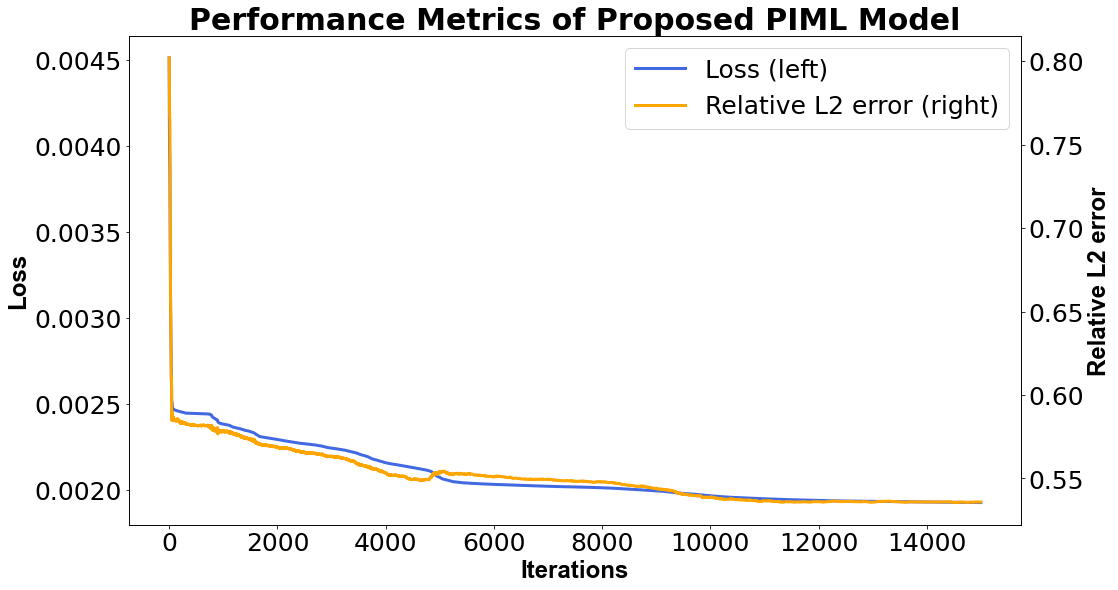

In [17]:
fig, ax1 = plt.subplots()
ax1 = plt.gca() 
ax1.set_facecolor('white')
ax2 = ax1.twinx()
line1 = ax1.plot(loss_record, linewidth = '3', color = "royalblue", label='Loss (left)')
line2 = ax2.plot(l2_record, linewidth = '3', color = "orange", label='Relative L2 error (right)')
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper right')
plt.title("Performance Metrics of Proposed PIML Model", fontsize=30, fontweight="bold")
ax1.set_xlabel("Iterations", fontsize=24, fontname = 'Arial', fontweight="bold")
ax1.set_ylabel("Loss", fontsize=24, fontname = 'Arial', fontweight="bold")
ax2.set_ylabel("Relative L2 error", fontsize=24, fontname = 'Arial', fontweight="bold")
fig.set_size_inches(16, 9)

# 전체 그리드 비교

In [18]:
u_pred = PINN.evaluate(X_u_grid)
u_pred = np.reshape(u_pred,usol.shape,order='F')

y_test = usol
y_pred = u_pred

error_vec = np.linalg.norm((y_test-y_pred),2)/np.linalg.norm(y_test,2)

print('MAE = ', mean_absolute_error(y_test, y_pred))
print('MSE = ', mean_squared_error(y_test, y_pred) )
print('RMSE = ', np.sqrt(mean_squared_error(y_test, y_pred)))
print('L2 relative error =', error_vec)
print('--------------------------------------------------')

MAE =  0.01966199103578098
MSE =  0.0026838903277154632
RMSE =  0.051806276914245275
L2 relative error = 0.49940386787006513
--------------------------------------------------


Text(0, 0.5, 'Remaining Trip Distance (x 1 mile)')

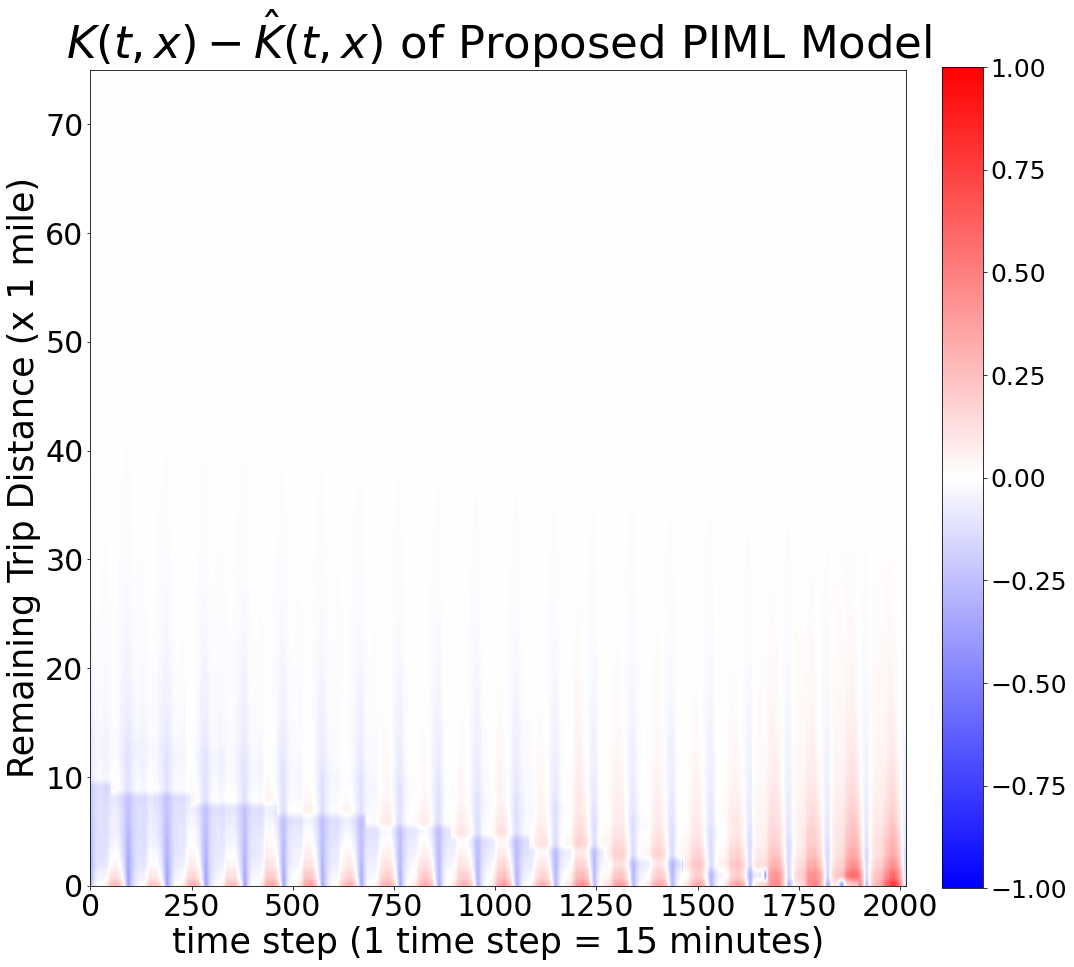

In [19]:
K_array = np.array(u_pred)
K_array = (usol - K_array)

fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.transpose().T, cmap = 'bwr')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,75])
plt.clim(-1, 1) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title(r'$K(t,x)- \hat{K}(t,x)$' ' of Proposed PIML Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (x 1 mile)', fontsize=35)

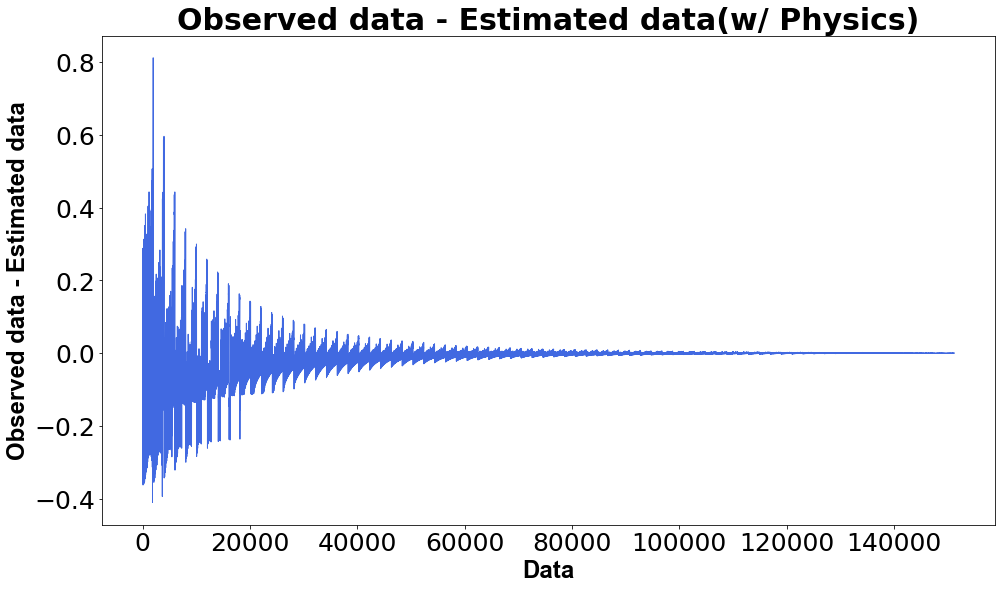

In [20]:
fig, ax1 = plt.subplots()
ax1 = plt.gca() 
ax1.set_facecolor('white')
ax1.plot(K_array.flatten(), linewidth = '1', color = "royalblue", label='Loss (left)')
plt.title("Observed data - Estimated data(w/ Physics)", fontsize=30, fontweight="bold")
ax1.set_xlabel("Data", fontsize=24, fontname = 'Arial', fontweight="bold")
ax1.set_ylabel("Observed data - Estimated data", fontsize=24, fontname = 'Arial', fontweight="bold")

fig.set_size_inches(16, 9)

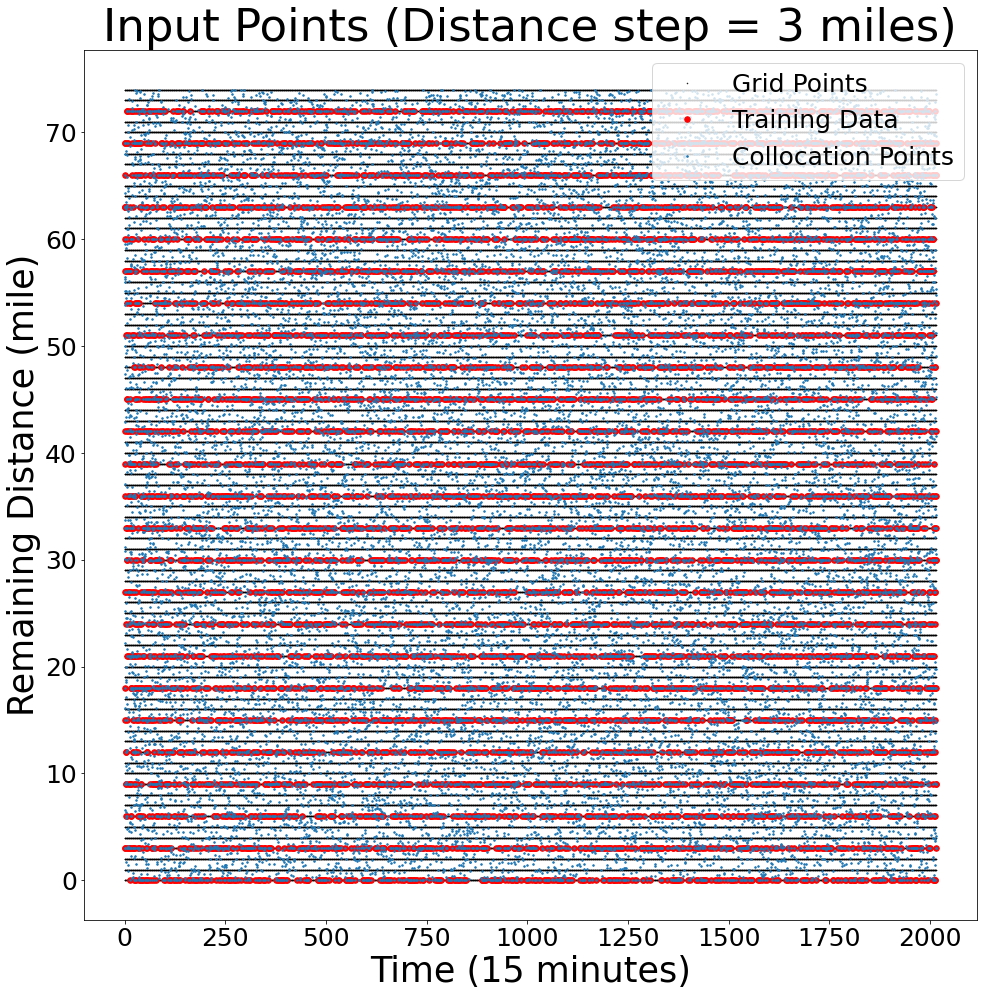

In [23]:
fig,ax = plt.subplots(figsize=(16, 16))
plt.plot(X_u_grid[:,1]*multiplier_time, X_u_grid[:,0]*multiplier_dist, 'o', color = 'black', markersize = 0.5, label = 'Grid Points')
plt.plot(X_u_train[:,1]*multiplier_time, X_u_train[:,0]*multiplier_dist, 'o', color = 'red', markersize = 5.5, label = 'Training Data')
plt.plot(X_f_train[:,1]*multiplier_time, X_f_train[:,0]*multiplier_dist, 'o', markersize = 1.5, label = 'Collocation Points')

plt.rcParams['font.size'] = '25'
plt.xlabel('Time (15 minutes)', fontsize=35)
plt.ylabel('Remaining Distance (mile)', fontsize=35)
plt.title('Input Points (Distance step = 3 miles)', fontsize=45)
plt.legend(loc='upper right')
plt.show()